# EC500 - Group 6 - UNet-based Standard Deviation Noise Maps of CT Images 
**Avantika Kothandaraman, Caiwei Zhang, Long Chen**

## Section-1: Installing the necessary packages

In [2]:
!pip install pynrrd
!pip install SimpleITK
!python -c "import monai" || pip install -q "monai"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [132]:
!pip install monai --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [108]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torch.optim as optim
import os
import nibabel as nib
import nrrd
from torchvision.datasets import ImageFolder
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import ndimage
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    Activations,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureChannelFirst,
    Compose,
    AsChannelLastd,
    CropForegroundd,
    ScaleIntensityd,
    LoadImaged,
    Orientationd,
    Spacingd,
    Invertd,
    RandSpatialCropSamplesd,
    RandSpatialCropSamples,
    RandSpatialCropd,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    RandRotated,
    RandFlipd,
    RandZoomd,
    RandScaleIntensityd, 
    RandShiftIntensityd,
    #AddChannel,
    ToTensord,
    NormalizeIntensityd
)
from monai.handlers.utils import from_engine 
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference 
from monai.inferers import SlidingWindowInferer
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
from patchify import patchify
import monai.transforms as mTransforms
import math
import torch.nn.functional as F


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [3]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Section-2: Initial data inspection and experimentation

In [5]:
# initializing directory
data_dir = "/projectnb/ec500kb/projects/Project6/scans"

In [5]:
# looping through for inspection
count = 0
dims = []
sizes = []
shapes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.nrrd'):
        count += 1
        img, header = nrrd.read(os.path.join(data_dir,filename))
        dims.append(img.ndim)
        sizes.append(img.size)
        shapes.append(img.shape)
        
dims_check = all(dim == dims[0] for dim in dims)
size_check = all(size == sizes[0] for size in sizes)
shape_check = all(shape == shapes[0] for shape in shapes)

if dims_check and size_check and shape_check:
    print('Dimensions, shapes and sizes are uniform')
else:
    print('Dimensions, shapes and sizes are NOT uniform')
    
print('The total number of images in the dataset is {}'.format(count))

Dimensions, shapes and sizes are NOT uniform
The total number of images in the dataset is 30


In [6]:
list(shapes)

[(512, 512, 318),
 (512, 512, 318),
 (512, 512, 823),
 (512, 512, 526),
 (512, 512, 610),
 (512, 512, 823),
 (512, 512, 600),
 (512, 512, 525),
 (512, 512, 560),
 (512, 512, 856),
 (512, 512, 560),
 (512, 512, 610),
 (512, 512, 600),
 (512, 512, 610),
 (512, 512, 585),
 (512, 512, 318),
 (512, 512, 525),
 (512, 512, 526),
 (512, 512, 526),
 (512, 512, 823),
 (512, 512, 525),
 (512, 512, 600),
 (512, 512, 856),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 533),
 (512, 512, 560),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 856)]

In [9]:
def convert_to_2d(img_volume, axis=1):
    return np.max(img_volume, axis=axis)

trans = transforms.Compose([
    transforms.ToTensor()
    #transforms.Resize((512,512)),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

def normalize_to_255(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) * 255
    return normalized_image.astype(np.uint8)

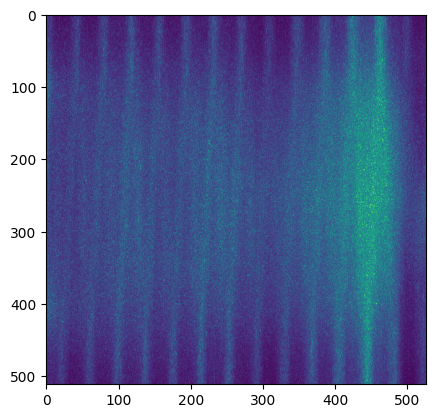

In [50]:
volume, header = nrrd.read(os.path.join(data_dir,'L506_noise.nrrd'))
volume = convert_to_2d(volume)
volume = normalize_to_255(volume)

plt.imshow(volume)
plt.show()

In [20]:
signal, header = nrrd.read(os.path.join(data_dir,'L506_signal.nrrd'))
signal = convert_to_2d(signal)
noise, header = nrrd.read(os.path.join(data_dir,'L506_noise.nrrd'))
noise = convert_to_2d(noise)
k = 5
ct_generated = signal + (k*noise)

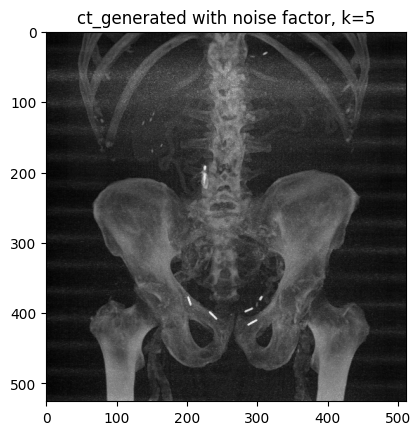

In [21]:
plt.imshow(np.rot90(ct_generated).squeeze(), cmap='gray')
plt.title('ct_generated with noise factor, k=5')
plt.show()

In [9]:
volume_2d = volume_2d.numpy()
volume_2d.dtype

dtype('int16')

In [25]:
def patches(image):
    demo_dict = []
    image = image.squeeze()
    patches = patchify(image.numpy(), (64,64), step=64)
        
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch_img = patches[i,j,:,:]
            demo_dict.append(single_patch_img)
    return demo_dict

In [17]:
patch1 = patches(volume_2d)

In [18]:
len(patch1)

81

In [19]:
patch1[15].shape

(64, 64)

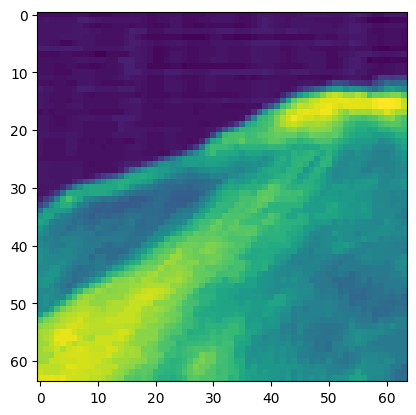

In [20]:
plt.imshow(patch1[13])

## Set deterministic seed for reproducibility

In [8]:
set_determinism(seed=0)

## Section-3: Creating a custom dataset and making transforms for augmentation


In [26]:
class CustomData(torch.utils.data.Dataset):

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        image_sizes = []
        
        for file in os.listdir(self.root_dir):
            if file.endswith('signal.nrrd'):
                image_id = file.split('_')[0]
                
                # reading in the images
                signal_nrrd, _ = nrrd.read(os.path.join(self.root_dir, file))
                noise_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_noise.nrrd"))
                std_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_std.nrrd"))

                # converting to 2D Axial and to tensors
                signal = np.max(signal_nrrd, axis=1)
                noise = np.max(noise_nrrd, axis=1)
                std = np.max(std_nrrd, axis=1)
                
                # converting to tensor
                signal = torch.tensor(signal, dtype = torch.float32)
                noise = torch.tensor(noise, dtype = torch.float32)
                std = torch.tensor(std, dtype = torch.float32)
                                
                # generating input image fromm signal and noise
                k = random.uniform(0,5)
                ct_generated = signal + (k*noise)
                
                # generating patches
                ct_patches = patches(ct_generated)
                std_patches = patches(std)
                
                # storing the new dataset in a dictionary
                for i in range(len(ct_patches)):
                    self.data.append({'ct_generated' : ct_patches[i], 'std_map' : std_patches[i]})
                
                
    def data_info(self, idx):
        item = self.data[idx]
        ct_gen = item['ct_generated']
        std_ma = item['std_map']

        # Print the index of the data item
        print(f"Data item {idx}:")

        # Print the shape of the ct_generated tensor
        print(f"ct_generated shape: {ct_gen.shape}")

        # Print the shape of the std_map tensor
        print(f"std_map shape: {std_ma.shape}")
        
        print(f"ct_generated dtype: {ct_gen.dtype}")
        print(f"std_map dtype: {ct_gen.dtype}")

        print()
            
            
    def plot_ct(self, idx):
        item = self.data[idx]
        ct_generated = item['ct_generated']
        std_map = item['std_map']
        
        # Create a figure
        plt.figure(figsize=(5,5))
        
        # Plot axial view of ct_generated
        plt.subplot(1, 2, 1)
        plt.imshow(ct_generated, cmap='gray')
        plt.title('ct_generated Patch-0')
        plt.axis('off')
        
        # Plot axial view of std_map
        plt.subplot(1, 2, 2)
        plt.imshow(std_map, cmap='hot')
        plt.title('std_map Patch-0')
        plt.axis('off')
        
        # Show the plots
        plt.show()

            
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        return item

In [27]:
custom_dataset = CustomData(root_dir = data_dir)

In [28]:
len(custom_dataset)

704

In [29]:
custom_dataset.data_info(15)

Data item 15:
ct_generated shape: (64, 64)
std_map shape: (64, 64)
ct_generated dtype: float32
std_map dtype: float32



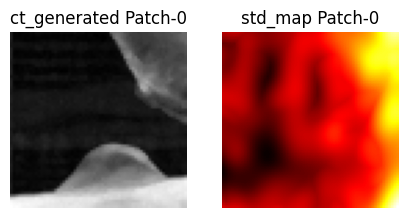

In [30]:
custom_dataset.plot_ct(60)

## Section-4: Data Loader

In [12]:
train_dataset, val_dataset, test_dataset = custom_dataset[:568], custom_dataset[568:640], custom_dataset[640:]
batch_size=1

#train_dataset, testval = train_test_split(custom_dataset, test_size=0.2, random_state=42)
#val_dataset, test_dataset = train_test_split(testval, test_size=0.5, random_state=42)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print(len(train_loader), len(val_loader), len(test_loader))

568 72 64


In [13]:
# Function to print the size of DataLoader
def print_dataloader_sizes(loader, name):
    # Total number of samples
    total_samples = len(loader.dataset)
    
    # Number of batches
    num_batches = len(loader)
    
    # Assuming all batches have the same size except possibly the last one
    batch_size = loader.batch_size
    
    print(f'{name} DataLoader has:')
    print(f'  Total samples: {total_samples}')
    print(f'  Number of batches: {num_batches}')
    print(f'  Batch size: {batch_size}')
    if total_samples % batch_size != 0:
        print(f'  Last batch size: {total_samples % batch_size}')
    else:
        print(f'  All batches have the same size')

# Checking sizes for each DataLoader
print_dataloader_sizes(train_loader, 'Train')
print_dataloader_sizes(val_loader, 'Validation')
print_dataloader_sizes(test_loader, 'Test')


Train DataLoader has:
  Total samples: 568
  Number of batches: 568
  Batch size: 1
  All batches have the same size
Validation DataLoader has:
  Total samples: 72
  Number of batches: 72
  Batch size: 1
  All batches have the same size
Test DataLoader has:
  Total samples: 64
  Number of batches: 64
  Batch size: 1
  All batches have the same size


## Section-5 (a): UNet Training, Validation and Testing 

In [13]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels = None, dropout_rate=0.0):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels # takes output channels as mid channels unless mentioned otherwise
            
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False), # 2d convolution
            nn.BatchNorm2d(mid_channels), # batch normalization
            nn.ReLU(inplace=True), # ReLU activation
            nn.Dropout2d(dropout_rate), # dropout (optional)
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )
        
    def forward(self, x):
        return self.conv_op(x) # forward propagation
    
    
class Down(nn.Module): # downsampling (encoder) layer
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), # max pooling
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input format is CxHxW
        diffY = x2.size()[2] - x1.size()[2] # ensuring dimension uniformity
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2]) # padding, ensuring dimension uniformity

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class OutConv(nn.Module): 
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    
    ''' UNet class to call the model. Initialize with number of in channels and number of classes.
    Dropout is optional. The default is zero and can be changed as per preference. '''
    
    def __init__(self, n_channels, n_classes, bilinear=False, dropout_rate=0.0):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.dropout_rate = dropout_rate

        self.inc = (DoubleConv(n_channels, 64, dropout_rate=dropout_rate))
        self.down1 = (Down(64, 128)) # downsampling
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor)) # bottleneck
        self.up1 = (Up(1024, 512 // factor, bilinear)) # upsampling
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x): # forward propagation
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [15]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(n_channels = 1, n_classes = 1, dropout_rate=0.0).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)


In [16]:
# LOSS Function - Average Relative Error
def average_relative_error(output, target):
    absolute_error = torch.abs(output - target)
    nonzero_mask = target != 0  # Mask for non-zero elements in target
    return torch.mean(torch.abs((absolute_error[nonzero_mask] / target[nonzero_mask])))

In [17]:
# training and validation

train_losses = []
val_losses = []
num_epochs = 300

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # setting the model in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        img = img.unsqueeze(0)
        std_map = images['std_map'].float().to(device)
        std_map = std_map.unsqueeze(0)
        
        optimizer.zero_grad()
        y_pred = model(img)

        loss = average_relative_error(y_pred, std_map)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = image['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

100%|██████████| 72/72 [00:00<00:00, 305.78it/s]


Epoch [1/300], Train Loss: 0.9997, Validation Loss: 0.9995


100%|██████████| 72/72 [00:00<00:00, 307.74it/s]


Epoch [2/300], Train Loss: 0.9993, Validation Loss: 0.9988


100%|██████████| 72/72 [00:00<00:00, 307.28it/s]


Epoch [3/300], Train Loss: 0.9989, Validation Loss: 0.9988


100%|██████████| 72/72 [00:00<00:00, 307.41it/s]


Epoch [4/300], Train Loss: 0.9984, Validation Loss: 0.9979


100%|██████████| 72/72 [00:00<00:00, 307.17it/s]


Epoch [5/300], Train Loss: 0.9979, Validation Loss: 0.9971


100%|██████████| 72/72 [00:00<00:00, 307.53it/s]


Epoch [6/300], Train Loss: 0.9972, Validation Loss: 0.9968


100%|██████████| 72/72 [00:00<00:00, 307.80it/s]


Epoch [7/300], Train Loss: 0.9965, Validation Loss: 0.9952


100%|██████████| 72/72 [00:00<00:00, 306.96it/s]


Epoch [8/300], Train Loss: 0.9956, Validation Loss: 0.9956


100%|██████████| 72/72 [00:00<00:00, 307.97it/s]


Epoch [9/300], Train Loss: 0.9947, Validation Loss: 0.9946


100%|██████████| 72/72 [00:00<00:00, 308.08it/s]


Epoch [10/300], Train Loss: 0.9938, Validation Loss: 0.9915


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [11/300], Train Loss: 0.9927, Validation Loss: 0.9889


100%|██████████| 72/72 [00:00<00:00, 308.00it/s]


Epoch [12/300], Train Loss: 0.9916, Validation Loss: 0.9907


100%|██████████| 72/72 [00:00<00:00, 307.40it/s]


Epoch [13/300], Train Loss: 0.9905, Validation Loss: 0.9883


100%|██████████| 72/72 [00:00<00:00, 308.40it/s]


Epoch [14/300], Train Loss: 0.9892, Validation Loss: 0.9898


100%|██████████| 72/72 [00:00<00:00, 308.31it/s]


Epoch [15/300], Train Loss: 0.9879, Validation Loss: 0.9882


100%|██████████| 72/72 [00:00<00:00, 307.98it/s]


Epoch [16/300], Train Loss: 0.9865, Validation Loss: 0.9879


100%|██████████| 72/72 [00:00<00:00, 307.71it/s]


Epoch [17/300], Train Loss: 0.9851, Validation Loss: 0.9834


100%|██████████| 72/72 [00:00<00:00, 308.32it/s]


Epoch [18/300], Train Loss: 0.9835, Validation Loss: 0.9835


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [19/300], Train Loss: 0.9819, Validation Loss: 0.9798


100%|██████████| 72/72 [00:00<00:00, 308.13it/s]


Epoch [20/300], Train Loss: 0.9801, Validation Loss: 0.9803


100%|██████████| 72/72 [00:00<00:00, 308.53it/s]


Epoch [21/300], Train Loss: 0.9781, Validation Loss: 0.9726


100%|██████████| 72/72 [00:00<00:00, 308.15it/s]


Epoch [22/300], Train Loss: 0.9760, Validation Loss: 0.9729


100%|██████████| 72/72 [00:00<00:00, 308.12it/s]


Epoch [23/300], Train Loss: 0.9738, Validation Loss: 0.9709


100%|██████████| 72/72 [00:00<00:00, 307.97it/s]


Epoch [24/300], Train Loss: 0.9715, Validation Loss: 0.9793


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [25/300], Train Loss: 0.9691, Validation Loss: 0.9684


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [26/300], Train Loss: 0.9666, Validation Loss: 0.9657


100%|██████████| 72/72 [00:00<00:00, 307.95it/s]


Epoch [27/300], Train Loss: 0.9639, Validation Loss: 0.9607


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [28/300], Train Loss: 0.9611, Validation Loss: 0.9494


100%|██████████| 72/72 [00:00<00:00, 308.42it/s]


Epoch [29/300], Train Loss: 0.9583, Validation Loss: 0.9635


100%|██████████| 72/72 [00:00<00:00, 308.14it/s]


Epoch [30/300], Train Loss: 0.9554, Validation Loss: 0.9600


100%|██████████| 72/72 [00:00<00:00, 308.12it/s]


Epoch [31/300], Train Loss: 0.9523, Validation Loss: 0.9407


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [32/300], Train Loss: 0.9492, Validation Loss: 0.9351


100%|██████████| 72/72 [00:00<00:00, 307.87it/s]


Epoch [33/300], Train Loss: 0.9460, Validation Loss: 0.9406


100%|██████████| 72/72 [00:00<00:00, 306.25it/s]


Epoch [34/300], Train Loss: 0.9427, Validation Loss: 0.9564


100%|██████████| 72/72 [00:00<00:00, 308.23it/s]


Epoch [35/300], Train Loss: 0.9393, Validation Loss: 0.9537


100%|██████████| 72/72 [00:00<00:00, 307.61it/s]


Epoch [36/300], Train Loss: 0.9358, Validation Loss: 0.9371


100%|██████████| 72/72 [00:00<00:00, 307.94it/s]


Epoch [37/300], Train Loss: 0.9322, Validation Loss: 0.9386


100%|██████████| 72/72 [00:00<00:00, 305.34it/s]


Epoch [38/300], Train Loss: 0.9285, Validation Loss: 0.9280


100%|██████████| 72/72 [00:00<00:00, 308.09it/s]


Epoch [39/300], Train Loss: 0.9246, Validation Loss: 0.9090


100%|██████████| 72/72 [00:00<00:00, 307.71it/s]


Epoch [40/300], Train Loss: 0.9208, Validation Loss: 0.9311


100%|██████████| 72/72 [00:00<00:00, 308.38it/s]


Epoch [41/300], Train Loss: 0.9168, Validation Loss: 0.9005


100%|██████████| 72/72 [00:00<00:00, 307.56it/s]


Epoch [42/300], Train Loss: 0.9128, Validation Loss: 0.9353


100%|██████████| 72/72 [00:00<00:00, 308.14it/s]


Epoch [43/300], Train Loss: 0.9085, Validation Loss: 0.8858


100%|██████████| 72/72 [00:00<00:00, 307.75it/s]


Epoch [44/300], Train Loss: 0.9042, Validation Loss: 0.9106


100%|██████████| 72/72 [00:00<00:00, 307.32it/s]


Epoch [45/300], Train Loss: 0.8998, Validation Loss: 0.9021


100%|██████████| 72/72 [00:00<00:00, 306.84it/s]


Epoch [46/300], Train Loss: 0.8952, Validation Loss: 0.8674


100%|██████████| 72/72 [00:00<00:00, 307.14it/s]


Epoch [47/300], Train Loss: 0.8906, Validation Loss: 0.8974


100%|██████████| 72/72 [00:00<00:00, 307.52it/s]


Epoch [48/300], Train Loss: 0.8858, Validation Loss: 0.9027


100%|██████████| 72/72 [00:00<00:00, 309.33it/s]


Epoch [49/300], Train Loss: 0.8810, Validation Loss: 0.8576


100%|██████████| 72/72 [00:00<00:00, 308.23it/s]


Epoch [50/300], Train Loss: 0.8760, Validation Loss: 0.8892


100%|██████████| 72/72 [00:00<00:00, 308.33it/s]


Epoch [51/300], Train Loss: 0.8710, Validation Loss: 0.8584


100%|██████████| 72/72 [00:00<00:00, 308.29it/s]


Epoch [52/300], Train Loss: 0.8660, Validation Loss: 0.8818


100%|██████████| 72/72 [00:00<00:00, 308.78it/s]


Epoch [53/300], Train Loss: 0.8607, Validation Loss: 0.8527


100%|██████████| 72/72 [00:00<00:00, 308.72it/s]


Epoch [54/300], Train Loss: 0.8554, Validation Loss: 0.8950


100%|██████████| 72/72 [00:00<00:00, 308.58it/s]


Epoch [55/300], Train Loss: 0.8501, Validation Loss: 0.8082


100%|██████████| 72/72 [00:00<00:00, 308.03it/s]


Epoch [56/300], Train Loss: 0.8445, Validation Loss: 0.8451


100%|██████████| 72/72 [00:00<00:00, 308.45it/s]


Epoch [57/300], Train Loss: 0.8389, Validation Loss: 0.8083


100%|██████████| 72/72 [00:00<00:00, 308.47it/s]


Epoch [58/300], Train Loss: 0.8332, Validation Loss: 0.8373


100%|██████████| 72/72 [00:00<00:00, 308.53it/s]


Epoch [59/300], Train Loss: 0.8274, Validation Loss: 0.7554


100%|██████████| 72/72 [00:00<00:00, 308.68it/s]


Epoch [60/300], Train Loss: 0.8216, Validation Loss: 0.8239


100%|██████████| 72/72 [00:00<00:00, 308.66it/s]


Epoch [61/300], Train Loss: 0.8156, Validation Loss: 0.7673


100%|██████████| 72/72 [00:00<00:00, 308.12it/s]


Epoch [62/300], Train Loss: 0.8095, Validation Loss: 0.8044


100%|██████████| 72/72 [00:00<00:00, 307.84it/s]


Epoch [63/300], Train Loss: 0.8032, Validation Loss: 0.8219


100%|██████████| 72/72 [00:00<00:00, 307.94it/s]


Epoch [64/300], Train Loss: 0.7971, Validation Loss: 0.8126


100%|██████████| 72/72 [00:00<00:00, 308.12it/s]


Epoch [65/300], Train Loss: 0.7907, Validation Loss: 0.8149


100%|██████████| 72/72 [00:00<00:00, 307.72it/s]


Epoch [66/300], Train Loss: 0.7841, Validation Loss: 0.8331


100%|██████████| 72/72 [00:00<00:00, 308.44it/s]


Epoch [67/300], Train Loss: 0.7776, Validation Loss: 0.7946


100%|██████████| 72/72 [00:00<00:00, 308.47it/s]


Epoch [68/300], Train Loss: 0.7711, Validation Loss: 0.7677


100%|██████████| 72/72 [00:00<00:00, 308.88it/s]


Epoch [69/300], Train Loss: 0.7642, Validation Loss: 0.7639


100%|██████████| 72/72 [00:00<00:00, 308.21it/s]


Epoch [70/300], Train Loss: 0.7573, Validation Loss: 0.7468


100%|██████████| 72/72 [00:00<00:00, 309.07it/s]


Epoch [71/300], Train Loss: 0.7504, Validation Loss: 0.8183


100%|██████████| 72/72 [00:00<00:00, 307.63it/s]


Epoch [72/300], Train Loss: 0.7433, Validation Loss: 0.8257


100%|██████████| 72/72 [00:00<00:00, 307.80it/s]


Epoch [73/300], Train Loss: 0.7362, Validation Loss: 0.7372


100%|██████████| 72/72 [00:00<00:00, 307.47it/s]


Epoch [74/300], Train Loss: 0.7291, Validation Loss: 0.7737


100%|██████████| 72/72 [00:00<00:00, 308.05it/s]


Epoch [75/300], Train Loss: 0.7217, Validation Loss: 0.7408


100%|██████████| 72/72 [00:00<00:00, 307.89it/s]


Epoch [76/300], Train Loss: 0.7143, Validation Loss: 0.7506


100%|██████████| 72/72 [00:00<00:00, 306.87it/s]


Epoch [77/300], Train Loss: 0.7068, Validation Loss: 0.7726


100%|██████████| 72/72 [00:00<00:00, 307.36it/s]


Epoch [78/300], Train Loss: 0.6993, Validation Loss: 0.7242


100%|██████████| 72/72 [00:00<00:00, 308.33it/s]


Epoch [79/300], Train Loss: 0.6916, Validation Loss: 0.7931


100%|██████████| 72/72 [00:00<00:00, 307.42it/s]


Epoch [80/300], Train Loss: 0.6839, Validation Loss: 0.8125


100%|██████████| 72/72 [00:00<00:00, 308.06it/s]


Epoch [81/300], Train Loss: 0.6762, Validation Loss: 0.7404


100%|██████████| 72/72 [00:00<00:00, 307.64it/s]


Epoch [82/300], Train Loss: 0.6683, Validation Loss: 0.7784


100%|██████████| 72/72 [00:00<00:00, 308.30it/s]


Epoch [83/300], Train Loss: 0.6602, Validation Loss: 0.6567


100%|██████████| 72/72 [00:00<00:00, 307.15it/s]


Epoch [84/300], Train Loss: 0.6524, Validation Loss: 0.6833


100%|██████████| 72/72 [00:00<00:00, 309.50it/s]


Epoch [85/300], Train Loss: 0.6444, Validation Loss: 0.7303


100%|██████████| 72/72 [00:00<00:00, 308.66it/s]


Epoch [86/300], Train Loss: 0.6360, Validation Loss: 0.7038


100%|██████████| 72/72 [00:00<00:00, 307.99it/s]


Epoch [87/300], Train Loss: 0.6278, Validation Loss: 0.6766


100%|██████████| 72/72 [00:00<00:00, 308.92it/s]


Epoch [88/300], Train Loss: 0.6198, Validation Loss: 0.7116


100%|██████████| 72/72 [00:00<00:00, 308.73it/s]


Epoch [89/300], Train Loss: 0.6111, Validation Loss: 0.7100


100%|██████████| 72/72 [00:00<00:00, 308.67it/s]


Epoch [90/300], Train Loss: 0.6027, Validation Loss: 0.7578


100%|██████████| 72/72 [00:00<00:00, 307.90it/s]


Epoch [91/300], Train Loss: 0.5943, Validation Loss: 0.6870


100%|██████████| 72/72 [00:00<00:00, 308.45it/s]


Epoch [92/300], Train Loss: 0.5859, Validation Loss: 0.6520


100%|██████████| 72/72 [00:00<00:00, 308.76it/s]


Epoch [93/300], Train Loss: 0.5772, Validation Loss: 0.7449


100%|██████████| 72/72 [00:00<00:00, 308.62it/s]


Epoch [94/300], Train Loss: 0.5687, Validation Loss: 0.6300


100%|██████████| 72/72 [00:00<00:00, 309.07it/s]


Epoch [95/300], Train Loss: 0.5602, Validation Loss: 0.6912


100%|██████████| 72/72 [00:00<00:00, 309.08it/s]


Epoch [96/300], Train Loss: 0.5515, Validation Loss: 0.6289


100%|██████████| 72/72 [00:00<00:00, 308.82it/s]


Epoch [97/300], Train Loss: 0.5431, Validation Loss: 0.6420


100%|██████████| 72/72 [00:00<00:00, 308.49it/s]


Epoch [98/300], Train Loss: 0.5349, Validation Loss: 0.6160


100%|██████████| 72/72 [00:00<00:00, 308.24it/s]


Epoch [99/300], Train Loss: 0.5256, Validation Loss: 0.6299


100%|██████████| 72/72 [00:00<00:00, 308.48it/s]


Epoch [100/300], Train Loss: 0.5171, Validation Loss: 0.6805


100%|██████████| 72/72 [00:00<00:00, 308.89it/s]


Epoch [101/300], Train Loss: 0.5085, Validation Loss: 0.6674


100%|██████████| 72/72 [00:00<00:00, 309.23it/s]


Epoch [102/300], Train Loss: 0.5006, Validation Loss: 0.6052


100%|██████████| 72/72 [00:00<00:00, 308.65it/s]


Epoch [103/300], Train Loss: 0.4914, Validation Loss: 0.5848


100%|██████████| 72/72 [00:00<00:00, 307.93it/s]


Epoch [104/300], Train Loss: 0.4831, Validation Loss: 0.5682


100%|██████████| 72/72 [00:00<00:00, 309.02it/s]


Epoch [105/300], Train Loss: 0.4748, Validation Loss: 0.5938


100%|██████████| 72/72 [00:00<00:00, 308.47it/s]


Epoch [106/300], Train Loss: 0.4663, Validation Loss: 0.6456


100%|██████████| 72/72 [00:00<00:00, 309.16it/s]


Epoch [107/300], Train Loss: 0.4578, Validation Loss: 0.6335


100%|██████████| 72/72 [00:00<00:00, 309.21it/s]


Epoch [108/300], Train Loss: 0.4505, Validation Loss: 0.6672


100%|██████████| 72/72 [00:00<00:00, 309.21it/s]


Epoch [109/300], Train Loss: 0.4416, Validation Loss: 0.5957


100%|██████████| 72/72 [00:00<00:00, 309.41it/s]


Epoch [110/300], Train Loss: 0.4332, Validation Loss: 0.5242


100%|██████████| 72/72 [00:00<00:00, 309.12it/s]


Epoch [111/300], Train Loss: 0.4256, Validation Loss: 0.6790


100%|██████████| 72/72 [00:00<00:00, 308.52it/s]


Epoch [112/300], Train Loss: 0.4167, Validation Loss: 0.5894


100%|██████████| 72/72 [00:00<00:00, 309.26it/s]


Epoch [113/300], Train Loss: 0.4093, Validation Loss: 0.6364


100%|██████████| 72/72 [00:00<00:00, 308.85it/s]


Epoch [114/300], Train Loss: 0.4019, Validation Loss: 0.5402


100%|██████████| 72/72 [00:00<00:00, 309.26it/s]


Epoch [115/300], Train Loss: 0.3925, Validation Loss: 0.5992


100%|██████████| 72/72 [00:00<00:00, 309.03it/s]


Epoch [116/300], Train Loss: 0.3852, Validation Loss: 0.5983


100%|██████████| 72/72 [00:00<00:00, 309.22it/s]


Epoch [117/300], Train Loss: 0.3766, Validation Loss: 0.6613


100%|██████████| 72/72 [00:00<00:00, 309.08it/s]


Epoch [118/300], Train Loss: 0.3693, Validation Loss: 0.6292


100%|██████████| 72/72 [00:00<00:00, 309.40it/s]


Epoch [119/300], Train Loss: 0.3628, Validation Loss: 0.5818


100%|██████████| 72/72 [00:00<00:00, 309.08it/s]


Epoch [120/300], Train Loss: 0.3548, Validation Loss: 0.5142


100%|██████████| 72/72 [00:00<00:00, 309.38it/s]


Epoch [121/300], Train Loss: 0.3477, Validation Loss: 0.5172


100%|██████████| 72/72 [00:00<00:00, 307.48it/s]


Epoch [122/300], Train Loss: 0.3403, Validation Loss: 0.5288


100%|██████████| 72/72 [00:00<00:00, 307.65it/s]


Epoch [123/300], Train Loss: 0.3332, Validation Loss: 0.5710


100%|██████████| 72/72 [00:00<00:00, 308.13it/s]


Epoch [124/300], Train Loss: 0.3276, Validation Loss: 0.6058


100%|██████████| 72/72 [00:00<00:00, 307.61it/s]


Epoch [125/300], Train Loss: 0.3222, Validation Loss: 0.6145


100%|██████████| 72/72 [00:00<00:00, 309.18it/s]


Epoch [126/300], Train Loss: 0.3147, Validation Loss: 0.6089


100%|██████████| 72/72 [00:00<00:00, 309.23it/s]


Epoch [127/300], Train Loss: 0.3093, Validation Loss: 0.4950


100%|██████████| 72/72 [00:00<00:00, 308.98it/s]


Epoch [128/300], Train Loss: 0.3043, Validation Loss: 0.4820


100%|██████████| 72/72 [00:00<00:00, 309.08it/s]


Epoch [129/300], Train Loss: 0.2974, Validation Loss: 0.5442


100%|██████████| 72/72 [00:00<00:00, 309.07it/s]


Epoch [130/300], Train Loss: 0.2923, Validation Loss: 0.4976


100%|██████████| 72/72 [00:00<00:00, 307.97it/s]


Epoch [131/300], Train Loss: 0.2868, Validation Loss: 0.5294


100%|██████████| 72/72 [00:00<00:00, 307.58it/s]


Epoch [132/300], Train Loss: 0.2824, Validation Loss: 0.4669


100%|██████████| 72/72 [00:00<00:00, 307.79it/s]


Epoch [133/300], Train Loss: 0.2768, Validation Loss: 0.4688


100%|██████████| 72/72 [00:00<00:00, 308.74it/s]


Epoch [134/300], Train Loss: 0.2732, Validation Loss: 0.5372


100%|██████████| 72/72 [00:00<00:00, 308.93it/s]


Epoch [135/300], Train Loss: 0.2671, Validation Loss: 0.4873


100%|██████████| 72/72 [00:00<00:00, 308.66it/s]


Epoch [136/300], Train Loss: 0.2615, Validation Loss: 0.5437


100%|██████████| 72/72 [00:00<00:00, 308.30it/s]


Epoch [137/300], Train Loss: 0.2568, Validation Loss: 0.5430


100%|██████████| 72/72 [00:00<00:00, 308.82it/s]


Epoch [138/300], Train Loss: 0.2541, Validation Loss: 0.4554


100%|██████████| 72/72 [00:00<00:00, 309.05it/s]


Epoch [139/300], Train Loss: 0.2511, Validation Loss: 0.4223


100%|██████████| 72/72 [00:00<00:00, 308.58it/s]


Epoch [140/300], Train Loss: 0.2464, Validation Loss: 0.4423


100%|██████████| 72/72 [00:00<00:00, 307.73it/s]


Epoch [141/300], Train Loss: 0.2415, Validation Loss: 0.4927


100%|██████████| 72/72 [00:00<00:00, 307.05it/s]


Epoch [142/300], Train Loss: 0.2381, Validation Loss: 0.5082


100%|██████████| 72/72 [00:00<00:00, 307.94it/s]


Epoch [143/300], Train Loss: 0.2342, Validation Loss: 0.4925


100%|██████████| 72/72 [00:00<00:00, 307.82it/s]


Epoch [144/300], Train Loss: 0.2310, Validation Loss: 0.4245


100%|██████████| 72/72 [00:00<00:00, 307.87it/s]


Epoch [145/300], Train Loss: 0.2265, Validation Loss: 0.4956


100%|██████████| 72/72 [00:00<00:00, 307.66it/s]


Epoch [146/300], Train Loss: 0.2248, Validation Loss: 0.3955


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [147/300], Train Loss: 0.2227, Validation Loss: 0.5272


100%|██████████| 72/72 [00:00<00:00, 307.69it/s]


Epoch [148/300], Train Loss: 0.2184, Validation Loss: 0.4643


100%|██████████| 72/72 [00:00<00:00, 306.86it/s]


Epoch [149/300], Train Loss: 0.2170, Validation Loss: 0.4161


100%|██████████| 72/72 [00:00<00:00, 306.63it/s]


Epoch [150/300], Train Loss: 0.2126, Validation Loss: 0.4230


100%|██████████| 72/72 [00:00<00:00, 307.93it/s]


Epoch [151/300], Train Loss: 0.2110, Validation Loss: 0.4035


100%|██████████| 72/72 [00:00<00:00, 307.99it/s]


Epoch [152/300], Train Loss: 0.2081, Validation Loss: 0.4669


100%|██████████| 72/72 [00:00<00:00, 307.62it/s]


Epoch [153/300], Train Loss: 0.2061, Validation Loss: 0.3867


100%|██████████| 72/72 [00:00<00:00, 307.80it/s]


Epoch [154/300], Train Loss: 0.2021, Validation Loss: 0.3884


100%|██████████| 72/72 [00:00<00:00, 307.61it/s]


Epoch [155/300], Train Loss: 0.1994, Validation Loss: 0.3984


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [156/300], Train Loss: 0.1966, Validation Loss: 0.5325


100%|██████████| 72/72 [00:00<00:00, 307.80it/s]]


Epoch [157/300], Train Loss: 0.1966, Validation Loss: 0.4379


100%|██████████| 72/72 [00:00<00:00, 307.75it/s]


Epoch [158/300], Train Loss: 0.1935, Validation Loss: 0.3909


100%|██████████| 72/72 [00:00<00:00, 307.87it/s]


Epoch [159/300], Train Loss: 0.1912, Validation Loss: 0.4205


100%|██████████| 72/72 [00:00<00:00, 308.20it/s]


Epoch [160/300], Train Loss: 0.1889, Validation Loss: 0.4058


100%|██████████| 72/72 [00:00<00:00, 308.49it/s]


Epoch [161/300], Train Loss: 0.1859, Validation Loss: 0.4723


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [162/300], Train Loss: 0.1848, Validation Loss: 0.4009


100%|██████████| 72/72 [00:00<00:00, 308.39it/s]


Epoch [163/300], Train Loss: 0.1833, Validation Loss: 0.4761


100%|██████████| 72/72 [00:00<00:00, 308.82it/s]


Epoch [164/300], Train Loss: 0.1827, Validation Loss: 0.3718


100%|██████████| 72/72 [00:00<00:00, 308.31it/s]


Epoch [165/300], Train Loss: 0.1809, Validation Loss: 0.4130


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [166/300], Train Loss: 0.1774, Validation Loss: 0.3970


100%|██████████| 72/72 [00:00<00:00, 308.66it/s]


Epoch [167/300], Train Loss: 0.1742, Validation Loss: 0.4471


100%|██████████| 72/72 [00:00<00:00, 308.35it/s]


Epoch [168/300], Train Loss: 0.1753, Validation Loss: 0.4486


100%|██████████| 72/72 [00:00<00:00, 307.72it/s]


Epoch [169/300], Train Loss: 0.1736, Validation Loss: 0.4185


100%|██████████| 72/72 [00:00<00:00, 308.59it/s]


Epoch [170/300], Train Loss: 0.1716, Validation Loss: 0.4235


100%|██████████| 72/72 [00:00<00:00, 309.59it/s]


Epoch [171/300], Train Loss: 0.1702, Validation Loss: 0.3828


100%|██████████| 72/72 [00:00<00:00, 308.56it/s]


Epoch [172/300], Train Loss: 0.1674, Validation Loss: 0.3871


100%|██████████| 72/72 [00:00<00:00, 308.58it/s]


Epoch [173/300], Train Loss: 0.1684, Validation Loss: 0.4032


100%|██████████| 72/72 [00:00<00:00, 307.72it/s]


Epoch [174/300], Train Loss: 0.1656, Validation Loss: 0.4685


100%|██████████| 72/72 [00:00<00:00, 308.34it/s]


Epoch [175/300], Train Loss: 0.1663, Validation Loss: 0.4473


100%|██████████| 72/72 [00:00<00:00, 308.03it/s]


Epoch [176/300], Train Loss: 0.1637, Validation Loss: 0.3923


100%|██████████| 72/72 [00:00<00:00, 307.89it/s]


Epoch [177/300], Train Loss: 0.1621, Validation Loss: 0.4442


100%|██████████| 72/72 [00:00<00:00, 306.19it/s]


Epoch [178/300], Train Loss: 0.1601, Validation Loss: 0.3928


100%|██████████| 72/72 [00:00<00:00, 308.08it/s]


Epoch [179/300], Train Loss: 0.1598, Validation Loss: 0.4583


100%|██████████| 72/72 [00:00<00:00, 307.90it/s]


Epoch [180/300], Train Loss: 0.1592, Validation Loss: 0.4160


100%|██████████| 72/72 [00:00<00:00, 307.91it/s]


Epoch [181/300], Train Loss: 0.1585, Validation Loss: 0.3766


100%|██████████| 72/72 [00:00<00:00, 307.25it/s]


Epoch [182/300], Train Loss: 0.1559, Validation Loss: 0.4068


100%|██████████| 72/72 [00:00<00:00, 308.16it/s]


Epoch [183/300], Train Loss: 0.1577, Validation Loss: 0.4887


100%|██████████| 72/72 [00:00<00:00, 307.57it/s]


Epoch [184/300], Train Loss: 0.1564, Validation Loss: 0.4830


100%|██████████| 72/72 [00:00<00:00, 307.64it/s]


Epoch [185/300], Train Loss: 0.1537, Validation Loss: 0.3690


100%|██████████| 72/72 [00:00<00:00, 307.51it/s]


Epoch [186/300], Train Loss: 0.1531, Validation Loss: 0.3458


100%|██████████| 72/72 [00:00<00:00, 307.99it/s]


Epoch [187/300], Train Loss: 0.1526, Validation Loss: 0.4289


100%|██████████| 72/72 [00:00<00:00, 307.37it/s]


Epoch [188/300], Train Loss: 0.1523, Validation Loss: 0.4218


100%|██████████| 72/72 [00:00<00:00, 308.25it/s]


Epoch [189/300], Train Loss: 0.1493, Validation Loss: 0.3756


100%|██████████| 72/72 [00:00<00:00, 307.70it/s]


Epoch [190/300], Train Loss: 0.1500, Validation Loss: 0.4001


100%|██████████| 72/72 [00:00<00:00, 308.02it/s]


Epoch [191/300], Train Loss: 0.1486, Validation Loss: 0.3564


100%|██████████| 72/72 [00:00<00:00, 307.97it/s]


Epoch [192/300], Train Loss: 0.1494, Validation Loss: 0.4081


100%|██████████| 72/72 [00:00<00:00, 307.26it/s]


Epoch [193/300], Train Loss: 0.1479, Validation Loss: 0.4344


100%|██████████| 72/72 [00:00<00:00, 304.92it/s]


Epoch [194/300], Train Loss: 0.1456, Validation Loss: 0.4726


100%|██████████| 72/72 [00:00<00:00, 309.82it/s]


Epoch [195/300], Train Loss: 0.1448, Validation Loss: 0.4125


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [196/300], Train Loss: 0.1439, Validation Loss: 0.3635


100%|██████████| 72/72 [00:00<00:00, 308.68it/s]


Epoch [197/300], Train Loss: 0.1435, Validation Loss: 0.3754


100%|██████████| 72/72 [00:00<00:00, 307.04it/s]


Epoch [198/300], Train Loss: 0.1441, Validation Loss: 0.4212


100%|██████████| 72/72 [00:00<00:00, 307.83it/s]


Epoch [199/300], Train Loss: 0.1428, Validation Loss: 0.3875


100%|██████████| 72/72 [00:00<00:00, 307.75it/s]


Epoch [200/300], Train Loss: 0.1410, Validation Loss: 0.3244


100%|██████████| 72/72 [00:00<00:00, 307.82it/s]


Epoch [201/300], Train Loss: 0.1415, Validation Loss: 0.3883


100%|██████████| 72/72 [00:00<00:00, 312.08it/s]


Epoch [202/300], Train Loss: 0.1413, Validation Loss: 0.3159


100%|██████████| 72/72 [00:00<00:00, 313.80it/s]


Epoch [203/300], Train Loss: 0.1390, Validation Loss: 0.3502


100%|██████████| 72/72 [00:00<00:00, 314.87it/s]


Epoch [204/300], Train Loss: 0.1386, Validation Loss: 0.3626


100%|██████████| 72/72 [00:00<00:00, 314.13it/s]


Epoch [205/300], Train Loss: 0.1374, Validation Loss: 0.3645


100%|██████████| 72/72 [00:00<00:00, 315.16it/s]


Epoch [206/300], Train Loss: 0.1376, Validation Loss: 0.4502


100%|██████████| 72/72 [00:00<00:00, 315.20it/s]


Epoch [207/300], Train Loss: 0.1368, Validation Loss: 0.4776


100%|██████████| 72/72 [00:00<00:00, 314.87it/s]


Epoch [208/300], Train Loss: 0.1355, Validation Loss: 0.3919


100%|██████████| 72/72 [00:00<00:00, 312.49it/s]


Epoch [209/300], Train Loss: 0.1352, Validation Loss: 0.3970


100%|██████████| 72/72 [00:00<00:00, 314.94it/s]


Epoch [210/300], Train Loss: 0.1344, Validation Loss: 0.4304


100%|██████████| 72/72 [00:00<00:00, 293.93it/s]


Epoch [211/300], Train Loss: 0.1347, Validation Loss: 0.4544


100%|██████████| 72/72 [00:00<00:00, 312.71it/s]


Epoch [212/300], Train Loss: 0.1335, Validation Loss: 0.3701


100%|██████████| 72/72 [00:00<00:00, 312.48it/s]


Epoch [213/300], Train Loss: 0.1323, Validation Loss: 0.4074


100%|██████████| 72/72 [00:00<00:00, 312.41it/s]


Epoch [214/300], Train Loss: 0.1320, Validation Loss: 0.4008


100%|██████████| 72/72 [00:00<00:00, 311.83it/s]


Epoch [215/300], Train Loss: 0.1315, Validation Loss: 0.4918


100%|██████████| 72/72 [00:00<00:00, 312.93it/s]


Epoch [216/300], Train Loss: 0.1300, Validation Loss: 0.3870


100%|██████████| 72/72 [00:00<00:00, 312.69it/s]


Epoch [217/300], Train Loss: 0.1299, Validation Loss: 0.3939


100%|██████████| 72/72 [00:00<00:00, 313.39it/s]


Epoch [218/300], Train Loss: 0.1306, Validation Loss: 0.4043


100%|██████████| 72/72 [00:00<00:00, 313.30it/s]


Epoch [219/300], Train Loss: 0.1298, Validation Loss: 0.3278


100%|██████████| 72/72 [00:00<00:00, 312.85it/s]


Epoch [220/300], Train Loss: 0.1288, Validation Loss: 0.3869


100%|██████████| 72/72 [00:00<00:00, 311.09it/s]


Epoch [221/300], Train Loss: 0.1284, Validation Loss: 0.3934


100%|██████████| 72/72 [00:00<00:00, 312.36it/s]


Epoch [222/300], Train Loss: 0.1256, Validation Loss: 0.3557


100%|██████████| 72/72 [00:00<00:00, 311.72it/s]


Epoch [223/300], Train Loss: 0.1260, Validation Loss: 0.3998


100%|██████████| 72/72 [00:00<00:00, 310.53it/s]


Epoch [224/300], Train Loss: 0.1257, Validation Loss: 0.4084


100%|██████████| 72/72 [00:00<00:00, 310.62it/s]


Epoch [225/300], Train Loss: 0.1249, Validation Loss: 0.4041


100%|██████████| 72/72 [00:00<00:00, 311.87it/s]


Epoch [226/300], Train Loss: 0.1257, Validation Loss: 0.4226


100%|██████████| 72/72 [00:00<00:00, 310.31it/s]


Epoch [227/300], Train Loss: 0.1251, Validation Loss: 0.3694


100%|██████████| 72/72 [00:00<00:00, 312.25it/s]


Epoch [228/300], Train Loss: 0.1226, Validation Loss: 0.3592


100%|██████████| 72/72 [00:00<00:00, 312.79it/s]


Epoch [229/300], Train Loss: 0.1230, Validation Loss: 0.4199


100%|██████████| 72/72 [00:00<00:00, 310.16it/s]


Epoch [230/300], Train Loss: 0.1219, Validation Loss: 0.3808


100%|██████████| 72/72 [00:00<00:00, 311.18it/s]


Epoch [231/300], Train Loss: 0.1225, Validation Loss: 0.3499


100%|██████████| 72/72 [00:00<00:00, 312.69it/s]


Epoch [232/300], Train Loss: 0.1221, Validation Loss: 0.3280


100%|██████████| 72/72 [00:00<00:00, 311.68it/s]


Epoch [233/300], Train Loss: 0.1203, Validation Loss: 0.3931


100%|██████████| 72/72 [00:00<00:00, 310.91it/s]


Epoch [234/300], Train Loss: 0.1197, Validation Loss: 0.3670


100%|██████████| 72/72 [00:00<00:00, 311.32it/s]


Epoch [235/300], Train Loss: 0.1198, Validation Loss: 0.3511


100%|██████████| 72/72 [00:00<00:00, 313.18it/s]


Epoch [236/300], Train Loss: 0.1189, Validation Loss: 0.3984


100%|██████████| 72/72 [00:00<00:00, 312.66it/s]


Epoch [237/300], Train Loss: 0.1188, Validation Loss: 0.4048


100%|██████████| 72/72 [00:00<00:00, 311.61it/s]


Epoch [238/300], Train Loss: 0.1189, Validation Loss: 0.3958


100%|██████████| 72/72 [00:00<00:00, 312.50it/s]


Epoch [239/300], Train Loss: 0.1170, Validation Loss: 0.3642


100%|██████████| 72/72 [00:00<00:00, 311.92it/s]


Epoch [240/300], Train Loss: 0.1168, Validation Loss: 0.3521


100%|██████████| 72/72 [00:00<00:00, 312.25it/s]


Epoch [241/300], Train Loss: 0.1160, Validation Loss: 0.4198


100%|██████████| 72/72 [00:00<00:00, 314.18it/s]


Epoch [242/300], Train Loss: 0.1165, Validation Loss: 0.4314


100%|██████████| 72/72 [00:00<00:00, 313.20it/s]


Epoch [243/300], Train Loss: 0.1167, Validation Loss: 0.3778


100%|██████████| 72/72 [00:00<00:00, 312.86it/s]


Epoch [244/300], Train Loss: 0.1156, Validation Loss: 0.4226


100%|██████████| 72/72 [00:00<00:00, 313.19it/s]


Epoch [245/300], Train Loss: 0.1147, Validation Loss: 0.3580


100%|██████████| 72/72 [00:00<00:00, 312.12it/s]


Epoch [246/300], Train Loss: 0.1141, Validation Loss: 0.4600


100%|██████████| 72/72 [00:00<00:00, 312.67it/s]


Epoch [247/300], Train Loss: 0.1131, Validation Loss: 0.4425


100%|██████████| 72/72 [00:00<00:00, 313.39it/s]


Epoch [248/300], Train Loss: 0.1127, Validation Loss: 0.3860


100%|██████████| 72/72 [00:00<00:00, 313.88it/s]


Epoch [249/300], Train Loss: 0.1117, Validation Loss: 0.3735


100%|██████████| 72/72 [00:00<00:00, 312.87it/s]


Epoch [250/300], Train Loss: 0.1124, Validation Loss: 0.4045


100%|██████████| 72/72 [00:00<00:00, 314.16it/s]


Epoch [251/300], Train Loss: 0.1110, Validation Loss: 0.3954


100%|██████████| 72/72 [00:00<00:00, 314.37it/s]


Epoch [252/300], Train Loss: 0.1106, Validation Loss: 0.3949


100%|██████████| 72/72 [00:00<00:00, 313.98it/s]


Epoch [253/300], Train Loss: 0.1114, Validation Loss: 0.3813


100%|██████████| 72/72 [00:00<00:00, 313.66it/s]


Epoch [254/300], Train Loss: 0.1104, Validation Loss: 0.3528


100%|██████████| 72/72 [00:00<00:00, 314.25it/s]


Epoch [255/300], Train Loss: 0.1092, Validation Loss: 0.4178


100%|██████████| 72/72 [00:00<00:00, 313.73it/s]


Epoch [256/300], Train Loss: 0.1092, Validation Loss: 0.4249


100%|██████████| 72/72 [00:00<00:00, 314.36it/s]


Epoch [257/300], Train Loss: 0.1089, Validation Loss: 0.3826


100%|██████████| 72/72 [00:00<00:00, 315.78it/s]


Epoch [258/300], Train Loss: 0.1088, Validation Loss: 0.4415


100%|██████████| 72/72 [00:00<00:00, 316.33it/s]


Epoch [259/300], Train Loss: 0.1078, Validation Loss: 0.4190


100%|██████████| 72/72 [00:00<00:00, 315.34it/s]


Epoch [260/300], Train Loss: 0.1068, Validation Loss: 0.3944


100%|██████████| 72/72 [00:00<00:00, 316.23it/s]


Epoch [261/300], Train Loss: 0.1065, Validation Loss: 0.3746


100%|██████████| 72/72 [00:00<00:00, 315.87it/s]


Epoch [262/300], Train Loss: 0.1067, Validation Loss: 0.3726


100%|██████████| 72/72 [00:00<00:00, 315.65it/s]


Epoch [263/300], Train Loss: 0.1071, Validation Loss: 0.4630


100%|██████████| 72/72 [00:00<00:00, 316.02it/s]


Epoch [264/300], Train Loss: 0.1053, Validation Loss: 0.5030


100%|██████████| 72/72 [00:00<00:00, 314.79it/s]


Epoch [265/300], Train Loss: 0.1046, Validation Loss: 0.3562


100%|██████████| 72/72 [00:00<00:00, 315.51it/s]


Epoch [266/300], Train Loss: 0.1042, Validation Loss: 0.4512


100%|██████████| 72/72 [00:00<00:00, 315.51it/s]


Epoch [267/300], Train Loss: 0.1046, Validation Loss: 0.3493


100%|██████████| 72/72 [00:00<00:00, 315.14it/s]


Epoch [268/300], Train Loss: 0.1037, Validation Loss: 0.3546


100%|██████████| 72/72 [00:00<00:00, 315.29it/s]


Epoch [269/300], Train Loss: 0.1030, Validation Loss: 0.4200


100%|██████████| 72/72 [00:00<00:00, 315.26it/s]


Epoch [270/300], Train Loss: 0.1030, Validation Loss: 0.3851


100%|██████████| 72/72 [00:00<00:00, 315.24it/s]


Epoch [271/300], Train Loss: 0.1026, Validation Loss: 0.4415


100%|██████████| 72/72 [00:00<00:00, 314.79it/s]


Epoch [272/300], Train Loss: 0.1015, Validation Loss: 0.3872


100%|██████████| 72/72 [00:00<00:00, 315.67it/s]


Epoch [273/300], Train Loss: 0.1014, Validation Loss: 0.4187


100%|██████████| 72/72 [00:00<00:00, 316.33it/s]


Epoch [274/300], Train Loss: 0.1022, Validation Loss: 0.4405


100%|██████████| 72/72 [00:00<00:00, 315.43it/s]


Epoch [275/300], Train Loss: 0.1007, Validation Loss: 0.4142


100%|██████████| 72/72 [00:00<00:00, 316.51it/s]


Epoch [276/300], Train Loss: 0.0996, Validation Loss: 0.3730


100%|██████████| 72/72 [00:00<00:00, 316.49it/s]


Epoch [277/300], Train Loss: 0.1004, Validation Loss: 0.3558


100%|██████████| 72/72 [00:00<00:00, 316.22it/s]


Epoch [278/300], Train Loss: 0.1008, Validation Loss: 0.4001


100%|██████████| 72/72 [00:00<00:00, 316.55it/s]


Epoch [279/300], Train Loss: 0.0992, Validation Loss: 0.3858


100%|██████████| 72/72 [00:00<00:00, 316.12it/s]


Epoch [280/300], Train Loss: 0.0975, Validation Loss: 0.3816


100%|██████████| 72/72 [00:00<00:00, 316.27it/s]


Epoch [281/300], Train Loss: 0.0972, Validation Loss: 0.4071


100%|██████████| 72/72 [00:00<00:00, 312.10it/s]


Epoch [282/300], Train Loss: 0.0968, Validation Loss: 0.4031


100%|██████████| 72/72 [00:00<00:00, 312.88it/s]


Epoch [283/300], Train Loss: 0.0971, Validation Loss: 0.3740


100%|██████████| 72/72 [00:00<00:00, 312.80it/s]


Epoch [284/300], Train Loss: 0.0970, Validation Loss: 0.4264


100%|██████████| 72/72 [00:00<00:00, 314.57it/s]


Epoch [285/300], Train Loss: 0.0970, Validation Loss: 0.4544


100%|██████████| 72/72 [00:00<00:00, 314.13it/s]


Epoch [286/300], Train Loss: 0.0959, Validation Loss: 0.3616


100%|██████████| 72/72 [00:00<00:00, 314.17it/s]


Epoch [287/300], Train Loss: 0.0963, Validation Loss: 0.3958


100%|██████████| 72/72 [00:00<00:00, 314.58it/s]


Epoch [288/300], Train Loss: 0.0955, Validation Loss: 0.3717


100%|██████████| 72/72 [00:00<00:00, 314.66it/s]


Epoch [289/300], Train Loss: 0.0950, Validation Loss: 0.4180


100%|██████████| 72/72 [00:00<00:00, 312.62it/s]


Epoch [290/300], Train Loss: 0.0949, Validation Loss: 0.4324


100%|██████████| 72/72 [00:00<00:00, 312.96it/s]


Epoch [291/300], Train Loss: 0.0944, Validation Loss: 0.3788


100%|██████████| 72/72 [00:00<00:00, 312.43it/s]


Epoch [292/300], Train Loss: 0.0937, Validation Loss: 0.3985


100%|██████████| 72/72 [00:00<00:00, 312.91it/s]


Epoch [293/300], Train Loss: 0.0936, Validation Loss: 0.4121


100%|██████████| 72/72 [00:00<00:00, 313.16it/s]


Epoch [294/300], Train Loss: 0.0933, Validation Loss: 0.3897


100%|██████████| 72/72 [00:00<00:00, 312.97it/s]


Epoch [295/300], Train Loss: 0.0925, Validation Loss: 0.4839


100%|██████████| 72/72 [00:00<00:00, 312.58it/s]


Epoch [296/300], Train Loss: 0.0926, Validation Loss: 0.4694


100%|██████████| 72/72 [00:00<00:00, 309.18it/s]


Epoch [297/300], Train Loss: 0.0925, Validation Loss: 0.4703


100%|██████████| 72/72 [00:00<00:00, 315.52it/s]


Epoch [298/300], Train Loss: 0.0915, Validation Loss: 0.4191


100%|██████████| 72/72 [00:00<00:00, 315.48it/s]


Epoch [299/300], Train Loss: 0.0918, Validation Loss: 0.4475


100%|██████████| 72/72 [00:00<00:00, 314.46it/s]

Epoch [300/300], Train Loss: 0.0911, Validation Loss: 0.3622


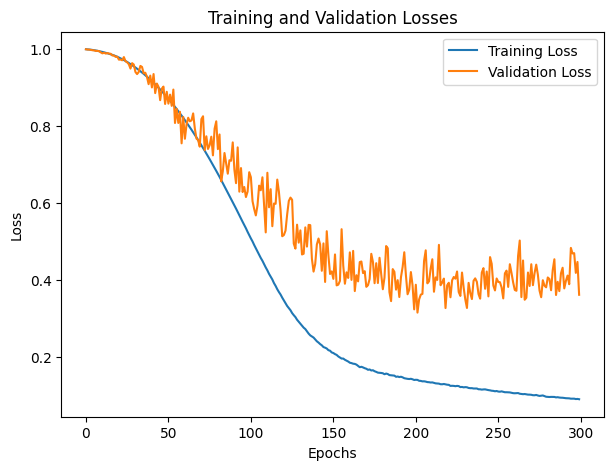

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xticks(range(0, len(train_losses), 1))  # Specify tick locations every 5 epochs
plt.legend()
plt.show()

## Section-5 (b): Training and Testing UNet without dropout

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels = None):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv_op(x)
    
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [14]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(n_channels = 1, n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model_saving_path = '/projectnb/ec500kb/projects/Project6/'

In [18]:
# training and validation

train_losses = []
val_losses = []
num_epochs = 300

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        img = img.unsqueeze(0)
        std_map = images['std_map'].float().to(device)
        std_map = std_map.unsqueeze(0)
        #print(img.shape)
        #print(std_map.shape)
        optimizer.zero_grad()
        y_pred = model(img)
        #print(y_pred.shape)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = image['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

100%|██████████| 72/72 [00:00<00:00, 447.93it/s]


Epoch [1/300], Train Loss: 0.9997, Validation Loss: 0.9995


100%|██████████| 72/72 [00:00<00:00, 455.23it/s]


Epoch [2/300], Train Loss: 0.9993, Validation Loss: 0.9991


100%|██████████| 72/72 [00:00<00:00, 456.34it/s]


Epoch [3/300], Train Loss: 0.9989, Validation Loss: 0.9985


100%|██████████| 72/72 [00:00<00:00, 454.05it/s]


Epoch [4/300], Train Loss: 0.9984, Validation Loss: 0.9979


100%|██████████| 72/72 [00:00<00:00, 455.14it/s]


Epoch [5/300], Train Loss: 0.9978, Validation Loss: 0.9971


100%|██████████| 72/72 [00:00<00:00, 456.16it/s]


Epoch [6/300], Train Loss: 0.9972, Validation Loss: 0.9969


100%|██████████| 72/72 [00:00<00:00, 454.72it/s]


Epoch [7/300], Train Loss: 0.9965, Validation Loss: 0.9963


100%|██████████| 72/72 [00:00<00:00, 455.35it/s]


Epoch [8/300], Train Loss: 0.9956, Validation Loss: 0.9935


100%|██████████| 72/72 [00:00<00:00, 454.69it/s]


Epoch [9/300], Train Loss: 0.9946, Validation Loss: 0.9928


100%|██████████| 72/72 [00:00<00:00, 455.35it/s]


Epoch [10/300], Train Loss: 0.9935, Validation Loss: 0.9927


100%|██████████| 72/72 [00:00<00:00, 455.82it/s]


Epoch [11/300], Train Loss: 0.9924, Validation Loss: 0.9920


100%|██████████| 72/72 [00:00<00:00, 456.67it/s]


Epoch [12/300], Train Loss: 0.9912, Validation Loss: 0.9878


100%|██████████| 72/72 [00:00<00:00, 456.10it/s]


Epoch [13/300], Train Loss: 0.9899, Validation Loss: 0.9856


100%|██████████| 72/72 [00:00<00:00, 456.76it/s]


Epoch [14/300], Train Loss: 0.9884, Validation Loss: 0.9852


100%|██████████| 72/72 [00:00<00:00, 455.85it/s]


Epoch [15/300], Train Loss: 0.9868, Validation Loss: 0.9851


100%|██████████| 72/72 [00:00<00:00, 454.63it/s]


Epoch [16/300], Train Loss: 0.9851, Validation Loss: 0.9852


100%|██████████| 72/72 [00:00<00:00, 455.12it/s]


Epoch [17/300], Train Loss: 0.9832, Validation Loss: 0.9860


100%|██████████| 72/72 [00:00<00:00, 455.20it/s]


Epoch [18/300], Train Loss: 0.9813, Validation Loss: 0.9806


100%|██████████| 72/72 [00:00<00:00, 455.37it/s]


Epoch [19/300], Train Loss: 0.9793, Validation Loss: 0.9719


100%|██████████| 72/72 [00:00<00:00, 455.00it/s]


Epoch [20/300], Train Loss: 0.9771, Validation Loss: 0.9738


100%|██████████| 72/72 [00:00<00:00, 455.28it/s]


Epoch [21/300], Train Loss: 0.9749, Validation Loss: 0.9729


100%|██████████| 72/72 [00:00<00:00, 455.67it/s]


Epoch [22/300], Train Loss: 0.9726, Validation Loss: 0.9703


100%|██████████| 72/72 [00:00<00:00, 454.07it/s]


Epoch [23/300], Train Loss: 0.9702, Validation Loss: 0.9713


100%|██████████| 72/72 [00:00<00:00, 454.92it/s]


Epoch [24/300], Train Loss: 0.9677, Validation Loss: 0.9759


100%|██████████| 72/72 [00:00<00:00, 452.97it/s]


Epoch [25/300], Train Loss: 0.9651, Validation Loss: 0.9593


100%|██████████| 72/72 [00:00<00:00, 454.12it/s]


Epoch [26/300], Train Loss: 0.9624, Validation Loss: 0.9577


100%|██████████| 72/72 [00:00<00:00, 453.57it/s]


Epoch [27/300], Train Loss: 0.9594, Validation Loss: 0.9641


100%|██████████| 72/72 [00:00<00:00, 454.65it/s]


Epoch [28/300], Train Loss: 0.9564, Validation Loss: 0.9429


100%|██████████| 72/72 [00:00<00:00, 452.61it/s]


Epoch [29/300], Train Loss: 0.9533, Validation Loss: 0.9512


100%|██████████| 72/72 [00:00<00:00, 453.50it/s]


Epoch [30/300], Train Loss: 0.9502, Validation Loss: 0.9391


100%|██████████| 72/72 [00:00<00:00, 453.29it/s]


Epoch [31/300], Train Loss: 0.9469, Validation Loss: 0.9483


100%|██████████| 72/72 [00:00<00:00, 452.47it/s]


Epoch [32/300], Train Loss: 0.9435, Validation Loss: 0.9530


100%|██████████| 72/72 [00:00<00:00, 461.02it/s]


Epoch [33/300], Train Loss: 0.9401, Validation Loss: 0.9458


100%|██████████| 72/72 [00:00<00:00, 454.50it/s]


Epoch [34/300], Train Loss: 0.9365, Validation Loss: 0.9320


100%|██████████| 72/72 [00:00<00:00, 453.69it/s]


Epoch [35/300], Train Loss: 0.9329, Validation Loss: 0.9351


100%|██████████| 72/72 [00:00<00:00, 454.41it/s]


Epoch [36/300], Train Loss: 0.9291, Validation Loss: 0.9356


100%|██████████| 72/72 [00:00<00:00, 453.40it/s]


Epoch [37/300], Train Loss: 0.9253, Validation Loss: 0.9327


100%|██████████| 72/72 [00:00<00:00, 455.26it/s]


Epoch [38/300], Train Loss: 0.9214, Validation Loss: 0.9284


100%|██████████| 72/72 [00:00<00:00, 453.28it/s]


Epoch [39/300], Train Loss: 0.9174, Validation Loss: 0.9131


100%|██████████| 72/72 [00:00<00:00, 454.12it/s]


Epoch [40/300], Train Loss: 0.9133, Validation Loss: 0.9115


100%|██████████| 72/72 [00:00<00:00, 451.99it/s]


Epoch [41/300], Train Loss: 0.9090, Validation Loss: 0.9291


100%|██████████| 72/72 [00:00<00:00, 443.50it/s]


Epoch [42/300], Train Loss: 0.9046, Validation Loss: 0.8817


100%|██████████| 72/72 [00:00<00:00, 452.04it/s]


Epoch [43/300], Train Loss: 0.9001, Validation Loss: 0.8903


100%|██████████| 72/72 [00:00<00:00, 458.09it/s]


Epoch [44/300], Train Loss: 0.8957, Validation Loss: 0.8898


100%|██████████| 72/72 [00:00<00:00, 455.22it/s]


Epoch [45/300], Train Loss: 0.8911, Validation Loss: 0.9087


100%|██████████| 72/72 [00:00<00:00, 453.68it/s]


Epoch [46/300], Train Loss: 0.8864, Validation Loss: 0.8878


100%|██████████| 72/72 [00:00<00:00, 451.91it/s]


Epoch [47/300], Train Loss: 0.8815, Validation Loss: 0.8476


100%|██████████| 72/72 [00:00<00:00, 455.10it/s]


Epoch [48/300], Train Loss: 0.8766, Validation Loss: 0.8564


100%|██████████| 72/72 [00:00<00:00, 456.32it/s]


Epoch [49/300], Train Loss: 0.8716, Validation Loss: 0.8765


100%|██████████| 72/72 [00:00<00:00, 459.29it/s]


Epoch [50/300], Train Loss: 0.8665, Validation Loss: 0.8810


100%|██████████| 72/72 [00:00<00:00, 461.43it/s]


Epoch [51/300], Train Loss: 0.8612, Validation Loss: 0.8793


100%|██████████| 72/72 [00:00<00:00, 461.89it/s]


Epoch [52/300], Train Loss: 0.8560, Validation Loss: 0.9075


100%|██████████| 72/72 [00:00<00:00, 460.61it/s]


Epoch [53/300], Train Loss: 0.8506, Validation Loss: 0.8625


100%|██████████| 72/72 [00:00<00:00, 462.43it/s]


Epoch [54/300], Train Loss: 0.8450, Validation Loss: 0.8403


100%|██████████| 72/72 [00:00<00:00, 461.96it/s]


Epoch [55/300], Train Loss: 0.8396, Validation Loss: 0.8389


100%|██████████| 72/72 [00:00<00:00, 462.32it/s]


Epoch [56/300], Train Loss: 0.8338, Validation Loss: 0.8070


100%|██████████| 72/72 [00:00<00:00, 461.81it/s]


Epoch [57/300], Train Loss: 0.8280, Validation Loss: 0.8361


100%|██████████| 72/72 [00:00<00:00, 462.94it/s]


Epoch [58/300], Train Loss: 0.8221, Validation Loss: 0.8440


100%|██████████| 72/72 [00:00<00:00, 461.88it/s]


Epoch [59/300], Train Loss: 0.8162, Validation Loss: 0.8045


100%|██████████| 72/72 [00:00<00:00, 463.19it/s]


Epoch [60/300], Train Loss: 0.8099, Validation Loss: 0.8040


100%|██████████| 72/72 [00:00<00:00, 463.44it/s]


Epoch [61/300], Train Loss: 0.8037, Validation Loss: 0.7782


100%|██████████| 72/72 [00:00<00:00, 463.01it/s]


Epoch [62/300], Train Loss: 0.7969, Validation Loss: 0.8197


100%|██████████| 72/72 [00:00<00:00, 462.28it/s]


Epoch [63/300], Train Loss: 0.7899, Validation Loss: 0.8187


100%|██████████| 72/72 [00:00<00:00, 463.94it/s]


Epoch [64/300], Train Loss: 0.7834, Validation Loss: 0.8083


100%|██████████| 72/72 [00:00<00:00, 462.17it/s]


Epoch [65/300], Train Loss: 0.7767, Validation Loss: 0.7563


100%|██████████| 72/72 [00:00<00:00, 463.75it/s]


Epoch [66/300], Train Loss: 0.7700, Validation Loss: 0.8053


100%|██████████| 72/72 [00:00<00:00, 463.24it/s]


Epoch [67/300], Train Loss: 0.7632, Validation Loss: 0.8058


100%|██████████| 72/72 [00:00<00:00, 464.59it/s]


Epoch [68/300], Train Loss: 0.7563, Validation Loss: 0.8048


100%|██████████| 72/72 [00:00<00:00, 462.61it/s]


Epoch [69/300], Train Loss: 0.7493, Validation Loss: 0.7251


100%|██████████| 72/72 [00:00<00:00, 463.25it/s]


Epoch [70/300], Train Loss: 0.7422, Validation Loss: 0.7987


100%|██████████| 72/72 [00:00<00:00, 464.60it/s]


Epoch [71/300], Train Loss: 0.7351, Validation Loss: 0.7802


100%|██████████| 72/72 [00:00<00:00, 465.67it/s]


Epoch [72/300], Train Loss: 0.7277, Validation Loss: 0.7209


100%|██████████| 72/72 [00:00<00:00, 465.95it/s]


Epoch [73/300], Train Loss: 0.7206, Validation Loss: 0.7723


100%|██████████| 72/72 [00:00<00:00, 465.76it/s]


Epoch [74/300], Train Loss: 0.7132, Validation Loss: 0.7976


100%|██████████| 72/72 [00:00<00:00, 461.67it/s]


Epoch [75/300], Train Loss: 0.7056, Validation Loss: 0.7311


100%|██████████| 72/72 [00:00<00:00, 465.90it/s]


Epoch [76/300], Train Loss: 0.6982, Validation Loss: 0.7522


100%|██████████| 72/72 [00:00<00:00, 464.31it/s]


Epoch [77/300], Train Loss: 0.6904, Validation Loss: 0.7492


100%|██████████| 72/72 [00:00<00:00, 465.51it/s]


Epoch [78/300], Train Loss: 0.6827, Validation Loss: 0.7857


100%|██████████| 72/72 [00:00<00:00, 465.59it/s]


Epoch [79/300], Train Loss: 0.6747, Validation Loss: 0.7326


100%|██████████| 72/72 [00:00<00:00, 465.72it/s]


Epoch [80/300], Train Loss: 0.6667, Validation Loss: 0.7809


100%|██████████| 72/72 [00:00<00:00, 465.76it/s]


Epoch [81/300], Train Loss: 0.6589, Validation Loss: 0.7131


100%|██████████| 72/72 [00:00<00:00, 465.72it/s]


Epoch [82/300], Train Loss: 0.6509, Validation Loss: 0.7563


100%|██████████| 72/72 [00:00<00:00, 465.02it/s]


Epoch [83/300], Train Loss: 0.6426, Validation Loss: 0.6616


100%|██████████| 72/72 [00:00<00:00, 466.63it/s]


Epoch [84/300], Train Loss: 0.6345, Validation Loss: 0.8025


100%|██████████| 72/72 [00:00<00:00, 465.29it/s]


Epoch [85/300], Train Loss: 0.6261, Validation Loss: 0.7304


100%|██████████| 72/72 [00:00<00:00, 465.81it/s]


Epoch [86/300], Train Loss: 0.6179, Validation Loss: 0.7161


100%|██████████| 72/72 [00:00<00:00, 457.32it/s]


Epoch [87/300], Train Loss: 0.6093, Validation Loss: 0.6765


100%|██████████| 72/72 [00:00<00:00, 467.04it/s]


Epoch [88/300], Train Loss: 0.6010, Validation Loss: 0.6702


100%|██████████| 72/72 [00:00<00:00, 461.12it/s]


Epoch [89/300], Train Loss: 0.5925, Validation Loss: 0.6684


100%|██████████| 72/72 [00:00<00:00, 465.25it/s]


Epoch [90/300], Train Loss: 0.5840, Validation Loss: 0.6889


100%|██████████| 72/72 [00:00<00:00, 463.03it/s]


Epoch [91/300], Train Loss: 0.5755, Validation Loss: 0.6533


100%|██████████| 72/72 [00:00<00:00, 464.40it/s]


Epoch [92/300], Train Loss: 0.5668, Validation Loss: 0.6359


100%|██████████| 72/72 [00:00<00:00, 463.67it/s]


Epoch [93/300], Train Loss: 0.5583, Validation Loss: 0.7055


100%|██████████| 72/72 [00:00<00:00, 464.57it/s]


Epoch [94/300], Train Loss: 0.5495, Validation Loss: 0.6640


100%|██████████| 72/72 [00:00<00:00, 463.49it/s]


Epoch [95/300], Train Loss: 0.5408, Validation Loss: 0.7038


100%|██████████| 72/72 [00:00<00:00, 464.53it/s]


Epoch [96/300], Train Loss: 0.5321, Validation Loss: 0.6835


100%|██████████| 72/72 [00:00<00:00, 463.26it/s]


Epoch [97/300], Train Loss: 0.5231, Validation Loss: 0.6526


100%|██████████| 72/72 [00:00<00:00, 467.17it/s]


Epoch [98/300], Train Loss: 0.5145, Validation Loss: 0.6770


100%|██████████| 72/72 [00:00<00:00, 464.57it/s]


Epoch [99/300], Train Loss: 0.5061, Validation Loss: 0.6193


100%|██████████| 72/72 [00:00<00:00, 465.70it/s]


Epoch [100/300], Train Loss: 0.4978, Validation Loss: 0.7242


100%|██████████| 72/72 [00:00<00:00, 464.63it/s]


Epoch [101/300], Train Loss: 0.4893, Validation Loss: 0.5945


100%|██████████| 72/72 [00:00<00:00, 465.23it/s]


Epoch [102/300], Train Loss: 0.4804, Validation Loss: 0.6537


100%|██████████| 72/72 [00:00<00:00, 464.44it/s]


Epoch [103/300], Train Loss: 0.4722, Validation Loss: 0.6374


100%|██████████| 72/72 [00:00<00:00, 465.85it/s]


Epoch [104/300], Train Loss: 0.4634, Validation Loss: 0.6096


100%|██████████| 72/72 [00:00<00:00, 465.65it/s]


Epoch [105/300], Train Loss: 0.4548, Validation Loss: 0.6055


100%|██████████| 72/72 [00:00<00:00, 465.50it/s]


Epoch [106/300], Train Loss: 0.4462, Validation Loss: 0.6337


100%|██████████| 72/72 [00:00<00:00, 462.97it/s]


Epoch [107/300], Train Loss: 0.4384, Validation Loss: 0.5825


100%|██████████| 72/72 [00:00<00:00, 463.35it/s]


Epoch [108/300], Train Loss: 0.4292, Validation Loss: 0.5734


100%|██████████| 72/72 [00:00<00:00, 463.88it/s]


Epoch [109/300], Train Loss: 0.4217, Validation Loss: 0.5743


100%|██████████| 72/72 [00:00<00:00, 464.46it/s]


Epoch [110/300], Train Loss: 0.4135, Validation Loss: 0.5476


100%|██████████| 72/72 [00:00<00:00, 465.73it/s]


Epoch [111/300], Train Loss: 0.4056, Validation Loss: 0.5841


100%|██████████| 72/72 [00:00<00:00, 466.44it/s]


Epoch [112/300], Train Loss: 0.3965, Validation Loss: 0.6350


100%|██████████| 72/72 [00:00<00:00, 464.44it/s]


Epoch [113/300], Train Loss: 0.3893, Validation Loss: 0.6018


100%|██████████| 72/72 [00:00<00:00, 464.90it/s]


Epoch [114/300], Train Loss: 0.3831, Validation Loss: 0.5306


100%|██████████| 72/72 [00:00<00:00, 463.18it/s]


Epoch [115/300], Train Loss: 0.3744, Validation Loss: 0.6400


100%|██████████| 72/72 [00:00<00:00, 464.46it/s]


Epoch [116/300], Train Loss: 0.3662, Validation Loss: 0.6247


100%|██████████| 72/72 [00:00<00:00, 463.25it/s]


Epoch [117/300], Train Loss: 0.3590, Validation Loss: 0.5705


100%|██████████| 72/72 [00:00<00:00, 465.91it/s]


Epoch [118/300], Train Loss: 0.3511, Validation Loss: 0.6034


100%|██████████| 72/72 [00:00<00:00, 464.45it/s]


Epoch [119/300], Train Loss: 0.3447, Validation Loss: 0.6193


100%|██████████| 72/72 [00:00<00:00, 465.20it/s]


Epoch [120/300], Train Loss: 0.3380, Validation Loss: 0.5567


100%|██████████| 72/72 [00:00<00:00, 464.27it/s]


Epoch [121/300], Train Loss: 0.3322, Validation Loss: 0.5988


100%|██████████| 72/72 [00:00<00:00, 465.15it/s]


Epoch [122/300], Train Loss: 0.3246, Validation Loss: 0.6069


100%|██████████| 72/72 [00:00<00:00, 464.57it/s]


Epoch [123/300], Train Loss: 0.3193, Validation Loss: 0.5527


100%|██████████| 72/72 [00:00<00:00, 464.51it/s]


Epoch [124/300], Train Loss: 0.3127, Validation Loss: 0.6400


100%|██████████| 72/72 [00:00<00:00, 464.37it/s]


Epoch [125/300], Train Loss: 0.3058, Validation Loss: 0.5195


100%|██████████| 72/72 [00:00<00:00, 464.85it/s]


Epoch [126/300], Train Loss: 0.3022, Validation Loss: 0.6061


100%|██████████| 72/72 [00:00<00:00, 465.74it/s]


Epoch [127/300], Train Loss: 0.2965, Validation Loss: 0.5153


100%|██████████| 72/72 [00:00<00:00, 462.74it/s]


Epoch [128/300], Train Loss: 0.2897, Validation Loss: 0.5399


100%|██████████| 72/72 [00:00<00:00, 464.33it/s]


Epoch [129/300], Train Loss: 0.2845, Validation Loss: 0.5676


100%|██████████| 72/72 [00:00<00:00, 465.57it/s]


Epoch [130/300], Train Loss: 0.2813, Validation Loss: 0.4616


100%|██████████| 72/72 [00:00<00:00, 462.28it/s]


Epoch [131/300], Train Loss: 0.2741, Validation Loss: 0.5271


100%|██████████| 72/72 [00:00<00:00, 465.06it/s]


Epoch [132/300], Train Loss: 0.2704, Validation Loss: 0.5772


100%|██████████| 72/72 [00:00<00:00, 458.08it/s]


Epoch [133/300], Train Loss: 0.2643, Validation Loss: 0.5336


100%|██████████| 72/72 [00:00<00:00, 465.81it/s]


Epoch [134/300], Train Loss: 0.2606, Validation Loss: 0.4883


100%|██████████| 72/72 [00:00<00:00, 464.13it/s]


Epoch [135/300], Train Loss: 0.2559, Validation Loss: 0.4700


100%|██████████| 72/72 [00:00<00:00, 465.36it/s]


Epoch [136/300], Train Loss: 0.2518, Validation Loss: 0.5167


100%|██████████| 72/72 [00:00<00:00, 465.46it/s]


Epoch [137/300], Train Loss: 0.2477, Validation Loss: 0.4348


100%|██████████| 72/72 [00:00<00:00, 466.14it/s]


Epoch [138/300], Train Loss: 0.2446, Validation Loss: 0.4937


100%|██████████| 72/72 [00:00<00:00, 464.46it/s]


Epoch [139/300], Train Loss: 0.2400, Validation Loss: 0.4798


100%|██████████| 72/72 [00:00<00:00, 465.70it/s]


Epoch [140/300], Train Loss: 0.2377, Validation Loss: 0.4655


100%|██████████| 72/72 [00:00<00:00, 464.12it/s]


Epoch [141/300], Train Loss: 0.2337, Validation Loss: 0.4107


100%|██████████| 72/72 [00:00<00:00, 465.50it/s]


Epoch [142/300], Train Loss: 0.2302, Validation Loss: 0.4391


100%|██████████| 72/72 [00:00<00:00, 464.63it/s]


Epoch [143/300], Train Loss: 0.2264, Validation Loss: 0.4606


100%|██████████| 72/72 [00:00<00:00, 465.64it/s]


Epoch [144/300], Train Loss: 0.2244, Validation Loss: 0.4254


100%|██████████| 72/72 [00:00<00:00, 458.65it/s]


Epoch [145/300], Train Loss: 0.2191, Validation Loss: 0.4270


100%|██████████| 72/72 [00:00<00:00, 465.81it/s]


Epoch [146/300], Train Loss: 0.2165, Validation Loss: 0.4861


100%|██████████| 72/72 [00:00<00:00, 466.03it/s]


Epoch [147/300], Train Loss: 0.2122, Validation Loss: 0.5081


100%|██████████| 72/72 [00:00<00:00, 467.21it/s]


Epoch [148/300], Train Loss: 0.2110, Validation Loss: 0.4500


100%|██████████| 72/72 [00:00<00:00, 464.58it/s]


Epoch [149/300], Train Loss: 0.2073, Validation Loss: 0.3933


100%|██████████| 72/72 [00:00<00:00, 427.42it/s]


Epoch [150/300], Train Loss: 0.2039, Validation Loss: 0.4211


100%|██████████| 72/72 [00:00<00:00, 435.10it/s]


Epoch [151/300], Train Loss: 0.2014, Validation Loss: 0.3631


100%|██████████| 72/72 [00:00<00:00, 463.51it/s]


Epoch [152/300], Train Loss: 0.1980, Validation Loss: 0.4141


100%|██████████| 72/72 [00:00<00:00, 463.49it/s]


Epoch [153/300], Train Loss: 0.1966, Validation Loss: 0.4298


100%|██████████| 72/72 [00:00<00:00, 463.93it/s]


Epoch [154/300], Train Loss: 0.1944, Validation Loss: 0.3892


100%|██████████| 72/72 [00:00<00:00, 463.36it/s]


Epoch [155/300], Train Loss: 0.1917, Validation Loss: 0.4075


100%|██████████| 72/72 [00:00<00:00, 448.14it/s]


Epoch [156/300], Train Loss: 0.1889, Validation Loss: 0.4212


100%|██████████| 72/72 [00:00<00:00, 472.51it/s]


Epoch [157/300], Train Loss: 0.1867, Validation Loss: 0.3785


100%|██████████| 72/72 [00:00<00:00, 470.44it/s]


Epoch [158/300], Train Loss: 0.1851, Validation Loss: 0.4129


100%|██████████| 72/72 [00:00<00:00, 472.25it/s]


Epoch [159/300], Train Loss: 0.1811, Validation Loss: 0.4064


100%|██████████| 72/72 [00:00<00:00, 474.24it/s]


Epoch [160/300], Train Loss: 0.1814, Validation Loss: 0.3752


100%|██████████| 72/72 [00:00<00:00, 467.88it/s]


Epoch [161/300], Train Loss: 0.1786, Validation Loss: 0.3862


100%|██████████| 72/72 [00:00<00:00, 471.56it/s]


Epoch [162/300], Train Loss: 0.1768, Validation Loss: 0.3849


100%|██████████| 72/72 [00:00<00:00, 463.10it/s]


Epoch [163/300], Train Loss: 0.1755, Validation Loss: 0.3617


100%|██████████| 72/72 [00:00<00:00, 464.00it/s]


Epoch [164/300], Train Loss: 0.1747, Validation Loss: 0.3833


100%|██████████| 72/72 [00:00<00:00, 470.35it/s]


Epoch [165/300], Train Loss: 0.1713, Validation Loss: 0.3574


100%|██████████| 72/72 [00:00<00:00, 472.18it/s]


Epoch [166/300], Train Loss: 0.1702, Validation Loss: 0.3657


100%|██████████| 72/72 [00:00<00:00, 472.45it/s]


Epoch [167/300], Train Loss: 0.1687, Validation Loss: 0.3752


100%|██████████| 72/72 [00:00<00:00, 471.79it/s]


Epoch [168/300], Train Loss: 0.1670, Validation Loss: 0.3855


100%|██████████| 72/72 [00:00<00:00, 471.25it/s]


Epoch [169/300], Train Loss: 0.1655, Validation Loss: 0.3666


100%|██████████| 72/72 [00:00<00:00, 467.42it/s]


Epoch [170/300], Train Loss: 0.1639, Validation Loss: 0.4132


100%|██████████| 72/72 [00:00<00:00, 465.07it/s]


Epoch [171/300], Train Loss: 0.1624, Validation Loss: 0.3766


100%|██████████| 72/72 [00:00<00:00, 464.73it/s]


Epoch [172/300], Train Loss: 0.1608, Validation Loss: 0.3543


100%|██████████| 72/72 [00:00<00:00, 465.41it/s]


Epoch [173/300], Train Loss: 0.1586, Validation Loss: 0.3607


100%|██████████| 72/72 [00:00<00:00, 473.35it/s]


Epoch [174/300], Train Loss: 0.1569, Validation Loss: 0.3262


100%|██████████| 72/72 [00:00<00:00, 463.70it/s]


Epoch [175/300], Train Loss: 0.1579, Validation Loss: 0.3598


100%|██████████| 72/72 [00:00<00:00, 467.80it/s]


Epoch [176/300], Train Loss: 0.1572, Validation Loss: 0.3399


100%|██████████| 72/72 [00:00<00:00, 466.54it/s]


Epoch [177/300], Train Loss: 0.1558, Validation Loss: 0.3520


100%|██████████| 72/72 [00:00<00:00, 464.91it/s]


Epoch [178/300], Train Loss: 0.1537, Validation Loss: 0.3586


100%|██████████| 72/72 [00:00<00:00, 471.60it/s]


Epoch [179/300], Train Loss: 0.1531, Validation Loss: 0.3122


100%|██████████| 72/72 [00:00<00:00, 472.55it/s]


Epoch [180/300], Train Loss: 0.1525, Validation Loss: 0.3562


100%|██████████| 72/72 [00:00<00:00, 474.03it/s]


Epoch [181/300], Train Loss: 0.1507, Validation Loss: 0.3403


100%|██████████| 72/72 [00:00<00:00, 468.41it/s]


Epoch [182/300], Train Loss: 0.1483, Validation Loss: 0.3545


100%|██████████| 72/72 [00:00<00:00, 463.92it/s]


Epoch [183/300], Train Loss: 0.1495, Validation Loss: 0.3545


100%|██████████| 72/72 [00:00<00:00, 466.62it/s]


Epoch [184/300], Train Loss: 0.1471, Validation Loss: 0.3133


100%|██████████| 72/72 [00:00<00:00, 472.54it/s]


Epoch [185/300], Train Loss: 0.1468, Validation Loss: 0.3271


100%|██████████| 72/72 [00:00<00:00, 474.69it/s]


Epoch [186/300], Train Loss: 0.1461, Validation Loss: 0.3289


100%|██████████| 72/72 [00:00<00:00, 472.64it/s]


Epoch [187/300], Train Loss: 0.1456, Validation Loss: 0.3434


100%|██████████| 72/72 [00:00<00:00, 466.69it/s]


Epoch [188/300], Train Loss: 0.1438, Validation Loss: 0.3279


100%|██████████| 72/72 [00:00<00:00, 472.02it/s]


Epoch [189/300], Train Loss: 0.1442, Validation Loss: 0.3679


100%|██████████| 72/72 [00:00<00:00, 451.84it/s]


Epoch [190/300], Train Loss: 0.1416, Validation Loss: 0.2994


100%|██████████| 72/72 [00:00<00:00, 461.75it/s]


Epoch [191/300], Train Loss: 0.1407, Validation Loss: 0.3065


100%|██████████| 72/72 [00:00<00:00, 461.75it/s]


Epoch [192/300], Train Loss: 0.1406, Validation Loss: 0.3220


100%|██████████| 72/72 [00:00<00:00, 465.48it/s]


Epoch [193/300], Train Loss: 0.1416, Validation Loss: 0.3263


100%|██████████| 72/72 [00:00<00:00, 461.00it/s]


Epoch [194/300], Train Loss: 0.1400, Validation Loss: 0.3155


100%|██████████| 72/72 [00:00<00:00, 463.90it/s]


Epoch [195/300], Train Loss: 0.1397, Validation Loss: 0.3193


100%|██████████| 72/72 [00:00<00:00, 463.57it/s]


Epoch [196/300], Train Loss: 0.1378, Validation Loss: 0.2842


100%|██████████| 72/72 [00:00<00:00, 460.32it/s]


Epoch [197/300], Train Loss: 0.1375, Validation Loss: 0.3196


100%|██████████| 72/72 [00:00<00:00, 458.93it/s]


Epoch [198/300], Train Loss: 0.1365, Validation Loss: 0.3459


100%|██████████| 72/72 [00:00<00:00, 463.08it/s]


Epoch [199/300], Train Loss: 0.1374, Validation Loss: 0.3010


100%|██████████| 72/72 [00:00<00:00, 460.49it/s]


Epoch [200/300], Train Loss: 0.1349, Validation Loss: 0.3254


100%|██████████| 72/72 [00:00<00:00, 461.53it/s]


Epoch [201/300], Train Loss: 0.1351, Validation Loss: 0.3065


100%|██████████| 72/72 [00:00<00:00, 465.71it/s]


Epoch [202/300], Train Loss: 0.1345, Validation Loss: 0.3194


100%|██████████| 72/72 [00:00<00:00, 465.55it/s]


Epoch [203/300], Train Loss: 0.1341, Validation Loss: 0.3095


100%|██████████| 72/72 [00:00<00:00, 460.50it/s]


Epoch [204/300], Train Loss: 0.1340, Validation Loss: 0.3343


100%|██████████| 72/72 [00:00<00:00, 457.86it/s]


Epoch [205/300], Train Loss: 0.1319, Validation Loss: 0.3177


100%|██████████| 72/72 [00:00<00:00, 464.34it/s]


Epoch [206/300], Train Loss: 0.1319, Validation Loss: 0.3416


100%|██████████| 72/72 [00:00<00:00, 456.23it/s]


Epoch [207/300], Train Loss: 0.1319, Validation Loss: 0.3290


100%|██████████| 72/72 [00:00<00:00, 463.29it/s]


Epoch [208/300], Train Loss: 0.1306, Validation Loss: 0.3015


100%|██████████| 72/72 [00:00<00:00, 464.63it/s]


Epoch [209/300], Train Loss: 0.1297, Validation Loss: 0.3021


100%|██████████| 72/72 [00:00<00:00, 467.50it/s]


Epoch [210/300], Train Loss: 0.1303, Validation Loss: 0.3489


100%|██████████| 72/72 [00:00<00:00, 466.35it/s]


Epoch [211/300], Train Loss: 0.1305, Validation Loss: 0.3347


100%|██████████| 72/72 [00:00<00:00, 465.85it/s]


Epoch [212/300], Train Loss: 0.1294, Validation Loss: 0.2983


100%|██████████| 72/72 [00:00<00:00, 461.57it/s]


Epoch [213/300], Train Loss: 0.1275, Validation Loss: 0.3436


100%|██████████| 72/72 [00:00<00:00, 463.67it/s]


Epoch [214/300], Train Loss: 0.1277, Validation Loss: 0.3288


100%|██████████| 72/72 [00:00<00:00, 458.56it/s]


Epoch [215/300], Train Loss: 0.1280, Validation Loss: 0.3170


100%|██████████| 72/72 [00:00<00:00, 467.33it/s]


Epoch [216/300], Train Loss: 0.1266, Validation Loss: 0.3212


 65%|██████▌   | 47/72 [00:00<00:00, 469.10it/s]

Epoch [217/300], Train Loss: 0.1262, Validation Loss: 0.3009


100%|██████████| 72/72 [00:00<00:00, 461.10it/s]


Epoch [218/300], Train Loss: 0.1266, Validation Loss: 0.2567


100%|██████████| 72/72 [00:00<00:00, 461.09it/s]


Epoch [219/300], Train Loss: 0.1250, Validation Loss: 0.3059


100%|██████████| 72/72 [00:00<00:00, 464.58it/s]


Epoch [220/300], Train Loss: 0.1245, Validation Loss: 0.3485


100%|██████████| 72/72 [00:00<00:00, 460.17it/s]


Epoch [221/300], Train Loss: 0.1243, Validation Loss: 0.3533


100%|██████████| 72/72 [00:00<00:00, 467.33it/s]


Epoch [222/300], Train Loss: 0.1238, Validation Loss: 0.3242


100%|██████████| 72/72 [00:00<00:00, 465.55it/s]


Epoch [223/300], Train Loss: 0.1227, Validation Loss: 0.3178


100%|██████████| 72/72 [00:00<00:00, 462.41it/s]


Epoch [224/300], Train Loss: 0.1224, Validation Loss: 0.2847


100%|██████████| 72/72 [00:00<00:00, 463.42it/s]


Epoch [225/300], Train Loss: 0.1231, Validation Loss: 0.3087


100%|██████████| 72/72 [00:00<00:00, 468.25it/s]


Epoch [226/300], Train Loss: 0.1236, Validation Loss: 0.2817


100%|██████████| 72/72 [00:00<00:00, 467.06it/s]


Epoch [227/300], Train Loss: 0.1206, Validation Loss: 0.2713


100%|██████████| 72/72 [00:00<00:00, 463.98it/s]


Epoch [228/300], Train Loss: 0.1208, Validation Loss: 0.3230


100%|██████████| 72/72 [00:00<00:00, 467.00it/s]


Epoch [229/300], Train Loss: 0.1205, Validation Loss: 0.3018


100%|██████████| 72/72 [00:00<00:00, 470.68it/s]


Epoch [230/300], Train Loss: 0.1210, Validation Loss: 0.3185


100%|██████████| 72/72 [00:00<00:00, 473.42it/s]


Epoch [231/300], Train Loss: 0.1190, Validation Loss: 0.2959


100%|██████████| 72/72 [00:00<00:00, 472.92it/s]


Epoch [232/300], Train Loss: 0.1196, Validation Loss: 0.3433


100%|██████████| 72/72 [00:00<00:00, 469.47it/s]


Epoch [233/300], Train Loss: 0.1182, Validation Loss: 0.3332


100%|██████████| 72/72 [00:00<00:00, 473.92it/s]


Epoch [234/300], Train Loss: 0.1183, Validation Loss: 0.3061


100%|██████████| 72/72 [00:00<00:00, 472.37it/s]


Epoch [235/300], Train Loss: 0.1184, Validation Loss: 0.3521


100%|██████████| 72/72 [00:00<00:00, 471.20it/s]


Epoch [236/300], Train Loss: 0.1174, Validation Loss: 0.3206


100%|██████████| 72/72 [00:00<00:00, 472.54it/s]


Epoch [237/300], Train Loss: 0.1173, Validation Loss: 0.3104


100%|██████████| 72/72 [00:00<00:00, 472.72it/s]


Epoch [238/300], Train Loss: 0.1167, Validation Loss: 0.2581


100%|██████████| 72/72 [00:00<00:00, 470.51it/s]


Epoch [239/300], Train Loss: 0.1173, Validation Loss: 0.3524


100%|██████████| 72/72 [00:00<00:00, 468.83it/s]


Epoch [240/300], Train Loss: 0.1158, Validation Loss: 0.2499


100%|██████████| 72/72 [00:00<00:00, 472.20it/s]


Epoch [241/300], Train Loss: 0.1147, Validation Loss: 0.3464


100%|██████████| 72/72 [00:00<00:00, 471.37it/s]


Epoch [242/300], Train Loss: 0.1141, Validation Loss: 0.3303


100%|██████████| 72/72 [00:00<00:00, 468.83it/s]


Epoch [243/300], Train Loss: 0.1138, Validation Loss: 0.2973


100%|██████████| 72/72 [00:00<00:00, 472.59it/s]


Epoch [244/300], Train Loss: 0.1133, Validation Loss: 0.3020


100%|██████████| 72/72 [00:00<00:00, 463.54it/s]


Epoch [245/300], Train Loss: 0.1133, Validation Loss: 0.3315


100%|██████████| 72/72 [00:00<00:00, 472.52it/s]


Epoch [246/300], Train Loss: 0.1138, Validation Loss: 0.3492


100%|██████████| 72/72 [00:00<00:00, 472.68it/s]


Epoch [247/300], Train Loss: 0.1127, Validation Loss: 0.3301


100%|██████████| 72/72 [00:00<00:00, 473.52it/s]


Epoch [248/300], Train Loss: 0.1112, Validation Loss: 0.3293


100%|██████████| 72/72 [00:00<00:00, 468.47it/s]


Epoch [249/300], Train Loss: 0.1123, Validation Loss: 0.2989


100%|██████████| 72/72 [00:00<00:00, 469.81it/s]


Epoch [250/300], Train Loss: 0.1123, Validation Loss: 0.3235


100%|██████████| 72/72 [00:00<00:00, 469.02it/s]


Epoch [251/300], Train Loss: 0.1114, Validation Loss: 0.2422


100%|██████████| 72/72 [00:00<00:00, 472.98it/s]


Epoch [252/300], Train Loss: 0.1107, Validation Loss: 0.3117


100%|██████████| 72/72 [00:00<00:00, 472.15it/s]


Epoch [253/300], Train Loss: 0.1093, Validation Loss: 0.3107


100%|██████████| 72/72 [00:00<00:00, 467.32it/s]


Epoch [254/300], Train Loss: 0.1100, Validation Loss: 0.3758


100%|██████████| 72/72 [00:00<00:00, 468.86it/s]


Epoch [255/300], Train Loss: 0.1103, Validation Loss: 0.2840


100%|██████████| 72/72 [00:00<00:00, 469.12it/s]


Epoch [256/300], Train Loss: 0.1092, Validation Loss: 0.3399


100%|██████████| 72/72 [00:00<00:00, 465.22it/s]


Epoch [257/300], Train Loss: 0.1088, Validation Loss: 0.3182


100%|██████████| 72/72 [00:00<00:00, 466.76it/s]


Epoch [258/300], Train Loss: 0.1087, Validation Loss: 0.3620


100%|██████████| 72/72 [00:00<00:00, 468.51it/s]


Epoch [259/300], Train Loss: 0.1078, Validation Loss: 0.3291


100%|██████████| 72/72 [00:00<00:00, 470.18it/s]


Epoch [260/300], Train Loss: 0.1077, Validation Loss: 0.2926


100%|██████████| 72/72 [00:00<00:00, 469.32it/s]


Epoch [261/300], Train Loss: 0.1066, Validation Loss: 0.3566


100%|██████████| 72/72 [00:00<00:00, 469.54it/s]


Epoch [262/300], Train Loss: 0.1053, Validation Loss: 0.3081


100%|██████████| 72/72 [00:00<00:00, 469.27it/s]


Epoch [263/300], Train Loss: 0.1056, Validation Loss: 0.3486


100%|██████████| 72/72 [00:00<00:00, 468.99it/s]


Epoch [264/300], Train Loss: 0.1063, Validation Loss: 0.2824


100%|██████████| 72/72 [00:00<00:00, 467.67it/s]


Epoch [265/300], Train Loss: 0.1051, Validation Loss: 0.2940


100%|██████████| 72/72 [00:00<00:00, 469.89it/s]


Epoch [266/300], Train Loss: 0.1050, Validation Loss: 0.3027


100%|██████████| 72/72 [00:00<00:00, 469.36it/s]


Epoch [267/300], Train Loss: 0.1048, Validation Loss: 0.3223


100%|██████████| 72/72 [00:00<00:00, 469.91it/s]


Epoch [268/300], Train Loss: 0.1037, Validation Loss: 0.2949


100%|██████████| 72/72 [00:00<00:00, 467.16it/s]


Epoch [269/300], Train Loss: 0.1049, Validation Loss: 0.3206


100%|██████████| 72/72 [00:00<00:00, 468.27it/s]


Epoch [270/300], Train Loss: 0.1038, Validation Loss: 0.3467


100%|██████████| 72/72 [00:00<00:00, 471.73it/s]


Epoch [271/300], Train Loss: 0.1040, Validation Loss: 0.3008


100%|██████████| 72/72 [00:00<00:00, 471.68it/s]


Epoch [272/300], Train Loss: 0.1032, Validation Loss: 0.2782


100%|██████████| 72/72 [00:00<00:00, 471.12it/s]


Epoch [273/300], Train Loss: 0.1019, Validation Loss: 0.3384


100%|██████████| 72/72 [00:00<00:00, 466.89it/s]


Epoch [274/300], Train Loss: 0.1016, Validation Loss: 0.2611


100%|██████████| 72/72 [00:00<00:00, 469.46it/s]


Epoch [275/300], Train Loss: 0.1022, Validation Loss: 0.3122


100%|██████████| 72/72 [00:00<00:00, 470.66it/s]


Epoch [276/300], Train Loss: 0.1013, Validation Loss: 0.3441


100%|██████████| 72/72 [00:00<00:00, 469.90it/s]


Epoch [277/300], Train Loss: 0.1012, Validation Loss: 0.3355


100%|██████████| 72/72 [00:00<00:00, 474.48it/s]


Epoch [278/300], Train Loss: 0.1000, Validation Loss: 0.2903


100%|██████████| 72/72 [00:00<00:00, 468.83it/s]


Epoch [279/300], Train Loss: 0.1004, Validation Loss: 0.3640


100%|██████████| 72/72 [00:00<00:00, 469.99it/s]


Epoch [280/300], Train Loss: 0.0986, Validation Loss: 0.2995


100%|██████████| 72/72 [00:00<00:00, 474.20it/s]


Epoch [281/300], Train Loss: 0.0985, Validation Loss: 0.2442


100%|██████████| 72/72 [00:00<00:00, 470.29it/s]


Epoch [282/300], Train Loss: 0.0988, Validation Loss: 0.3168


100%|██████████| 72/72 [00:00<00:00, 474.70it/s]


Epoch [283/300], Train Loss: 0.0988, Validation Loss: 0.3410


100%|██████████| 72/72 [00:00<00:00, 474.28it/s]


Epoch [284/300], Train Loss: 0.0976, Validation Loss: 0.3200


100%|██████████| 72/72 [00:00<00:00, 474.57it/s]


Epoch [285/300], Train Loss: 0.0980, Validation Loss: 0.3333


100%|██████████| 72/72 [00:00<00:00, 474.97it/s]


Epoch [286/300], Train Loss: 0.0985, Validation Loss: 0.3378


100%|██████████| 72/72 [00:00<00:00, 473.38it/s]


Epoch [287/300], Train Loss: 0.0981, Validation Loss: 0.2935


100%|██████████| 72/72 [00:00<00:00, 474.54it/s]


Epoch [288/300], Train Loss: 0.0962, Validation Loss: 0.3044


100%|██████████| 72/72 [00:00<00:00, 469.69it/s]


Epoch [289/300], Train Loss: 0.0964, Validation Loss: 0.2915


100%|██████████| 72/72 [00:00<00:00, 470.77it/s]


Epoch [290/300], Train Loss: 0.0960, Validation Loss: 0.2531


100%|██████████| 72/72 [00:00<00:00, 469.36it/s]


Epoch [291/300], Train Loss: 0.0958, Validation Loss: 0.2510


100%|██████████| 72/72 [00:00<00:00, 475.29it/s]


Epoch [292/300], Train Loss: 0.0969, Validation Loss: 0.3165


100%|██████████| 72/72 [00:00<00:00, 469.01it/s]


Epoch [293/300], Train Loss: 0.0941, Validation Loss: 0.3396


100%|██████████| 72/72 [00:00<00:00, 473.38it/s]


Epoch [294/300], Train Loss: 0.0942, Validation Loss: 0.2674


100%|██████████| 72/72 [00:00<00:00, 473.22it/s]


Epoch [295/300], Train Loss: 0.0938, Validation Loss: 0.3227


100%|██████████| 72/72 [00:00<00:00, 470.09it/s]


Epoch [296/300], Train Loss: 0.0939, Validation Loss: 0.3336


100%|██████████| 72/72 [00:00<00:00, 461.56it/s]


Epoch [297/300], Train Loss: 0.0941, Validation Loss: 0.3245


100%|██████████| 72/72 [00:00<00:00, 473.06it/s]


Epoch [298/300], Train Loss: 0.0938, Validation Loss: 0.3361


100%|██████████| 72/72 [00:00<00:00, 466.60it/s]


Epoch [299/300], Train Loss: 0.0929, Validation Loss: 0.3259


100%|██████████| 72/72 [00:00<00:00, 464.50it/s]

Epoch [300/300], Train Loss: 0.0930, Validation Loss: 0.3142


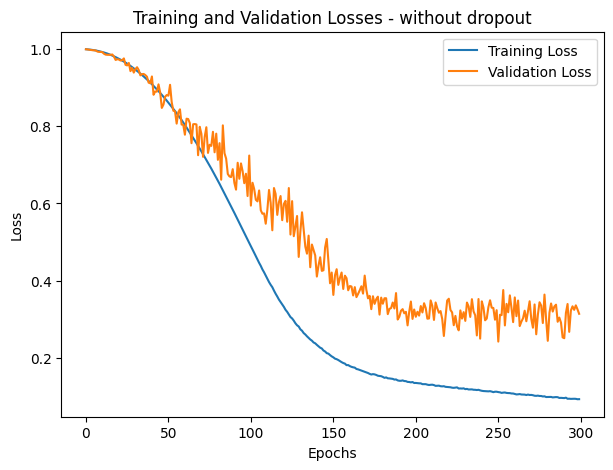

In [27]:
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses - without dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xticks(range(0, len(train_losses), 1))  # Specify tick locations every 5 epochs
plt.legend()
plt.show()

## Section-5 (b): UNet demo

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels = None, dropout_rate=0.0):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )
        
    def forward(self, x):
        return self.conv_op(x)
    
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, dropout_rate=0.0):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.dropout_rate = dropout_rate

        self.inc = (DoubleConv(n_channels, 64, dropout_rate=dropout_rate))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [17]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(n_channels = 1, n_classes = 1, dropout_rate=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model_saving_path = '/projectnb/ec500kb/projects/Project6/'

In [18]:
# training and validation

train_losses = []
val_losses = []
num_epochs = 300
train_predictions = []
val_predictions = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        img = img.unsqueeze(0)
        std_map = images['std_map'].float().to(device)
        std_map = std_map.unsqueeze(0)
        #print(img.shape)
        #print(std_map.shape)
        optimizer.zero_grad()
        y_pred = model(img)
        train_predictions.append(y_pred)
        #print(y_pred.shape)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = image['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)

            y_pred = model(img)
            val_predictions.append(y_pred)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

100%|██████████| 72/72 [00:00<00:00, 314.48it/s]


Epoch [1/300], Train Loss: 0.9997, Validation Loss: 0.9995


100%|██████████| 72/72 [00:00<00:00, 316.72it/s]


Epoch [2/300], Train Loss: 0.9994, Validation Loss: 0.9989


100%|██████████| 72/72 [00:00<00:00, 315.97it/s]


Epoch [3/300], Train Loss: 0.9989, Validation Loss: 0.9988


100%|██████████| 72/72 [00:00<00:00, 315.88it/s]


Epoch [4/300], Train Loss: 0.9984, Validation Loss: 0.9981


100%|██████████| 72/72 [00:00<00:00, 316.12it/s]


Epoch [5/300], Train Loss: 0.9979, Validation Loss: 0.9973


100%|██████████| 72/72 [00:00<00:00, 315.17it/s]


Epoch [6/300], Train Loss: 0.9972, Validation Loss: 0.9971


100%|██████████| 72/72 [00:00<00:00, 316.89it/s]


Epoch [7/300], Train Loss: 0.9965, Validation Loss: 0.9948


100%|██████████| 72/72 [00:00<00:00, 316.85it/s]


Epoch [8/300], Train Loss: 0.9956, Validation Loss: 0.9953


100%|██████████| 72/72 [00:00<00:00, 316.37it/s]


Epoch [9/300], Train Loss: 0.9946, Validation Loss: 0.9945


100%|██████████| 72/72 [00:00<00:00, 316.73it/s]


Epoch [10/300], Train Loss: 0.9936, Validation Loss: 0.9911


100%|██████████| 72/72 [00:00<00:00, 315.32it/s]


Epoch [11/300], Train Loss: 0.9926, Validation Loss: 0.9902


100%|██████████| 72/72 [00:00<00:00, 296.72it/s]


Epoch [12/300], Train Loss: 0.9914, Validation Loss: 0.9899


100%|██████████| 72/72 [00:00<00:00, 316.91it/s]


Epoch [13/300], Train Loss: 0.9902, Validation Loss: 0.9858


100%|██████████| 72/72 [00:00<00:00, 316.29it/s]


Epoch [14/300], Train Loss: 0.9890, Validation Loss: 0.9883


100%|██████████| 72/72 [00:00<00:00, 316.70it/s]


Epoch [15/300], Train Loss: 0.9876, Validation Loss: 0.9874


100%|██████████| 72/72 [00:00<00:00, 316.43it/s]


Epoch [16/300], Train Loss: 0.9862, Validation Loss: 0.9867


100%|██████████| 72/72 [00:00<00:00, 316.65it/s]


Epoch [17/300], Train Loss: 0.9847, Validation Loss: 0.9824


100%|██████████| 72/72 [00:00<00:00, 316.27it/s]


Epoch [18/300], Train Loss: 0.9831, Validation Loss: 0.9833


100%|██████████| 72/72 [00:00<00:00, 316.12it/s]


Epoch [19/300], Train Loss: 0.9815, Validation Loss: 0.9807


100%|██████████| 72/72 [00:00<00:00, 315.47it/s]


Epoch [20/300], Train Loss: 0.9798, Validation Loss: 0.9814


100%|██████████| 72/72 [00:00<00:00, 316.33it/s]


Epoch [21/300], Train Loss: 0.9781, Validation Loss: 0.9734


100%|██████████| 72/72 [00:00<00:00, 316.09it/s]


Epoch [22/300], Train Loss: 0.9762, Validation Loss: 0.9708


100%|██████████| 72/72 [00:00<00:00, 316.03it/s]


Epoch [23/300], Train Loss: 0.9743, Validation Loss: 0.9668


100%|██████████| 72/72 [00:00<00:00, 297.29it/s]


Epoch [24/300], Train Loss: 0.9723, Validation Loss: 0.9771


100%|██████████| 72/72 [00:00<00:00, 313.97it/s]


Epoch [25/300], Train Loss: 0.9703, Validation Loss: 0.9703


100%|██████████| 72/72 [00:00<00:00, 314.57it/s]


Epoch [26/300], Train Loss: 0.9681, Validation Loss: 0.9659


100%|██████████| 72/72 [00:00<00:00, 317.00it/s]


Epoch [27/300], Train Loss: 0.9659, Validation Loss: 0.9636


100%|██████████| 72/72 [00:00<00:00, 316.75it/s]


Epoch [28/300], Train Loss: 0.9636, Validation Loss: 0.9521


100%|██████████| 72/72 [00:00<00:00, 315.27it/s]


Epoch [29/300], Train Loss: 0.9613, Validation Loss: 0.9651


100%|██████████| 72/72 [00:00<00:00, 316.79it/s]


Epoch [30/300], Train Loss: 0.9588, Validation Loss: 0.9639


100%|██████████| 72/72 [00:00<00:00, 316.78it/s]


Epoch [31/300], Train Loss: 0.9563, Validation Loss: 0.9577


100%|██████████| 72/72 [00:00<00:00, 315.96it/s]


Epoch [32/300], Train Loss: 0.9537, Validation Loss: 0.9520


100%|██████████| 72/72 [00:00<00:00, 317.03it/s]


Epoch [33/300], Train Loss: 0.9510, Validation Loss: 0.9428


100%|██████████| 72/72 [00:00<00:00, 309.52it/s]


Epoch [34/300], Train Loss: 0.9481, Validation Loss: 0.9583


100%|██████████| 72/72 [00:00<00:00, 317.86it/s]


Epoch [35/300], Train Loss: 0.9452, Validation Loss: 0.9574


100%|██████████| 72/72 [00:00<00:00, 300.37it/s]


Epoch [36/300], Train Loss: 0.9422, Validation Loss: 0.9471


100%|██████████| 72/72 [00:00<00:00, 317.52it/s]


Epoch [37/300], Train Loss: 0.9391, Validation Loss: 0.9407


100%|██████████| 72/72 [00:00<00:00, 317.46it/s]


Epoch [38/300], Train Loss: 0.9359, Validation Loss: 0.9313


100%|██████████| 72/72 [00:00<00:00, 317.26it/s]


Epoch [39/300], Train Loss: 0.9325, Validation Loss: 0.9196


100%|██████████| 72/72 [00:00<00:00, 317.31it/s]


Epoch [40/300], Train Loss: 0.9291, Validation Loss: 0.9293


100%|██████████| 72/72 [00:00<00:00, 317.40it/s]


Epoch [41/300], Train Loss: 0.9257, Validation Loss: 0.9091


100%|██████████| 72/72 [00:00<00:00, 317.62it/s]


Epoch [42/300], Train Loss: 0.9221, Validation Loss: 0.9283


100%|██████████| 72/72 [00:00<00:00, 317.82it/s]


Epoch [43/300], Train Loss: 0.9183, Validation Loss: 0.9012


100%|██████████| 72/72 [00:00<00:00, 318.06it/s]


Epoch [44/300], Train Loss: 0.9146, Validation Loss: 0.9165


100%|██████████| 72/72 [00:00<00:00, 318.18it/s]


Epoch [45/300], Train Loss: 0.9107, Validation Loss: 0.9197


100%|██████████| 72/72 [00:00<00:00, 316.22it/s]


Epoch [46/300], Train Loss: 0.9068, Validation Loss: 0.8900


100%|██████████| 72/72 [00:00<00:00, 317.42it/s]


Epoch [47/300], Train Loss: 0.9026, Validation Loss: 0.9099


100%|██████████| 72/72 [00:00<00:00, 297.57it/s]


Epoch [48/300], Train Loss: 0.8985, Validation Loss: 0.9032


100%|██████████| 72/72 [00:00<00:00, 315.41it/s]


Epoch [49/300], Train Loss: 0.8941, Validation Loss: 0.8733


100%|██████████| 72/72 [00:00<00:00, 315.46it/s]


Epoch [50/300], Train Loss: 0.8898, Validation Loss: 0.9018


100%|██████████| 72/72 [00:00<00:00, 315.64it/s]


Epoch [51/300], Train Loss: 0.8852, Validation Loss: 0.8830


100%|██████████| 72/72 [00:00<00:00, 315.65it/s]


Epoch [52/300], Train Loss: 0.8808, Validation Loss: 0.8889


100%|██████████| 72/72 [00:00<00:00, 316.21it/s]


Epoch [53/300], Train Loss: 0.8760, Validation Loss: 0.8755


100%|██████████| 72/72 [00:00<00:00, 316.02it/s]


Epoch [54/300], Train Loss: 0.8712, Validation Loss: 0.9083


100%|██████████| 72/72 [00:00<00:00, 316.19it/s]


Epoch [55/300], Train Loss: 0.8665, Validation Loss: 0.8446


100%|██████████| 72/72 [00:00<00:00, 315.99it/s]


Epoch [56/300], Train Loss: 0.8607, Validation Loss: 0.8547


100%|██████████| 72/72 [00:00<00:00, 315.94it/s]


Epoch [57/300], Train Loss: 0.8551, Validation Loss: 0.8240


100%|██████████| 72/72 [00:00<00:00, 316.14it/s]


Epoch [58/300], Train Loss: 0.8499, Validation Loss: 0.8550


100%|██████████| 72/72 [00:00<00:00, 316.45it/s]


Epoch [59/300], Train Loss: 0.8446, Validation Loss: 0.8079


100%|██████████| 72/72 [00:00<00:00, 295.48it/s]


Epoch [60/300], Train Loss: 0.8389, Validation Loss: 0.8458


100%|██████████| 72/72 [00:00<00:00, 317.40it/s]


Epoch [61/300], Train Loss: 0.8335, Validation Loss: 0.8092


100%|██████████| 72/72 [00:00<00:00, 318.26it/s]


Epoch [62/300], Train Loss: 0.8279, Validation Loss: 0.8303


100%|██████████| 72/72 [00:00<00:00, 298.43it/s]


Epoch [63/300], Train Loss: 0.8221, Validation Loss: 0.8305


100%|██████████| 72/72 [00:00<00:00, 298.22it/s]


Epoch [64/300], Train Loss: 0.8165, Validation Loss: 0.8277


100%|██████████| 72/72 [00:00<00:00, 297.95it/s]


Epoch [65/300], Train Loss: 0.8104, Validation Loss: 0.8154


100%|██████████| 72/72 [00:00<00:00, 298.30it/s]


Epoch [66/300], Train Loss: 0.8044, Validation Loss: 0.8507


100%|██████████| 72/72 [00:00<00:00, 298.00it/s]


Epoch [67/300], Train Loss: 0.7984, Validation Loss: 0.8254


100%|██████████| 72/72 [00:00<00:00, 298.02it/s]


Epoch [68/300], Train Loss: 0.7922, Validation Loss: 0.7871


100%|██████████| 72/72 [00:00<00:00, 298.61it/s]


Epoch [69/300], Train Loss: 0.7858, Validation Loss: 0.7909


100%|██████████| 72/72 [00:00<00:00, 298.19it/s]


Epoch [70/300], Train Loss: 0.7794, Validation Loss: 0.7854


100%|██████████| 72/72 [00:00<00:00, 297.20it/s]


Epoch [71/300], Train Loss: 0.7727, Validation Loss: 0.8284


100%|██████████| 72/72 [00:00<00:00, 279.38it/s]


Epoch [72/300], Train Loss: 0.7663, Validation Loss: 0.8419


100%|██████████| 72/72 [00:00<00:00, 297.97it/s]


Epoch [73/300], Train Loss: 0.7596, Validation Loss: 0.7500


100%|██████████| 72/72 [00:00<00:00, 298.39it/s]


Epoch [74/300], Train Loss: 0.7528, Validation Loss: 0.8105


100%|██████████| 72/72 [00:00<00:00, 298.29it/s]


Epoch [75/300], Train Loss: 0.7459, Validation Loss: 0.7551


100%|██████████| 72/72 [00:00<00:00, 297.99it/s]


Epoch [76/300], Train Loss: 0.7389, Validation Loss: 0.8002


100%|██████████| 72/72 [00:00<00:00, 298.49it/s]


Epoch [77/300], Train Loss: 0.7318, Validation Loss: 0.7700


100%|██████████| 72/72 [00:00<00:00, 298.71it/s]


Epoch [78/300], Train Loss: 0.7248, Validation Loss: 0.7161


100%|██████████| 72/72 [00:00<00:00, 298.05it/s]


Epoch [79/300], Train Loss: 0.7174, Validation Loss: 0.8101


100%|██████████| 72/72 [00:00<00:00, 298.32it/s]


Epoch [80/300], Train Loss: 0.7103, Validation Loss: 0.8333


100%|██████████| 72/72 [00:00<00:00, 298.27it/s]


Epoch [81/300], Train Loss: 0.7026, Validation Loss: 0.7526


100%|██████████| 72/72 [00:00<00:00, 298.41it/s]


Epoch [82/300], Train Loss: 0.6951, Validation Loss: 0.8046


100%|██████████| 72/72 [00:00<00:00, 298.06it/s]


Epoch [83/300], Train Loss: 0.6875, Validation Loss: 0.6812


100%|██████████| 72/72 [00:00<00:00, 279.55it/s]


Epoch [84/300], Train Loss: 0.6799, Validation Loss: 0.6818


100%|██████████| 72/72 [00:00<00:00, 298.40it/s]


Epoch [85/300], Train Loss: 0.6726, Validation Loss: 0.7623


100%|██████████| 72/72 [00:00<00:00, 298.85it/s]


Epoch [86/300], Train Loss: 0.6645, Validation Loss: 0.7185


100%|██████████| 72/72 [00:00<00:00, 298.26it/s]


Epoch [87/300], Train Loss: 0.6567, Validation Loss: 0.6800


100%|██████████| 72/72 [00:00<00:00, 297.97it/s]


Epoch [88/300], Train Loss: 0.6487, Validation Loss: 0.7376


100%|██████████| 72/72 [00:00<00:00, 298.35it/s]


Epoch [89/300], Train Loss: 0.6406, Validation Loss: 0.7246


100%|██████████| 72/72 [00:00<00:00, 298.34it/s]


Epoch [90/300], Train Loss: 0.6324, Validation Loss: 0.7536


100%|██████████| 72/72 [00:00<00:00, 298.57it/s]


Epoch [91/300], Train Loss: 0.6244, Validation Loss: 0.7012


100%|██████████| 72/72 [00:00<00:00, 298.39it/s]


Epoch [92/300], Train Loss: 0.6161, Validation Loss: 0.6645


100%|██████████| 72/72 [00:00<00:00, 296.01it/s]


Epoch [93/300], Train Loss: 0.6078, Validation Loss: 0.7419


100%|██████████| 72/72 [00:00<00:00, 298.20it/s]


Epoch [94/300], Train Loss: 0.6000, Validation Loss: 0.6555


100%|██████████| 72/72 [00:00<00:00, 298.43it/s]


Epoch [95/300], Train Loss: 0.5916, Validation Loss: 0.7210


100%|██████████| 72/72 [00:00<00:00, 279.58it/s]


Epoch [96/300], Train Loss: 0.5833, Validation Loss: 0.6309


100%|██████████| 72/72 [00:00<00:00, 298.61it/s]


Epoch [97/300], Train Loss: 0.5748, Validation Loss: 0.6808


100%|██████████| 72/72 [00:00<00:00, 298.35it/s]


Epoch [98/300], Train Loss: 0.5664, Validation Loss: 0.6425


100%|██████████| 72/72 [00:00<00:00, 298.41it/s]


Epoch [99/300], Train Loss: 0.5578, Validation Loss: 0.6438


100%|██████████| 72/72 [00:00<00:00, 297.04it/s]


Epoch [100/300], Train Loss: 0.5496, Validation Loss: 0.7067


100%|██████████| 72/72 [00:00<00:00, 298.33it/s]


Epoch [101/300], Train Loss: 0.5413, Validation Loss: 0.6380


100%|██████████| 72/72 [00:00<00:00, 297.89it/s]


Epoch [102/300], Train Loss: 0.5327, Validation Loss: 0.5939


100%|██████████| 72/72 [00:00<00:00, 297.49it/s]


Epoch [103/300], Train Loss: 0.5243, Validation Loss: 0.5922


100%|██████████| 72/72 [00:00<00:00, 298.27it/s]


Epoch [104/300], Train Loss: 0.5153, Validation Loss: 0.5915


100%|██████████| 72/72 [00:00<00:00, 298.47it/s]


Epoch [105/300], Train Loss: 0.5080, Validation Loss: 0.6200


100%|██████████| 72/72 [00:00<00:00, 297.94it/s]


Epoch [106/300], Train Loss: 0.4995, Validation Loss: 0.6685


100%|██████████| 72/72 [00:00<00:00, 298.27it/s]


Epoch [107/300], Train Loss: 0.4906, Validation Loss: 0.6157


100%|██████████| 72/72 [00:00<00:00, 284.33it/s]


Epoch [108/300], Train Loss: 0.4826, Validation Loss: 0.6716


100%|██████████| 72/72 [00:00<00:00, 298.38it/s]


Epoch [109/300], Train Loss: 0.4743, Validation Loss: 0.6144


100%|██████████| 72/72 [00:00<00:00, 298.11it/s]


Epoch [110/300], Train Loss: 0.4661, Validation Loss: 0.5306


100%|██████████| 72/72 [00:00<00:00, 297.33it/s]


Epoch [111/300], Train Loss: 0.4587, Validation Loss: 0.6629


100%|██████████| 72/72 [00:00<00:00, 298.69it/s]


Epoch [112/300], Train Loss: 0.4498, Validation Loss: 0.5878


100%|██████████| 72/72 [00:00<00:00, 298.28it/s]


Epoch [113/300], Train Loss: 0.4422, Validation Loss: 0.6059


100%|██████████| 72/72 [00:00<00:00, 298.00it/s]


Epoch [114/300], Train Loss: 0.4345, Validation Loss: 0.5735


100%|██████████| 72/72 [00:00<00:00, 298.17it/s]


Epoch [115/300], Train Loss: 0.4272, Validation Loss: 0.5784


100%|██████████| 72/72 [00:00<00:00, 298.64it/s]


Epoch [116/300], Train Loss: 0.4202, Validation Loss: 0.5772


100%|██████████| 72/72 [00:00<00:00, 298.39it/s]


Epoch [117/300], Train Loss: 0.4122, Validation Loss: 0.6331


100%|██████████| 72/72 [00:00<00:00, 298.35it/s]


Epoch [118/300], Train Loss: 0.4046, Validation Loss: 0.6024


100%|██████████| 72/72 [00:00<00:00, 298.49it/s]


Epoch [119/300], Train Loss: 0.3981, Validation Loss: 0.5512


100%|██████████| 72/72 [00:00<00:00, 286.55it/s]


Epoch [120/300], Train Loss: 0.3907, Validation Loss: 0.5311


100%|██████████| 72/72 [00:00<00:00, 298.47it/s]


Epoch [121/300], Train Loss: 0.3833, Validation Loss: 0.5367


100%|██████████| 72/72 [00:00<00:00, 297.87it/s]


Epoch [122/300], Train Loss: 0.3766, Validation Loss: 0.5833


100%|██████████| 72/72 [00:00<00:00, 298.53it/s]


Epoch [123/300], Train Loss: 0.3696, Validation Loss: 0.5951


100%|██████████| 72/72 [00:00<00:00, 298.51it/s]


Epoch [124/300], Train Loss: 0.3618, Validation Loss: 0.5705


100%|██████████| 72/72 [00:00<00:00, 298.27it/s]


Epoch [125/300], Train Loss: 0.3550, Validation Loss: 0.6039


100%|██████████| 72/72 [00:00<00:00, 298.29it/s]


Epoch [126/300], Train Loss: 0.3478, Validation Loss: 0.5574


100%|██████████| 72/72 [00:00<00:00, 298.23it/s]


Epoch [127/300], Train Loss: 0.3416, Validation Loss: 0.5030


100%|██████████| 72/72 [00:00<00:00, 298.20it/s]


Epoch [128/300], Train Loss: 0.3347, Validation Loss: 0.4655


100%|██████████| 72/72 [00:00<00:00, 298.15it/s]


Epoch [129/300], Train Loss: 0.3290, Validation Loss: 0.5245


100%|██████████| 72/72 [00:00<00:00, 298.41it/s]


Epoch [130/300], Train Loss: 0.3223, Validation Loss: 0.4999


100%|██████████| 72/72 [00:00<00:00, 298.29it/s]


Epoch [131/300], Train Loss: 0.3172, Validation Loss: 0.5043


100%|██████████| 72/72 [00:00<00:00, 279.01it/s]


Epoch [132/300], Train Loss: 0.3119, Validation Loss: 0.4682


100%|██████████| 72/72 [00:00<00:00, 298.16it/s]


Epoch [133/300], Train Loss: 0.3057, Validation Loss: 0.4628


100%|██████████| 72/72 [00:00<00:00, 298.22it/s]


Epoch [134/300], Train Loss: 0.3014, Validation Loss: 0.5062


100%|██████████| 72/72 [00:00<00:00, 298.67it/s]


Epoch [135/300], Train Loss: 0.2956, Validation Loss: 0.4899


100%|██████████| 72/72 [00:00<00:00, 298.22it/s]


Epoch [136/300], Train Loss: 0.2900, Validation Loss: 0.5127


100%|██████████| 72/72 [00:00<00:00, 298.32it/s]


Epoch [137/300], Train Loss: 0.2847, Validation Loss: 0.5130


100%|██████████| 72/72 [00:00<00:00, 298.19it/s]


Epoch [138/300], Train Loss: 0.2802, Validation Loss: 0.4431


100%|██████████| 72/72 [00:00<00:00, 298.13it/s]


Epoch [139/300], Train Loss: 0.2767, Validation Loss: 0.4418


100%|██████████| 72/72 [00:00<00:00, 297.96it/s]


Epoch [140/300], Train Loss: 0.2720, Validation Loss: 0.4301


100%|██████████| 72/72 [00:00<00:00, 298.35it/s]


Epoch [141/300], Train Loss: 0.2674, Validation Loss: 0.4399


100%|██████████| 72/72 [00:00<00:00, 298.04it/s]


Epoch [142/300], Train Loss: 0.2645, Validation Loss: 0.4439


100%|██████████| 72/72 [00:00<00:00, 298.66it/s]


Epoch [143/300], Train Loss: 0.2598, Validation Loss: 0.4818


100%|██████████| 72/72 [00:00<00:00, 282.99it/s]


Epoch [144/300], Train Loss: 0.2557, Validation Loss: 0.4167


100%|██████████| 72/72 [00:00<00:00, 298.31it/s]


Epoch [145/300], Train Loss: 0.2515, Validation Loss: 0.4879


100%|██████████| 72/72 [00:00<00:00, 298.43it/s]


Epoch [146/300], Train Loss: 0.2485, Validation Loss: 0.3837


100%|██████████| 72/72 [00:00<00:00, 298.45it/s]


Epoch [147/300], Train Loss: 0.2460, Validation Loss: 0.4600


100%|██████████| 72/72 [00:00<00:00, 298.00it/s]


Epoch [148/300], Train Loss: 0.2429, Validation Loss: 0.4289


100%|██████████| 72/72 [00:00<00:00, 298.14it/s]


Epoch [149/300], Train Loss: 0.2399, Validation Loss: 0.4171


100%|██████████| 72/72 [00:00<00:00, 298.08it/s]


Epoch [150/300], Train Loss: 0.2362, Validation Loss: 0.4389


100%|██████████| 72/72 [00:00<00:00, 298.32it/s]


Epoch [151/300], Train Loss: 0.2329, Validation Loss: 0.3858


100%|██████████| 72/72 [00:00<00:00, 298.35it/s]


Epoch [152/300], Train Loss: 0.2302, Validation Loss: 0.4064


100%|██████████| 72/72 [00:00<00:00, 298.13it/s]


Epoch [153/300], Train Loss: 0.2281, Validation Loss: 0.3709


100%|██████████| 72/72 [00:00<00:00, 298.42it/s]


Epoch [154/300], Train Loss: 0.2259, Validation Loss: 0.3680


100%|██████████| 72/72 [00:00<00:00, 297.57it/s]


Epoch [155/300], Train Loss: 0.2229, Validation Loss: 0.4177


100%|██████████| 72/72 [00:00<00:00, 279.20it/s]


Epoch [156/300], Train Loss: 0.2190, Validation Loss: 0.4701


100%|██████████| 72/72 [00:00<00:00, 298.14it/s]


Epoch [157/300], Train Loss: 0.2163, Validation Loss: 0.4832


100%|██████████| 72/72 [00:00<00:00, 298.49it/s]


Epoch [158/300], Train Loss: 0.2144, Validation Loss: 0.3679


100%|██████████| 72/72 [00:00<00:00, 298.27it/s]


Epoch [159/300], Train Loss: 0.2127, Validation Loss: 0.4080


100%|██████████| 72/72 [00:00<00:00, 298.37it/s]


Epoch [160/300], Train Loss: 0.2108, Validation Loss: 0.4052


100%|██████████| 72/72 [00:00<00:00, 298.38it/s]


Epoch [161/300], Train Loss: 0.2059, Validation Loss: 0.4362


100%|██████████| 72/72 [00:00<00:00, 298.46it/s]


Epoch [162/300], Train Loss: 0.2038, Validation Loss: 0.3884


100%|██████████| 72/72 [00:00<00:00, 297.24it/s]


Epoch [163/300], Train Loss: 0.1989, Validation Loss: 0.3617


100%|██████████| 72/72 [00:00<00:00, 298.22it/s]


Epoch [164/300], Train Loss: 0.1976, Validation Loss: 0.3686


100%|██████████| 72/72 [00:00<00:00, 298.64it/s]


Epoch [165/300], Train Loss: 0.1956, Validation Loss: 0.3986


100%|██████████| 72/72 [00:00<00:00, 298.44it/s]


Epoch [166/300], Train Loss: 0.1936, Validation Loss: 0.3825


100%|██████████| 72/72 [00:00<00:00, 298.98it/s]


Epoch [167/300], Train Loss: 0.1905, Validation Loss: 0.3679


100%|██████████| 72/72 [00:00<00:00, 283.99it/s]


Epoch [168/300], Train Loss: 0.1894, Validation Loss: 0.3876


100%|██████████| 72/72 [00:00<00:00, 298.19it/s]


Epoch [169/300], Train Loss: 0.1861, Validation Loss: 0.3794


100%|██████████| 72/72 [00:00<00:00, 316.08it/s]


Epoch [170/300], Train Loss: 0.1853, Validation Loss: 0.3837


100%|██████████| 72/72 [00:00<00:00, 316.12it/s]


Epoch [171/300], Train Loss: 0.1839, Validation Loss: 0.3764


100%|██████████| 72/72 [00:00<00:00, 316.15it/s]


Epoch [172/300], Train Loss: 0.1814, Validation Loss: 0.3719


100%|██████████| 72/72 [00:00<00:00, 315.76it/s]


Epoch [173/300], Train Loss: 0.1789, Validation Loss: 0.3702


100%|██████████| 72/72 [00:00<00:00, 316.04it/s]


Epoch [174/300], Train Loss: 0.1779, Validation Loss: 0.3258


100%|██████████| 72/72 [00:00<00:00, 316.33it/s]


Epoch [175/300], Train Loss: 0.1761, Validation Loss: 0.3545


100%|██████████| 72/72 [00:00<00:00, 316.04it/s]


Epoch [176/300], Train Loss: 0.1729, Validation Loss: 0.3358


100%|██████████| 72/72 [00:00<00:00, 315.74it/s]


Epoch [177/300], Train Loss: 0.1725, Validation Loss: 0.3355


100%|██████████| 72/72 [00:00<00:00, 316.03it/s]


Epoch [178/300], Train Loss: 0.1709, Validation Loss: 0.3985


100%|██████████| 72/72 [00:00<00:00, 316.03it/s]


Epoch [179/300], Train Loss: 0.1682, Validation Loss: 0.4076


100%|██████████| 72/72 [00:00<00:00, 296.80it/s]


Epoch [180/300], Train Loss: 0.1674, Validation Loss: 0.3591


100%|██████████| 72/72 [00:00<00:00, 105.88it/s]


Epoch [181/300], Train Loss: 0.1652, Validation Loss: 0.3603


100%|██████████| 72/72 [00:00<00:00, 316.20it/s]


Epoch [182/300], Train Loss: 0.1653, Validation Loss: 0.3558


100%|██████████| 72/72 [00:00<00:00, 316.14it/s]


Epoch [183/300], Train Loss: 0.1629, Validation Loss: 0.3666


100%|██████████| 72/72 [00:00<00:00, 315.81it/s]


Epoch [184/300], Train Loss: 0.1622, Validation Loss: 0.3547


100%|██████████| 72/72 [00:00<00:00, 315.95it/s]


Epoch [185/300], Train Loss: 0.1613, Validation Loss: 0.3518


100%|██████████| 72/72 [00:00<00:00, 316.62it/s]


Epoch [186/300], Train Loss: 0.1609, Validation Loss: 0.3286


100%|██████████| 72/72 [00:00<00:00, 315.63it/s]


Epoch [187/300], Train Loss: 0.1585, Validation Loss: 0.3498


100%|██████████| 72/72 [00:00<00:00, 316.28it/s]


Epoch [188/300], Train Loss: 0.1567, Validation Loss: 0.3913


100%|██████████| 72/72 [00:00<00:00, 315.98it/s]


Epoch [189/300], Train Loss: 0.1563, Validation Loss: 0.3574


100%|██████████| 72/72 [00:00<00:00, 316.05it/s]


Epoch [190/300], Train Loss: 0.1550, Validation Loss: 0.3506


100%|██████████| 72/72 [00:00<00:00, 315.76it/s]


Epoch [191/300], Train Loss: 0.1547, Validation Loss: 0.3270


100%|██████████| 72/72 [00:00<00:00, 302.30it/s]


Epoch [192/300], Train Loss: 0.1526, Validation Loss: 0.3684


100%|██████████| 72/72 [00:00<00:00, 316.00it/s]


Epoch [193/300], Train Loss: 0.1525, Validation Loss: 0.3778


100%|██████████| 72/72 [00:00<00:00, 315.91it/s]


Epoch [194/300], Train Loss: 0.1512, Validation Loss: 0.3386


100%|██████████| 72/72 [00:00<00:00, 315.89it/s]


Epoch [195/300], Train Loss: 0.1510, Validation Loss: 0.3449


100%|██████████| 72/72 [00:00<00:00, 315.84it/s]


Epoch [196/300], Train Loss: 0.1501, Validation Loss: 0.3262


100%|██████████| 72/72 [00:00<00:00, 316.35it/s]


Epoch [197/300], Train Loss: 0.1474, Validation Loss: 0.3584


100%|██████████| 72/72 [00:00<00:00, 315.78it/s]


Epoch [198/300], Train Loss: 0.1480, Validation Loss: 0.3660


100%|██████████| 72/72 [00:00<00:00, 316.10it/s]


Epoch [199/300], Train Loss: 0.1466, Validation Loss: 0.3632


100%|██████████| 72/72 [00:00<00:00, 315.84it/s]


Epoch [200/300], Train Loss: 0.1472, Validation Loss: 0.3109


100%|██████████| 72/72 [00:00<00:00, 316.05it/s]


Epoch [201/300], Train Loss: 0.1451, Validation Loss: 0.3364


100%|██████████| 72/72 [00:00<00:00, 315.99it/s]


Epoch [202/300], Train Loss: 0.1445, Validation Loss: 0.2902


100%|██████████| 72/72 [00:00<00:00, 315.85it/s]


Epoch [203/300], Train Loss: 0.1432, Validation Loss: 0.3223


100%|██████████| 72/72 [00:00<00:00, 294.49it/s]


Epoch [204/300], Train Loss: 0.1421, Validation Loss: 0.3382


100%|██████████| 72/72 [00:00<00:00, 315.97it/s]


Epoch [205/300], Train Loss: 0.1426, Validation Loss: 0.3295


100%|██████████| 72/72 [00:00<00:00, 316.11it/s]


Epoch [206/300], Train Loss: 0.1421, Validation Loss: 0.3966


100%|██████████| 72/72 [00:00<00:00, 315.94it/s]


Epoch [207/300], Train Loss: 0.1420, Validation Loss: 0.4027


100%|██████████| 72/72 [00:00<00:00, 314.52it/s]


Epoch [208/300], Train Loss: 0.1400, Validation Loss: 0.3381


100%|██████████| 72/72 [00:00<00:00, 315.78it/s]


Epoch [209/300], Train Loss: 0.1399, Validation Loss: 0.3334


100%|██████████| 72/72 [00:00<00:00, 314.79it/s]


Epoch [210/300], Train Loss: 0.1387, Validation Loss: 0.3572


100%|██████████| 72/72 [00:00<00:00, 315.65it/s]


Epoch [211/300], Train Loss: 0.1384, Validation Loss: 0.3474


100%|██████████| 72/72 [00:00<00:00, 316.03it/s]


Epoch [212/300], Train Loss: 0.1400, Validation Loss: 0.3385


100%|██████████| 72/72 [00:00<00:00, 315.75it/s]


Epoch [213/300], Train Loss: 0.1366, Validation Loss: 0.3250


100%|██████████| 72/72 [00:00<00:00, 314.18it/s]


Epoch [214/300], Train Loss: 0.1360, Validation Loss: 0.3578


100%|██████████| 72/72 [00:00<00:00, 315.73it/s]


Epoch [215/300], Train Loss: 0.1352, Validation Loss: 0.3485


100%|██████████| 72/72 [00:00<00:00, 295.29it/s]


Epoch [216/300], Train Loss: 0.1363, Validation Loss: 0.3371


100%|██████████| 72/72 [00:00<00:00, 315.69it/s]


Epoch [217/300], Train Loss: 0.1355, Validation Loss: 0.3235


100%|██████████| 72/72 [00:00<00:00, 315.39it/s]


Epoch [218/300], Train Loss: 0.1345, Validation Loss: 0.3468


100%|██████████| 72/72 [00:00<00:00, 315.20it/s]


Epoch [219/300], Train Loss: 0.1341, Validation Loss: 0.3029


100%|██████████| 72/72 [00:00<00:00, 315.64it/s]


Epoch [220/300], Train Loss: 0.1341, Validation Loss: 0.3160


100%|██████████| 72/72 [00:00<00:00, 316.17it/s]


Epoch [221/300], Train Loss: 0.1329, Validation Loss: 0.3499


100%|██████████| 72/72 [00:00<00:00, 315.70it/s]


Epoch [222/300], Train Loss: 0.1319, Validation Loss: 0.3002


100%|██████████| 72/72 [00:00<00:00, 315.98it/s]


Epoch [223/300], Train Loss: 0.1322, Validation Loss: 0.3347


100%|██████████| 72/72 [00:00<00:00, 315.61it/s]


Epoch [224/300], Train Loss: 0.1312, Validation Loss: 0.3491


100%|██████████| 72/72 [00:00<00:00, 315.39it/s]


Epoch [225/300], Train Loss: 0.1312, Validation Loss: 0.3307


100%|██████████| 72/72 [00:00<00:00, 315.57it/s]


Epoch [226/300], Train Loss: 0.1298, Validation Loss: 0.3557


100%|██████████| 72/72 [00:00<00:00, 315.71it/s]


Epoch [227/300], Train Loss: 0.1297, Validation Loss: 0.3200


100%|██████████| 72/72 [00:00<00:00, 297.07it/s]


Epoch [228/300], Train Loss: 0.1297, Validation Loss: 0.3096


100%|██████████| 72/72 [00:00<00:00, 316.06it/s]


Epoch [229/300], Train Loss: 0.1285, Validation Loss: 0.3279


100%|██████████| 72/72 [00:00<00:00, 313.38it/s]


Epoch [230/300], Train Loss: 0.1287, Validation Loss: 0.3032


100%|██████████| 72/72 [00:00<00:00, 315.86it/s]


Epoch [231/300], Train Loss: 0.1286, Validation Loss: 0.2984


100%|██████████| 72/72 [00:00<00:00, 315.99it/s]


Epoch [232/300], Train Loss: 0.1275, Validation Loss: 0.3164


100%|██████████| 72/72 [00:00<00:00, 316.19it/s]


Epoch [233/300], Train Loss: 0.1262, Validation Loss: 0.3124


100%|██████████| 72/72 [00:00<00:00, 316.12it/s]


Epoch [234/300], Train Loss: 0.1262, Validation Loss: 0.3280


100%|██████████| 72/72 [00:00<00:00, 316.03it/s]


Epoch [235/300], Train Loss: 0.1273, Validation Loss: 0.3060


100%|██████████| 72/72 [00:00<00:00, 315.47it/s]


Epoch [236/300], Train Loss: 0.1262, Validation Loss: 0.3401


100%|██████████| 72/72 [00:00<00:00, 315.97it/s]


Epoch [237/300], Train Loss: 0.1248, Validation Loss: 0.3296


100%|██████████| 72/72 [00:00<00:00, 315.88it/s]


Epoch [238/300], Train Loss: 0.1240, Validation Loss: 0.3121


100%|██████████| 72/72 [00:00<00:00, 315.68it/s]


Epoch [239/300], Train Loss: 0.1235, Validation Loss: 0.3209


100%|██████████| 72/72 [00:00<00:00, 298.32it/s]


Epoch [240/300], Train Loss: 0.1232, Validation Loss: 0.2907


100%|██████████| 72/72 [00:00<00:00, 314.76it/s]


Epoch [241/300], Train Loss: 0.1225, Validation Loss: 0.3335


100%|██████████| 72/72 [00:00<00:00, 315.76it/s]


Epoch [242/300], Train Loss: 0.1226, Validation Loss: 0.3360


100%|██████████| 72/72 [00:00<00:00, 316.37it/s]


Epoch [243/300], Train Loss: 0.1232, Validation Loss: 0.3256


100%|██████████| 72/72 [00:00<00:00, 315.99it/s]


Epoch [244/300], Train Loss: 0.1215, Validation Loss: 0.3338


100%|██████████| 72/72 [00:00<00:00, 315.79it/s]


Epoch [245/300], Train Loss: 0.1213, Validation Loss: 0.3104


100%|██████████| 72/72 [00:00<00:00, 316.14it/s]


Epoch [246/300], Train Loss: 0.1202, Validation Loss: 0.3632


100%|██████████| 72/72 [00:00<00:00, 315.12it/s]


Epoch [247/300], Train Loss: 0.1200, Validation Loss: 0.3549


100%|██████████| 72/72 [00:00<00:00, 316.37it/s]


Epoch [248/300], Train Loss: 0.1211, Validation Loss: 0.3548


100%|██████████| 72/72 [00:00<00:00, 316.11it/s]


Epoch [249/300], Train Loss: 0.1201, Validation Loss: 0.3395


100%|██████████| 72/72 [00:00<00:00, 315.95it/s]


Epoch [250/300], Train Loss: 0.1203, Validation Loss: 0.3437


100%|██████████| 72/72 [00:00<00:00, 316.21it/s]


Epoch [251/300], Train Loss: 0.1197, Validation Loss: 0.3147


100%|██████████| 72/72 [00:00<00:00, 299.84it/s]


Epoch [252/300], Train Loss: 0.1190, Validation Loss: 0.3318


100%|██████████| 72/72 [00:00<00:00, 315.11it/s]


Epoch [253/300], Train Loss: 0.1174, Validation Loss: 0.3237


100%|██████████| 72/72 [00:00<00:00, 315.90it/s]


Epoch [254/300], Train Loss: 0.1168, Validation Loss: 0.3238


100%|██████████| 72/72 [00:00<00:00, 316.31it/s]


Epoch [255/300], Train Loss: 0.1177, Validation Loss: 0.3608


100%|██████████| 72/72 [00:00<00:00, 315.49it/s]


Epoch [256/300], Train Loss: 0.1174, Validation Loss: 0.3585


100%|██████████| 72/72 [00:00<00:00, 315.54it/s]


Epoch [257/300], Train Loss: 0.1169, Validation Loss: 0.3317


100%|██████████| 72/72 [00:00<00:00, 315.84it/s]


Epoch [258/300], Train Loss: 0.1168, Validation Loss: 0.3697


100%|██████████| 72/72 [00:00<00:00, 315.99it/s]


Epoch [259/300], Train Loss: 0.1154, Validation Loss: 0.3666


100%|██████████| 72/72 [00:00<00:00, 315.79it/s]


Epoch [260/300], Train Loss: 0.1152, Validation Loss: 0.3462


100%|██████████| 72/72 [00:00<00:00, 315.91it/s]


Epoch [261/300], Train Loss: 0.1141, Validation Loss: 0.3251


100%|██████████| 72/72 [00:00<00:00, 315.86it/s]


Epoch [262/300], Train Loss: 0.1143, Validation Loss: 0.3029


100%|██████████| 72/72 [00:00<00:00, 315.87it/s]


Epoch [263/300], Train Loss: 0.1139, Validation Loss: 0.3840


100%|██████████| 72/72 [00:00<00:00, 298.74it/s]


Epoch [264/300], Train Loss: 0.1141, Validation Loss: 0.3749


100%|██████████| 72/72 [00:00<00:00, 314.45it/s]


Epoch [265/300], Train Loss: 0.1133, Validation Loss: 0.3365


100%|██████████| 72/72 [00:00<00:00, 314.49it/s]


Epoch [266/300], Train Loss: 0.1127, Validation Loss: 0.3489


100%|██████████| 72/72 [00:00<00:00, 315.95it/s]


Epoch [267/300], Train Loss: 0.1116, Validation Loss: 0.3095


100%|██████████| 72/72 [00:00<00:00, 315.62it/s]


Epoch [268/300], Train Loss: 0.1113, Validation Loss: 0.3310


100%|██████████| 72/72 [00:00<00:00, 316.29it/s]


Epoch [269/300], Train Loss: 0.1116, Validation Loss: 0.3330


100%|██████████| 72/72 [00:00<00:00, 316.29it/s]


Epoch [270/300], Train Loss: 0.1107, Validation Loss: 0.3197


100%|██████████| 72/72 [00:00<00:00, 314.42it/s]


Epoch [271/300], Train Loss: 0.1111, Validation Loss: 0.3320


100%|██████████| 72/72 [00:00<00:00, 315.62it/s]


Epoch [272/300], Train Loss: 0.1104, Validation Loss: 0.3226


100%|██████████| 72/72 [00:00<00:00, 316.24it/s]


Epoch [273/300], Train Loss: 0.1108, Validation Loss: 0.3638


100%|██████████| 72/72 [00:00<00:00, 315.86it/s]


Epoch [274/300], Train Loss: 0.1098, Validation Loss: 0.3343


100%|██████████| 72/72 [00:00<00:00, 316.28it/s]


Epoch [275/300], Train Loss: 0.1091, Validation Loss: 0.3038


100%|██████████| 72/72 [00:00<00:00, 298.51it/s]


Epoch [276/300], Train Loss: 0.1096, Validation Loss: 0.3298


100%|██████████| 72/72 [00:00<00:00, 314.82it/s]


Epoch [277/300], Train Loss: 0.1086, Validation Loss: 0.2989


100%|██████████| 72/72 [00:00<00:00, 316.09it/s]


Epoch [278/300], Train Loss: 0.1085, Validation Loss: 0.3232


100%|██████████| 72/72 [00:00<00:00, 316.05it/s]


Epoch [279/300], Train Loss: 0.1069, Validation Loss: 0.3102


100%|██████████| 72/72 [00:00<00:00, 315.98it/s]


Epoch [280/300], Train Loss: 0.1077, Validation Loss: 0.3147


100%|██████████| 72/72 [00:00<00:00, 315.74it/s]


Epoch [281/300], Train Loss: 0.1072, Validation Loss: 0.3388


100%|██████████| 72/72 [00:00<00:00, 316.03it/s]


Epoch [282/300], Train Loss: 0.1073, Validation Loss: 0.3337


100%|██████████| 72/72 [00:00<00:00, 314.75it/s]


Epoch [283/300], Train Loss: 0.1058, Validation Loss: 0.3303


100%|██████████| 72/72 [00:00<00:00, 315.96it/s]


Epoch [284/300], Train Loss: 0.1054, Validation Loss: 0.3063


100%|██████████| 72/72 [00:00<00:00, 316.03it/s]


Epoch [285/300], Train Loss: 0.1052, Validation Loss: 0.2962


100%|██████████| 72/72 [00:00<00:00, 315.88it/s]


Epoch [286/300], Train Loss: 0.1060, Validation Loss: 0.3137


100%|██████████| 72/72 [00:00<00:00, 315.77it/s]


Epoch [287/300], Train Loss: 0.1055, Validation Loss: 0.3295


100%|██████████| 72/72 [00:00<00:00, 299.80it/s]


Epoch [288/300], Train Loss: 0.1046, Validation Loss: 0.3038


100%|██████████| 72/72 [00:00<00:00, 312.95it/s]


Epoch [289/300], Train Loss: 0.1041, Validation Loss: 0.3338


100%|██████████| 72/72 [00:00<00:00, 315.64it/s]


Epoch [290/300], Train Loss: 0.1031, Validation Loss: 0.3485


100%|██████████| 72/72 [00:00<00:00, 315.77it/s]


Epoch [291/300], Train Loss: 0.1036, Validation Loss: 0.3443


100%|██████████| 72/72 [00:00<00:00, 298.05it/s]


Epoch [292/300], Train Loss: 0.1034, Validation Loss: 0.3437


100%|██████████| 72/72 [00:00<00:00, 297.78it/s]


Epoch [293/300], Train Loss: 0.1029, Validation Loss: 0.3408


100%|██████████| 72/72 [00:00<00:00, 297.88it/s]


Epoch [294/300], Train Loss: 0.1020, Validation Loss: 0.3307


100%|██████████| 72/72 [00:00<00:00, 296.44it/s]


Epoch [295/300], Train Loss: 0.1021, Validation Loss: 0.3793


100%|██████████| 72/72 [00:00<00:00, 298.33it/s]


Epoch [296/300], Train Loss: 0.1017, Validation Loss: 0.3603


100%|██████████| 72/72 [00:00<00:00, 298.08it/s]


Epoch [297/300], Train Loss: 0.1014, Validation Loss: 0.3506


100%|██████████| 72/72 [00:00<00:00, 297.91it/s]


Epoch [298/300], Train Loss: 0.1023, Validation Loss: 0.3436


100%|██████████| 72/72 [00:00<00:00, 297.80it/s]


Epoch [299/300], Train Loss: 0.1006, Validation Loss: 0.3391


100%|██████████| 72/72 [00:00<00:00, 283.80it/s]

Epoch [300/300], Train Loss: 0.1000, Validation Loss: 0.3289


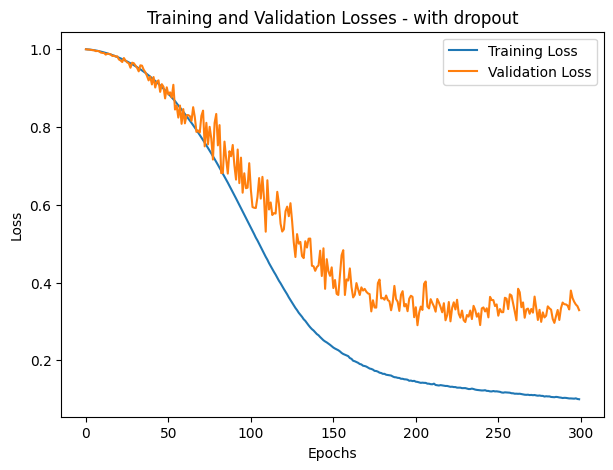

In [19]:
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses - with dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xticks(range(0, len(train_losses), 1))  # Specify tick locations every 5 epochs
plt.legend()
plt.show()

## Section-5 (c): UNet demos

In [16]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(n_channels = 1, n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model_saving_path = '/projectnb/ec500kb/projects/Project6/'

In [17]:
# training and validation

train_losses = []
val_losses = []
num_epochs = 300
train_predictions = []
val_predictions = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        img = img.unsqueeze(0)
        std_map = images['std_map'].float().to(device)
        std_map = std_map.unsqueeze(0)
        #print(img.shape)
        #print(std_map.shape)
        optimizer.zero_grad()
        y_pred = model(img)
        train_predictions.append(y_pred)
        #print(y_pred.shape)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = image['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)

            y_pred = model(img)
            val_predictions.append(y_pred)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

100%|██████████| 72/72 [00:00<00:00, 354.37it/s]


Epoch [1/300], Train Loss: 0.9997, Validation Loss: 0.9996


100%|██████████| 72/72 [00:00<00:00, 358.27it/s]


Epoch [2/300], Train Loss: 0.9994, Validation Loss: 0.9994


100%|██████████| 72/72 [00:00<00:00, 359.48it/s]


Epoch [3/300], Train Loss: 0.9990, Validation Loss: 0.9992


100%|██████████| 72/72 [00:00<00:00, 347.90it/s]


Epoch [4/300], Train Loss: 0.9984, Validation Loss: 0.9986


100%|██████████| 72/72 [00:00<00:00, 358.09it/s]


Epoch [5/300], Train Loss: 0.9979, Validation Loss: 0.9977


100%|██████████| 72/72 [00:00<00:00, 357.15it/s]


Epoch [6/300], Train Loss: 0.9972, Validation Loss: 0.9979


100%|██████████| 72/72 [00:00<00:00, 358.02it/s]


Epoch [7/300], Train Loss: 0.9965, Validation Loss: 0.9964


100%|██████████| 72/72 [00:00<00:00, 359.37it/s]


Epoch [8/300], Train Loss: 0.9957, Validation Loss: 0.9961


100%|██████████| 72/72 [00:00<00:00, 357.14it/s]


Epoch [9/300], Train Loss: 0.9949, Validation Loss: 0.9965


100%|██████████| 72/72 [00:00<00:00, 357.15it/s]


Epoch [10/300], Train Loss: 0.9939, Validation Loss: 0.9952


100%|██████████| 72/72 [00:00<00:00, 357.42it/s]


Epoch [11/300], Train Loss: 0.9928, Validation Loss: 0.9964


100%|██████████| 72/72 [00:00<00:00, 356.98it/s]


Epoch [12/300], Train Loss: 0.9916, Validation Loss: 0.9939


100%|██████████| 72/72 [00:00<00:00, 357.55it/s]


Epoch [13/300], Train Loss: 0.9903, Validation Loss: 0.9950


100%|██████████| 72/72 [00:00<00:00, 356.37it/s]


Epoch [14/300], Train Loss: 0.9891, Validation Loss: 0.9933


100%|██████████| 72/72 [00:00<00:00, 358.17it/s]


Epoch [15/300], Train Loss: 0.9877, Validation Loss: 0.9905


100%|██████████| 72/72 [00:00<00:00, 335.06it/s]


Epoch [16/300], Train Loss: 0.9863, Validation Loss: 0.9915


100%|██████████| 72/72 [00:00<00:00, 356.28it/s]


Epoch [17/300], Train Loss: 0.9848, Validation Loss: 0.9921


100%|██████████| 72/72 [00:00<00:00, 356.12it/s]


Epoch [18/300], Train Loss: 0.9833, Validation Loss: 0.9899


100%|██████████| 72/72 [00:00<00:00, 357.31it/s]


Epoch [19/300], Train Loss: 0.9817, Validation Loss: 0.9868


100%|██████████| 72/72 [00:00<00:00, 356.98it/s]


Epoch [20/300], Train Loss: 0.9801, Validation Loss: 0.9841


100%|██████████| 72/72 [00:00<00:00, 357.39it/s]


Epoch [21/300], Train Loss: 0.9783, Validation Loss: 0.9817


100%|██████████| 72/72 [00:00<00:00, 357.50it/s]


Epoch [22/300], Train Loss: 0.9765, Validation Loss: 0.9843


100%|██████████| 72/72 [00:00<00:00, 355.49it/s]


Epoch [23/300], Train Loss: 0.9746, Validation Loss: 0.9834


100%|██████████| 72/72 [00:00<00:00, 356.82it/s]


Epoch [24/300], Train Loss: 0.9727, Validation Loss: 0.9857


100%|██████████| 72/72 [00:00<00:00, 358.19it/s]


Epoch [25/300], Train Loss: 0.9707, Validation Loss: 0.9806


100%|██████████| 72/72 [00:00<00:00, 358.95it/s]


Epoch [26/300], Train Loss: 0.9686, Validation Loss: 0.9744


100%|██████████| 72/72 [00:00<00:00, 359.27it/s]


Epoch [27/300], Train Loss: 0.9664, Validation Loss: 0.9790


100%|██████████| 72/72 [00:00<00:00, 332.85it/s]


Epoch [28/300], Train Loss: 0.9641, Validation Loss: 0.9763


100%|██████████| 72/72 [00:00<00:00, 359.23it/s]


Epoch [29/300], Train Loss: 0.9618, Validation Loss: 0.9713


100%|██████████| 72/72 [00:00<00:00, 360.33it/s]


Epoch [30/300], Train Loss: 0.9594, Validation Loss: 0.9804


100%|██████████| 72/72 [00:00<00:00, 360.05it/s]


Epoch [31/300], Train Loss: 0.9569, Validation Loss: 0.9665


100%|██████████| 72/72 [00:00<00:00, 360.11it/s]


Epoch [32/300], Train Loss: 0.9543, Validation Loss: 0.9554


100%|██████████| 72/72 [00:00<00:00, 358.58it/s]


Epoch [33/300], Train Loss: 0.9517, Validation Loss: 0.9724


100%|██████████| 72/72 [00:00<00:00, 358.42it/s]


Epoch [34/300], Train Loss: 0.9490, Validation Loss: 0.9708


100%|██████████| 72/72 [00:00<00:00, 359.91it/s]


Epoch [35/300], Train Loss: 0.9462, Validation Loss: 0.9734


100%|██████████| 72/72 [00:00<00:00, 357.46it/s]


Epoch [36/300], Train Loss: 0.9433, Validation Loss: 0.9614


100%|██████████| 72/72 [00:00<00:00, 359.80it/s]


Epoch [37/300], Train Loss: 0.9404, Validation Loss: 0.9599


100%|██████████| 72/72 [00:00<00:00, 360.05it/s]


Epoch [38/300], Train Loss: 0.9374, Validation Loss: 0.9567


100%|██████████| 72/72 [00:00<00:00, 359.90it/s]


Epoch [39/300], Train Loss: 0.9342, Validation Loss: 0.9600


100%|██████████| 72/72 [00:00<00:00, 344.67it/s]


Epoch [40/300], Train Loss: 0.9309, Validation Loss: 0.9707


100%|██████████| 72/72 [00:00<00:00, 359.61it/s]


Epoch [41/300], Train Loss: 0.9276, Validation Loss: 0.9703


100%|██████████| 72/72 [00:00<00:00, 358.05it/s]


Epoch [42/300], Train Loss: 0.9243, Validation Loss: 0.9475


100%|██████████| 72/72 [00:00<00:00, 358.83it/s]


Epoch [43/300], Train Loss: 0.9208, Validation Loss: 0.9660


100%|██████████| 72/72 [00:00<00:00, 360.25it/s]


Epoch [44/300], Train Loss: 0.9173, Validation Loss: 0.9583


100%|██████████| 72/72 [00:00<00:00, 359.57it/s]


Epoch [45/300], Train Loss: 0.9137, Validation Loss: 0.9388


100%|██████████| 72/72 [00:00<00:00, 358.33it/s]


Epoch [46/300], Train Loss: 0.9100, Validation Loss: 0.9458


100%|██████████| 72/72 [00:00<00:00, 359.95it/s]


Epoch [47/300], Train Loss: 0.9061, Validation Loss: 0.9498


100%|██████████| 72/72 [00:00<00:00, 359.24it/s]


Epoch [48/300], Train Loss: 0.9023, Validation Loss: 0.9350


100%|██████████| 72/72 [00:00<00:00, 360.18it/s]


Epoch [49/300], Train Loss: 0.8983, Validation Loss: 0.9473


100%|██████████| 72/72 [00:00<00:00, 358.64it/s]


Epoch [50/300], Train Loss: 0.8943, Validation Loss: 0.9736


100%|██████████| 72/72 [00:00<00:00, 359.49it/s]


Epoch [51/300], Train Loss: 0.8902, Validation Loss: 0.9348


100%|██████████| 72/72 [00:00<00:00, 346.08it/s]


Epoch [52/300], Train Loss: 0.8861, Validation Loss: 0.9236


100%|██████████| 72/72 [00:00<00:00, 356.35it/s]


Epoch [53/300], Train Loss: 0.8818, Validation Loss: 0.9264


100%|██████████| 72/72 [00:00<00:00, 358.83it/s]


Epoch [54/300], Train Loss: 0.8775, Validation Loss: 0.9516


100%|██████████| 72/72 [00:00<00:00, 360.15it/s]


Epoch [55/300], Train Loss: 0.8731, Validation Loss: 0.9240


100%|██████████| 72/72 [00:00<00:00, 359.29it/s]


Epoch [56/300], Train Loss: 0.8687, Validation Loss: 0.9373


100%|██████████| 72/72 [00:00<00:00, 358.17it/s]


Epoch [57/300], Train Loss: 0.8641, Validation Loss: 0.9576


100%|██████████| 72/72 [00:00<00:00, 359.53it/s]


Epoch [58/300], Train Loss: 0.8594, Validation Loss: 0.9278


100%|██████████| 72/72 [00:00<00:00, 359.79it/s]


Epoch [59/300], Train Loss: 0.8547, Validation Loss: 0.9042


100%|██████████| 72/72 [00:00<00:00, 356.95it/s]


Epoch [60/300], Train Loss: 0.8499, Validation Loss: 0.9212


100%|██████████| 72/72 [00:00<00:00, 358.12it/s]


Epoch [61/300], Train Loss: 0.8448, Validation Loss: 0.9317


100%|██████████| 72/72 [00:00<00:00, 357.66it/s]


Epoch [62/300], Train Loss: 0.8399, Validation Loss: 0.9392


100%|██████████| 72/72 [00:00<00:00, 359.19it/s]


Epoch [63/300], Train Loss: 0.8348, Validation Loss: 0.9206


100%|██████████| 72/72 [00:00<00:00, 342.19it/s]


Epoch [64/300], Train Loss: 0.8297, Validation Loss: 0.9161


100%|██████████| 72/72 [00:00<00:00, 358.12it/s]


Epoch [65/300], Train Loss: 0.8244, Validation Loss: 0.8880


100%|██████████| 72/72 [00:00<00:00, 358.14it/s]


Epoch [66/300], Train Loss: 0.8192, Validation Loss: 0.8813


100%|██████████| 72/72 [00:00<00:00, 357.84it/s]


Epoch [67/300], Train Loss: 0.8135, Validation Loss: 0.8997


100%|██████████| 72/72 [00:00<00:00, 358.69it/s]


Epoch [68/300], Train Loss: 0.8079, Validation Loss: 0.9064


100%|██████████| 72/72 [00:00<00:00, 357.37it/s]


Epoch [69/300], Train Loss: 0.8022, Validation Loss: 0.8830


100%|██████████| 72/72 [00:00<00:00, 354.68it/s]


Epoch [70/300], Train Loss: 0.7967, Validation Loss: 0.8416


100%|██████████| 72/72 [00:00<00:00, 359.99it/s]


Epoch [71/300], Train Loss: 0.7907, Validation Loss: 0.8800


100%|██████████| 72/72 [00:00<00:00, 359.57it/s]


Epoch [72/300], Train Loss: 0.7851, Validation Loss: 0.9143


100%|██████████| 72/72 [00:00<00:00, 358.53it/s]


Epoch [73/300], Train Loss: 0.7790, Validation Loss: 0.9166


100%|██████████| 72/72 [00:00<00:00, 359.90it/s]


Epoch [74/300], Train Loss: 0.7729, Validation Loss: 0.8409


100%|██████████| 72/72 [00:00<00:00, 358.29it/s]


Epoch [75/300], Train Loss: 0.7671, Validation Loss: 0.8002


100%|██████████| 72/72 [00:00<00:00, 340.86it/s]


Epoch [76/300], Train Loss: 0.7608, Validation Loss: 0.8900


100%|██████████| 72/72 [00:00<00:00, 359.71it/s]


Epoch [77/300], Train Loss: 0.7544, Validation Loss: 0.8781


100%|██████████| 72/72 [00:00<00:00, 358.85it/s]


Epoch [78/300], Train Loss: 0.7485, Validation Loss: 0.8482


100%|██████████| 72/72 [00:00<00:00, 359.20it/s]


Epoch [79/300], Train Loss: 0.7418, Validation Loss: 0.8904


100%|██████████| 72/72 [00:00<00:00, 358.61it/s]


Epoch [80/300], Train Loss: 0.7355, Validation Loss: 0.8749


100%|██████████| 72/72 [00:00<00:00, 359.80it/s]


Epoch [81/300], Train Loss: 0.7286, Validation Loss: 0.8250


100%|██████████| 72/72 [00:00<00:00, 359.60it/s]


Epoch [82/300], Train Loss: 0.7219, Validation Loss: 0.8279


100%|██████████| 72/72 [00:00<00:00, 356.37it/s]


Epoch [83/300], Train Loss: 0.7151, Validation Loss: 0.8509


100%|██████████| 72/72 [00:00<00:00, 359.99it/s]


Epoch [84/300], Train Loss: 0.7082, Validation Loss: 0.8984


100%|██████████| 72/72 [00:00<00:00, 359.75it/s]


Epoch [85/300], Train Loss: 0.7014, Validation Loss: 0.8641


100%|██████████| 72/72 [00:00<00:00, 359.45it/s]


Epoch [86/300], Train Loss: 0.6943, Validation Loss: 0.8346


100%|██████████| 72/72 [00:00<00:00, 356.65it/s]


Epoch [87/300], Train Loss: 0.6871, Validation Loss: 0.8943


100%|██████████| 72/72 [00:00<00:00, 339.16it/s]


Epoch [88/300], Train Loss: 0.6801, Validation Loss: 0.8838


100%|██████████| 72/72 [00:00<00:00, 360.03it/s]


Epoch [89/300], Train Loss: 0.6730, Validation Loss: 0.8253


100%|██████████| 72/72 [00:00<00:00, 358.99it/s]


Epoch [90/300], Train Loss: 0.6656, Validation Loss: 0.8430


100%|██████████| 72/72 [00:00<00:00, 358.31it/s]


Epoch [91/300], Train Loss: 0.6585, Validation Loss: 0.8583


100%|██████████| 72/72 [00:00<00:00, 359.33it/s]


Epoch [92/300], Train Loss: 0.6509, Validation Loss: 0.8670


100%|██████████| 72/72 [00:00<00:00, 359.88it/s]


Epoch [93/300], Train Loss: 0.6431, Validation Loss: 0.8355


100%|██████████| 72/72 [00:00<00:00, 359.41it/s]


Epoch [94/300], Train Loss: 0.6358, Validation Loss: 0.8414


100%|██████████| 72/72 [00:00<00:00, 359.64it/s]


Epoch [95/300], Train Loss: 0.6281, Validation Loss: 0.8387


100%|██████████| 72/72 [00:00<00:00, 357.92it/s]


Epoch [96/300], Train Loss: 0.6204, Validation Loss: 0.7601


100%|██████████| 72/72 [00:00<00:00, 359.61it/s]


Epoch [97/300], Train Loss: 0.6133, Validation Loss: 0.7979


100%|██████████| 72/72 [00:00<00:00, 358.63it/s]


Epoch [98/300], Train Loss: 0.6056, Validation Loss: 0.7879


100%|██████████| 72/72 [00:00<00:00, 358.61it/s]


Epoch [99/300], Train Loss: 0.5978, Validation Loss: 0.7538


100%|██████████| 72/72 [00:00<00:00, 333.65it/s]


Epoch [100/300], Train Loss: 0.5900, Validation Loss: 0.7817


100%|██████████| 72/72 [00:00<00:00, 358.27it/s]


Epoch [101/300], Train Loss: 0.5820, Validation Loss: 0.7457


100%|██████████| 72/72 [00:00<00:00, 356.28it/s]


Epoch [102/300], Train Loss: 0.5739, Validation Loss: 0.7915


100%|██████████| 72/72 [00:00<00:00, 357.90it/s]


Epoch [103/300], Train Loss: 0.5655, Validation Loss: 0.8182


100%|██████████| 72/72 [00:00<00:00, 356.37it/s]


Epoch [104/300], Train Loss: 0.5578, Validation Loss: 0.7809


100%|██████████| 72/72 [00:00<00:00, 357.81it/s]


Epoch [105/300], Train Loss: 0.5498, Validation Loss: 0.7987


100%|██████████| 72/72 [00:00<00:00, 358.38it/s]


Epoch [106/300], Train Loss: 0.5417, Validation Loss: 0.8525


100%|██████████| 72/72 [00:00<00:00, 358.11it/s]


Epoch [107/300], Train Loss: 0.5336, Validation Loss: 0.8028


100%|██████████| 72/72 [00:00<00:00, 356.51it/s]


Epoch [108/300], Train Loss: 0.5251, Validation Loss: 0.7938


100%|██████████| 72/72 [00:00<00:00, 358.14it/s]


Epoch [109/300], Train Loss: 0.5169, Validation Loss: 0.6953


100%|██████████| 72/72 [00:00<00:00, 358.04it/s]


Epoch [110/300], Train Loss: 0.5090, Validation Loss: 0.7523


100%|██████████| 72/72 [00:00<00:00, 358.04it/s]


Epoch [111/300], Train Loss: 0.5012, Validation Loss: 0.7270


100%|██████████| 72/72 [00:00<00:00, 335.78it/s]


Epoch [112/300], Train Loss: 0.4926, Validation Loss: 0.7715


100%|██████████| 72/72 [00:00<00:00, 359.15it/s]


Epoch [113/300], Train Loss: 0.4846, Validation Loss: 0.7098


100%|██████████| 72/72 [00:00<00:00, 358.28it/s]


Epoch [114/300], Train Loss: 0.4765, Validation Loss: 0.7155


100%|██████████| 72/72 [00:00<00:00, 359.79it/s]


Epoch [115/300], Train Loss: 0.4683, Validation Loss: 0.7857


100%|██████████| 72/72 [00:00<00:00, 359.94it/s]


Epoch [116/300], Train Loss: 0.4631, Validation Loss: 0.7570


100%|██████████| 72/72 [00:00<00:00, 360.30it/s]


Epoch [117/300], Train Loss: 0.4532, Validation Loss: 0.7086


100%|██████████| 72/72 [00:00<00:00, 359.77it/s]


Epoch [118/300], Train Loss: 0.4445, Validation Loss: 0.7729


100%|██████████| 72/72 [00:00<00:00, 359.47it/s]


Epoch [119/300], Train Loss: 0.4368, Validation Loss: 0.6589


100%|██████████| 72/72 [00:00<00:00, 360.01it/s]


Epoch [120/300], Train Loss: 0.4290, Validation Loss: 0.7117


100%|██████████| 72/72 [00:00<00:00, 359.00it/s]


Epoch [121/300], Train Loss: 0.4213, Validation Loss: 0.6320


100%|██████████| 72/72 [00:00<00:00, 360.20it/s]


Epoch [122/300], Train Loss: 0.4139, Validation Loss: 0.6539


100%|██████████| 72/72 [00:00<00:00, 359.94it/s]


Epoch [123/300], Train Loss: 0.4062, Validation Loss: 0.6526


100%|██████████| 72/72 [00:00<00:00, 339.34it/s]


Epoch [124/300], Train Loss: 0.3991, Validation Loss: 0.6213


100%|██████████| 72/72 [00:00<00:00, 359.68it/s]


Epoch [125/300], Train Loss: 0.3915, Validation Loss: 0.6161


100%|██████████| 72/72 [00:00<00:00, 358.30it/s]


Epoch [126/300], Train Loss: 0.3845, Validation Loss: 0.6591


100%|██████████| 72/72 [00:00<00:00, 360.24it/s]


Epoch [127/300], Train Loss: 0.3787, Validation Loss: 0.6525


100%|██████████| 72/72 [00:00<00:00, 358.97it/s]


Epoch [128/300], Train Loss: 0.3718, Validation Loss: 0.6307


100%|██████████| 72/72 [00:00<00:00, 359.76it/s]


Epoch [129/300], Train Loss: 0.3642, Validation Loss: 0.6123


100%|██████████| 72/72 [00:00<00:00, 359.79it/s]


Epoch [130/300], Train Loss: 0.3578, Validation Loss: 0.5832


100%|██████████| 72/72 [00:00<00:00, 359.88it/s]


Epoch [131/300], Train Loss: 0.3517, Validation Loss: 0.5571


100%|██████████| 72/72 [00:00<00:00, 358.79it/s]


Epoch [132/300], Train Loss: 0.3447, Validation Loss: 0.5765


100%|██████████| 72/72 [00:00<00:00, 359.54it/s]


Epoch [133/300], Train Loss: 0.3404, Validation Loss: 0.6272


100%|██████████| 72/72 [00:00<00:00, 358.03it/s]


Epoch [134/300], Train Loss: 0.3343, Validation Loss: 0.6132


100%|██████████| 72/72 [00:00<00:00, 359.91it/s]


Epoch [135/300], Train Loss: 0.3285, Validation Loss: 0.5294


100%|██████████| 72/72 [00:00<00:00, 341.02it/s]


Epoch [136/300], Train Loss: 0.3219, Validation Loss: 0.5665


100%|██████████| 72/72 [00:00<00:00, 115.27it/s]


Epoch [137/300], Train Loss: 0.3166, Validation Loss: 0.5247


100%|██████████| 72/72 [00:00<00:00, 359.21it/s]


Epoch [138/300], Train Loss: 0.3112, Validation Loss: 0.5474


100%|██████████| 72/72 [00:00<00:00, 358.88it/s]


Epoch [139/300], Train Loss: 0.3062, Validation Loss: 0.5375


100%|██████████| 72/72 [00:00<00:00, 360.30it/s]


Epoch [140/300], Train Loss: 0.3020, Validation Loss: 0.4797


100%|██████████| 72/72 [00:00<00:00, 359.20it/s]


Epoch [141/300], Train Loss: 0.2986, Validation Loss: 0.4987


100%|██████████| 72/72 [00:00<00:00, 360.06it/s]


Epoch [142/300], Train Loss: 0.2949, Validation Loss: 0.4398


100%|██████████| 72/72 [00:00<00:00, 358.94it/s]


Epoch [143/300], Train Loss: 0.2906, Validation Loss: 0.5214


100%|██████████| 72/72 [00:00<00:00, 360.04it/s]


Epoch [144/300], Train Loss: 0.2858, Validation Loss: 0.4558


100%|██████████| 72/72 [00:00<00:00, 357.70it/s]


Epoch [145/300], Train Loss: 0.2817, Validation Loss: 0.4511


100%|██████████| 72/72 [00:00<00:00, 359.64it/s]


Epoch [146/300], Train Loss: 0.2777, Validation Loss: 0.4525


100%|██████████| 72/72 [00:00<00:00, 359.56it/s]


Epoch [147/300], Train Loss: 0.2739, Validation Loss: 0.4411


100%|██████████| 72/72 [00:00<00:00, 350.47it/s]


Epoch [148/300], Train Loss: 0.2704, Validation Loss: 0.4125


100%|██████████| 72/72 [00:00<00:00, 359.29it/s]


Epoch [149/300], Train Loss: 0.2675, Validation Loss: 0.4408


100%|██████████| 72/72 [00:00<00:00, 359.20it/s]


Epoch [150/300], Train Loss: 0.2643, Validation Loss: 0.4686


100%|██████████| 72/72 [00:00<00:00, 358.00it/s]


Epoch [151/300], Train Loss: 0.2646, Validation Loss: 0.3764


100%|██████████| 72/72 [00:00<00:00, 354.31it/s]


Epoch [152/300], Train Loss: 0.2599, Validation Loss: 0.4147


100%|██████████| 72/72 [00:00<00:00, 355.47it/s]


Epoch [153/300], Train Loss: 0.2564, Validation Loss: 0.3844


100%|██████████| 72/72 [00:00<00:00, 359.39it/s]


Epoch [154/300], Train Loss: 0.2539, Validation Loss: 0.3805


100%|██████████| 72/72 [00:00<00:00, 359.13it/s]


Epoch [155/300], Train Loss: 0.2510, Validation Loss: 0.3470


100%|██████████| 72/72 [00:00<00:00, 360.03it/s]


Epoch [156/300], Train Loss: 0.2488, Validation Loss: 0.3796


100%|██████████| 72/72 [00:00<00:00, 360.09it/s]


Epoch [157/300], Train Loss: 0.2456, Validation Loss: 0.3872


100%|██████████| 72/72 [00:00<00:00, 359.73it/s]


Epoch [158/300], Train Loss: 0.2441, Validation Loss: 0.4030


100%|██████████| 72/72 [00:00<00:00, 358.84it/s]


Epoch [159/300], Train Loss: 0.2421, Validation Loss: 0.3915


100%|██████████| 72/72 [00:00<00:00, 329.60it/s]


Epoch [160/300], Train Loss: 0.2394, Validation Loss: 0.3791


100%|██████████| 72/72 [00:00<00:00, 358.67it/s]


Epoch [161/300], Train Loss: 0.2377, Validation Loss: 0.3853


100%|██████████| 72/72 [00:00<00:00, 359.68it/s]


Epoch [162/300], Train Loss: 0.2349, Validation Loss: 0.3609


100%|██████████| 72/72 [00:00<00:00, 358.69it/s]


Epoch [163/300], Train Loss: 0.2338, Validation Loss: 0.3691


100%|██████████| 72/72 [00:00<00:00, 358.73it/s]


Epoch [164/300], Train Loss: 0.2323, Validation Loss: 0.3551


100%|██████████| 72/72 [00:00<00:00, 358.86it/s]


Epoch [165/300], Train Loss: 0.2304, Validation Loss: 0.3862


100%|██████████| 72/72 [00:00<00:00, 357.47it/s]


Epoch [166/300], Train Loss: 0.2289, Validation Loss: 0.3578


100%|██████████| 72/72 [00:00<00:00, 358.66it/s]


Epoch [167/300], Train Loss: 0.2280, Validation Loss: 0.3931


100%|██████████| 72/72 [00:00<00:00, 356.47it/s]


Epoch [168/300], Train Loss: 0.2267, Validation Loss: 0.3266


100%|██████████| 72/72 [00:00<00:00, 357.06it/s]


Epoch [169/300], Train Loss: 0.2258, Validation Loss: 0.3408


100%|██████████| 72/72 [00:00<00:00, 357.71it/s]


Epoch [170/300], Train Loss: 0.2243, Validation Loss: 0.3483


100%|██████████| 72/72 [00:00<00:00, 358.52it/s]


Epoch [171/300], Train Loss: 0.2224, Validation Loss: 0.3467


100%|██████████| 72/72 [00:00<00:00, 335.84it/s]


Epoch [172/300], Train Loss: 0.2209, Validation Loss: 0.3253


100%|██████████| 72/72 [00:00<00:00, 359.57it/s]


Epoch [173/300], Train Loss: 0.2190, Validation Loss: 0.3443


100%|██████████| 72/72 [00:00<00:00, 359.83it/s]


Epoch [174/300], Train Loss: 0.2182, Validation Loss: 0.3357


100%|██████████| 72/72 [00:00<00:00, 359.70it/s]


Epoch [175/300], Train Loss: 0.2169, Validation Loss: 0.3268


100%|██████████| 72/72 [00:00<00:00, 358.19it/s]


Epoch [176/300], Train Loss: 0.2152, Validation Loss: 0.3675


100%|██████████| 72/72 [00:00<00:00, 356.26it/s]


Epoch [177/300], Train Loss: 0.2147, Validation Loss: 0.3081


100%|██████████| 72/72 [00:00<00:00, 358.56it/s]


Epoch [178/300], Train Loss: 0.2124, Validation Loss: 0.2824


100%|██████████| 72/72 [00:00<00:00, 360.06it/s]


Epoch [179/300], Train Loss: 0.2114, Validation Loss: 0.3186


100%|██████████| 72/72 [00:00<00:00, 359.59it/s]


Epoch [180/300], Train Loss: 0.2098, Validation Loss: 0.3099


100%|██████████| 72/72 [00:00<00:00, 358.20it/s]


Epoch [181/300], Train Loss: 0.2090, Validation Loss: 0.3524


100%|██████████| 72/72 [00:00<00:00, 359.68it/s]


Epoch [182/300], Train Loss: 0.2076, Validation Loss: 0.3051


100%|██████████| 72/72 [00:00<00:00, 357.70it/s]


Epoch [183/300], Train Loss: 0.2074, Validation Loss: 0.2564


100%|██████████| 72/72 [00:00<00:00, 329.20it/s]


Epoch [184/300], Train Loss: 0.2060, Validation Loss: 0.3102


100%|██████████| 72/72 [00:00<00:00, 356.10it/s]


Epoch [185/300], Train Loss: 0.2050, Validation Loss: 0.3015


100%|██████████| 72/72 [00:00<00:00, 358.16it/s]


Epoch [186/300], Train Loss: 0.2039, Validation Loss: 0.3084


100%|██████████| 72/72 [00:00<00:00, 356.24it/s]


Epoch [187/300], Train Loss: 0.2030, Validation Loss: 0.3065


100%|██████████| 72/72 [00:00<00:00, 360.10it/s]


Epoch [188/300], Train Loss: 0.2024, Validation Loss: 0.3179


100%|██████████| 72/72 [00:00<00:00, 359.48it/s]


Epoch [189/300], Train Loss: 0.2008, Validation Loss: 0.2745


100%|██████████| 72/72 [00:00<00:00, 359.36it/s]


Epoch [190/300], Train Loss: 0.2012, Validation Loss: 0.3042


100%|██████████| 72/72 [00:00<00:00, 359.35it/s]


Epoch [191/300], Train Loss: 0.1997, Validation Loss: 0.3078


100%|██████████| 72/72 [00:00<00:00, 359.59it/s]


Epoch [192/300], Train Loss: 0.1980, Validation Loss: 0.2316


100%|██████████| 72/72 [00:00<00:00, 359.17it/s]


Epoch [193/300], Train Loss: 0.1965, Validation Loss: 0.2613


100%|██████████| 72/72 [00:00<00:00, 358.23it/s]


Epoch [194/300], Train Loss: 0.1954, Validation Loss: 0.2991


100%|██████████| 72/72 [00:00<00:00, 358.29it/s]


Epoch [195/300], Train Loss: 0.1943, Validation Loss: 0.3026


100%|██████████| 72/72 [00:00<00:00, 337.02it/s]


Epoch [196/300], Train Loss: 0.1921, Validation Loss: 0.2677


100%|██████████| 72/72 [00:00<00:00, 358.99it/s]


Epoch [197/300], Train Loss: 0.1909, Validation Loss: 0.2815


100%|██████████| 72/72 [00:00<00:00, 359.75it/s]


Epoch [198/300], Train Loss: 0.1887, Validation Loss: 0.2903


100%|██████████| 72/72 [00:00<00:00, 358.01it/s]


Epoch [199/300], Train Loss: 0.1890, Validation Loss: 0.2490


100%|██████████| 72/72 [00:00<00:00, 357.66it/s]


Epoch [200/300], Train Loss: 0.1866, Validation Loss: 0.2908


100%|██████████| 72/72 [00:00<00:00, 358.63it/s]


Epoch [201/300], Train Loss: 0.1857, Validation Loss: 0.2526


100%|██████████| 72/72 [00:00<00:00, 357.45it/s]


Epoch [202/300], Train Loss: 0.1825, Validation Loss: 0.3215


100%|██████████| 72/72 [00:00<00:00, 358.48it/s]


Epoch [203/300], Train Loss: 0.1825, Validation Loss: 0.2340


100%|██████████| 72/72 [00:00<00:00, 357.60it/s]


Epoch [204/300], Train Loss: 0.1792, Validation Loss: 0.2275


100%|██████████| 72/72 [00:00<00:00, 356.60it/s]


Epoch [205/300], Train Loss: 0.1783, Validation Loss: 0.2512


100%|██████████| 72/72 [00:00<00:00, 357.54it/s]


Epoch [206/300], Train Loss: 0.1773, Validation Loss: 0.2366


100%|██████████| 72/72 [00:00<00:00, 357.54it/s]


Epoch [207/300], Train Loss: 0.1753, Validation Loss: 0.3249


100%|██████████| 72/72 [00:00<00:00, 333.66it/s]


Epoch [208/300], Train Loss: 0.1742, Validation Loss: 0.2496


100%|██████████| 72/72 [00:00<00:00, 357.69it/s]


Epoch [209/300], Train Loss: 0.1741, Validation Loss: 0.3031


100%|██████████| 72/72 [00:00<00:00, 356.97it/s]


Epoch [210/300], Train Loss: 0.1709, Validation Loss: 0.2917


100%|██████████| 72/72 [00:00<00:00, 358.05it/s]


Epoch [211/300], Train Loss: 0.1712, Validation Loss: 0.2918


100%|██████████| 72/72 [00:00<00:00, 357.09it/s]


Epoch [212/300], Train Loss: 0.1702, Validation Loss: 0.2782


100%|██████████| 72/72 [00:00<00:00, 359.25it/s]


Epoch [213/300], Train Loss: 0.1681, Validation Loss: 0.2736


100%|██████████| 72/72 [00:00<00:00, 359.44it/s]


Epoch [214/300], Train Loss: 0.1665, Validation Loss: 0.3040


100%|██████████| 72/72 [00:00<00:00, 357.98it/s]


Epoch [215/300], Train Loss: 0.1644, Validation Loss: 0.2274


100%|██████████| 72/72 [00:00<00:00, 358.35it/s]


Epoch [216/300], Train Loss: 0.1641, Validation Loss: 0.3009


100%|██████████| 72/72 [00:00<00:00, 357.98it/s]


Epoch [217/300], Train Loss: 0.1629, Validation Loss: 0.2653


100%|██████████| 72/72 [00:00<00:00, 357.62it/s]


Epoch [218/300], Train Loss: 0.1614, Validation Loss: 0.3225


100%|██████████| 72/72 [00:00<00:00, 357.78it/s]


Epoch [219/300], Train Loss: 0.1613, Validation Loss: 0.2766


100%|██████████| 72/72 [00:00<00:00, 332.80it/s]


Epoch [220/300], Train Loss: 0.1619, Validation Loss: 0.2944


100%|██████████| 72/72 [00:00<00:00, 358.19it/s]


Epoch [221/300], Train Loss: 0.1580, Validation Loss: 0.2652


100%|██████████| 72/72 [00:00<00:00, 359.71it/s]


Epoch [222/300], Train Loss: 0.1577, Validation Loss: 0.2599


100%|██████████| 72/72 [00:00<00:00, 359.56it/s]


Epoch [223/300], Train Loss: 0.1580, Validation Loss: 0.3175


100%|██████████| 72/72 [00:00<00:00, 358.55it/s]


Epoch [224/300], Train Loss: 0.1564, Validation Loss: 0.2362


100%|██████████| 72/72 [00:00<00:00, 358.88it/s]


Epoch [225/300], Train Loss: 0.1581, Validation Loss: 0.2915


100%|██████████| 72/72 [00:00<00:00, 359.75it/s]


Epoch [226/300], Train Loss: 0.1555, Validation Loss: 0.2868


100%|██████████| 72/72 [00:00<00:00, 359.39it/s]


Epoch [227/300], Train Loss: 0.1545, Validation Loss: 0.2775


100%|██████████| 72/72 [00:00<00:00, 359.23it/s]


Epoch [228/300], Train Loss: 0.1534, Validation Loss: 0.2681


100%|██████████| 72/72 [00:00<00:00, 359.77it/s]


Epoch [229/300], Train Loss: 0.1519, Validation Loss: 0.2511


100%|██████████| 72/72 [00:00<00:00, 358.73it/s]


Epoch [230/300], Train Loss: 0.1513, Validation Loss: 0.3049


100%|██████████| 72/72 [00:00<00:00, 359.35it/s]


Epoch [231/300], Train Loss: 0.1500, Validation Loss: 0.2831


100%|██████████| 72/72 [00:00<00:00, 331.87it/s]


Epoch [232/300], Train Loss: 0.1502, Validation Loss: 0.3270


100%|██████████| 72/72 [00:00<00:00, 358.37it/s]


Epoch [233/300], Train Loss: 0.1502, Validation Loss: 0.3262


100%|██████████| 72/72 [00:00<00:00, 359.87it/s]


Epoch [234/300], Train Loss: 0.1490, Validation Loss: 0.2849


100%|██████████| 72/72 [00:00<00:00, 359.39it/s]


Epoch [235/300], Train Loss: 0.1478, Validation Loss: 0.2520


100%|██████████| 72/72 [00:00<00:00, 359.07it/s]


Epoch [236/300], Train Loss: 0.1479, Validation Loss: 0.2709


100%|██████████| 72/72 [00:00<00:00, 359.38it/s]


Epoch [237/300], Train Loss: 0.1469, Validation Loss: 0.2903


100%|██████████| 72/72 [00:00<00:00, 359.71it/s]


Epoch [238/300], Train Loss: 0.1461, Validation Loss: 0.3159


100%|██████████| 72/72 [00:00<00:00, 358.70it/s]


Epoch [239/300], Train Loss: 0.1477, Validation Loss: 0.2808


100%|██████████| 72/72 [00:00<00:00, 357.83it/s]


Epoch [240/300], Train Loss: 0.1445, Validation Loss: 0.2700


100%|██████████| 72/72 [00:00<00:00, 356.88it/s]


Epoch [241/300], Train Loss: 0.1442, Validation Loss: 0.3081


100%|██████████| 72/72 [00:00<00:00, 358.36it/s]


Epoch [242/300], Train Loss: 0.1442, Validation Loss: 0.3019


100%|██████████| 72/72 [00:00<00:00, 359.89it/s]


Epoch [243/300], Train Loss: 0.1437, Validation Loss: 0.2775


100%|██████████| 72/72 [00:00<00:00, 332.81it/s]


Epoch [244/300], Train Loss: 0.1423, Validation Loss: 0.2964


100%|██████████| 72/72 [00:00<00:00, 358.57it/s]


Epoch [245/300], Train Loss: 0.1422, Validation Loss: 0.2763


100%|██████████| 72/72 [00:00<00:00, 358.18it/s]


Epoch [246/300], Train Loss: 0.1418, Validation Loss: 0.2899


100%|██████████| 72/72 [00:00<00:00, 359.25it/s]


Epoch [247/300], Train Loss: 0.1416, Validation Loss: 0.2573


100%|██████████| 72/72 [00:00<00:00, 358.03it/s]


Epoch [248/300], Train Loss: 0.1399, Validation Loss: 0.2781


100%|██████████| 72/72 [00:00<00:00, 355.26it/s]


Epoch [249/300], Train Loss: 0.1400, Validation Loss: 0.2978


100%|██████████| 72/72 [00:00<00:00, 359.02it/s]


Epoch [250/300], Train Loss: 0.1386, Validation Loss: 0.2962


100%|██████████| 72/72 [00:00<00:00, 358.61it/s]


Epoch [251/300], Train Loss: 0.1391, Validation Loss: 0.2666


100%|██████████| 72/72 [00:00<00:00, 359.60it/s]


Epoch [252/300], Train Loss: 0.1380, Validation Loss: 0.2641


100%|██████████| 72/72 [00:00<00:00, 357.64it/s]


Epoch [253/300], Train Loss: 0.1376, Validation Loss: 0.2867


100%|██████████| 72/72 [00:00<00:00, 358.86it/s]


Epoch [254/300], Train Loss: 0.1372, Validation Loss: 0.2927


100%|██████████| 72/72 [00:00<00:00, 358.23it/s]


Epoch [255/300], Train Loss: 0.1355, Validation Loss: 0.3080


100%|██████████| 72/72 [00:00<00:00, 330.89it/s]


Epoch [256/300], Train Loss: 0.1352, Validation Loss: 0.3091


100%|██████████| 72/72 [00:00<00:00, 359.49it/s]


Epoch [257/300], Train Loss: 0.1367, Validation Loss: 0.2872


100%|██████████| 72/72 [00:00<00:00, 358.50it/s]


Epoch [258/300], Train Loss: 0.1347, Validation Loss: 0.3076


100%|██████████| 72/72 [00:00<00:00, 359.46it/s]


Epoch [259/300], Train Loss: 0.1342, Validation Loss: 0.3038


100%|██████████| 72/72 [00:00<00:00, 358.17it/s]


Epoch [260/300], Train Loss: 0.1336, Validation Loss: 0.2429


100%|██████████| 72/72 [00:00<00:00, 359.68it/s]


Epoch [261/300], Train Loss: 0.1334, Validation Loss: 0.2791


100%|██████████| 72/72 [00:00<00:00, 358.32it/s]


Epoch [262/300], Train Loss: 0.1327, Validation Loss: 0.2619


100%|██████████| 72/72 [00:00<00:00, 359.49it/s]


Epoch [263/300], Train Loss: 0.1321, Validation Loss: 0.2858


100%|██████████| 72/72 [00:00<00:00, 359.20it/s]


Epoch [264/300], Train Loss: 0.1317, Validation Loss: 0.2782


100%|██████████| 72/72 [00:00<00:00, 358.45it/s]


Epoch [265/300], Train Loss: 0.1310, Validation Loss: 0.2822


100%|██████████| 72/72 [00:00<00:00, 355.85it/s]


Epoch [266/300], Train Loss: 0.1300, Validation Loss: 0.2425


100%|██████████| 72/72 [00:00<00:00, 358.71it/s]


Epoch [267/300], Train Loss: 0.1304, Validation Loss: 0.2807


100%|██████████| 72/72 [00:00<00:00, 339.66it/s]


Epoch [268/300], Train Loss: 0.1291, Validation Loss: 0.2799


100%|██████████| 72/72 [00:00<00:00, 358.21it/s]


Epoch [269/300], Train Loss: 0.1291, Validation Loss: 0.2730


100%|██████████| 72/72 [00:00<00:00, 358.27it/s]


Epoch [270/300], Train Loss: 0.1277, Validation Loss: 0.3000


100%|██████████| 72/72 [00:00<00:00, 358.71it/s]


Epoch [271/300], Train Loss: 0.1280, Validation Loss: 0.3126


100%|██████████| 72/72 [00:00<00:00, 358.74it/s]


Epoch [272/300], Train Loss: 0.1278, Validation Loss: 0.3016


100%|██████████| 72/72 [00:00<00:00, 357.57it/s]


Epoch [273/300], Train Loss: 0.1263, Validation Loss: 0.2937


100%|██████████| 72/72 [00:00<00:00, 359.27it/s]


Epoch [274/300], Train Loss: 0.1258, Validation Loss: 0.2701


100%|██████████| 72/72 [00:00<00:00, 358.07it/s]


Epoch [275/300], Train Loss: 0.1257, Validation Loss: 0.3041


100%|██████████| 72/72 [00:00<00:00, 356.93it/s]


Epoch [276/300], Train Loss: 0.1250, Validation Loss: 0.2824


100%|██████████| 72/72 [00:00<00:00, 358.13it/s]


Epoch [277/300], Train Loss: 0.1254, Validation Loss: 0.2770


100%|██████████| 72/72 [00:00<00:00, 357.51it/s]


Epoch [278/300], Train Loss: 0.1253, Validation Loss: 0.2683


100%|██████████| 72/72 [00:00<00:00, 359.84it/s]


Epoch [279/300], Train Loss: 0.1237, Validation Loss: 0.2645


100%|██████████| 72/72 [00:00<00:00, 335.43it/s]


Epoch [280/300], Train Loss: 0.1228, Validation Loss: 0.3043


100%|██████████| 72/72 [00:00<00:00, 357.72it/s]


Epoch [281/300], Train Loss: 0.1237, Validation Loss: 0.2692


100%|██████████| 72/72 [00:00<00:00, 357.41it/s]


Epoch [282/300], Train Loss: 0.1230, Validation Loss: 0.2842


100%|██████████| 72/72 [00:00<00:00, 355.88it/s]


Epoch [283/300], Train Loss: 0.1221, Validation Loss: 0.3099


100%|██████████| 72/72 [00:00<00:00, 359.94it/s]


Epoch [284/300], Train Loss: 0.1219, Validation Loss: 0.2821


100%|██████████| 72/72 [00:00<00:00, 358.23it/s]


Epoch [285/300], Train Loss: 0.1206, Validation Loss: 0.2794


100%|██████████| 72/72 [00:00<00:00, 359.27it/s]


Epoch [286/300], Train Loss: 0.1206, Validation Loss: 0.3050


100%|██████████| 72/72 [00:00<00:00, 359.76it/s]


Epoch [287/300], Train Loss: 0.1202, Validation Loss: 0.2761


100%|██████████| 72/72 [00:00<00:00, 358.11it/s]


Epoch [288/300], Train Loss: 0.1198, Validation Loss: 0.2666


100%|██████████| 72/72 [00:00<00:00, 358.68it/s]


Epoch [289/300], Train Loss: 0.1184, Validation Loss: 0.2845


100%|██████████| 72/72 [00:00<00:00, 357.78it/s]


Epoch [290/300], Train Loss: 0.1187, Validation Loss: 0.2309


100%|██████████| 72/72 [00:00<00:00, 357.92it/s]


Epoch [291/300], Train Loss: 0.1184, Validation Loss: 0.2441


100%|██████████| 72/72 [00:00<00:00, 333.87it/s]


Epoch [292/300], Train Loss: 0.1180, Validation Loss: 0.2758


100%|██████████| 72/72 [00:00<00:00, 357.56it/s]


Epoch [293/300], Train Loss: 0.1169, Validation Loss: 0.3100


100%|██████████| 72/72 [00:00<00:00, 356.43it/s]


Epoch [294/300], Train Loss: 0.1167, Validation Loss: 0.3374


100%|██████████| 72/72 [00:00<00:00, 359.29it/s]


Epoch [295/300], Train Loss: 0.1176, Validation Loss: 0.2843


100%|██████████| 72/72 [00:00<00:00, 359.77it/s]


Epoch [296/300], Train Loss: 0.1164, Validation Loss: 0.2735


100%|██████████| 72/72 [00:00<00:00, 358.20it/s]


Epoch [297/300], Train Loss: 0.1150, Validation Loss: 0.2719


100%|██████████| 72/72 [00:00<00:00, 358.89it/s]


Epoch [298/300], Train Loss: 0.1152, Validation Loss: 0.2770


100%|██████████| 72/72 [00:00<00:00, 358.31it/s]


Epoch [299/300], Train Loss: 0.1142, Validation Loss: 0.2961


100%|██████████| 72/72 [00:00<00:00, 358.42it/s]

Epoch [300/300], Train Loss: 0.1145, Validation Loss: 0.2634


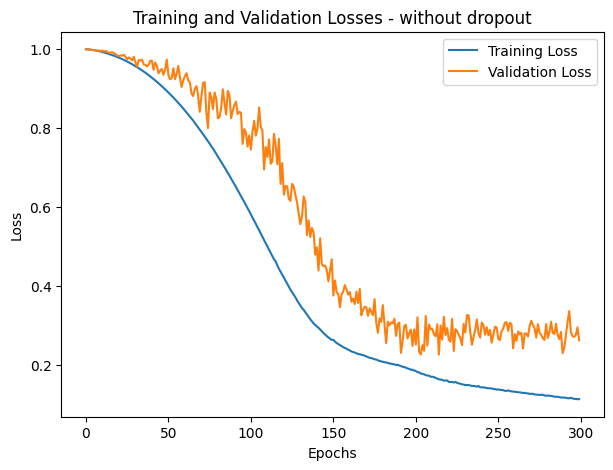

In [19]:
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses - without dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xticks(range(0, len(train_losses), 1))  # Specify tick locations every 5 epochs
plt.legend()
plt.show()

In [20]:
model.eval()

test_loss = 0.0
test = []
test_image = []
ground_truth = []
predicted_patches = []

model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # moving data to device
        images = batch['ct_generated'].float().to(device)
        std_maps = batch['std_map'].float().to(device)
        
        images = images.unsqueeze(0)
        std_maps = std_maps.unsqueeze(0)

        y_pred = model(images)

        # calculating loss
        loss = average_relative_error(y_pred, std_maps)
        test_loss += loss.item() * images.size(0)
        test.append(test_loss)
        y_pred = y_pred.unsqueeze(0)

        # appending data for visualization
        test_image.append(images.cpu().numpy())
        ground_truth.append(std_maps.cpu().numpy())
        predicted_patches.append(y_pred.cpu().numpy())

# calculating average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.1499


In [46]:
epsilon = 1e-8
ground_truth_final_safe = ground_truth_final + (ground_truth_final == 0) * epsilon
#average_percent_error = (np.array(ground_truth) - np.array(predicted_patches_final)) / np.array(ground_truth)

# Calculate the percentage error
percent_error = (ground_truth_final - predicted_patches_final) / ground_truth_final_safe
average_percent_error = abs(np.mean(percent_error)) * 100  # Convert to percentage

print(f"Average Percentage Error: {average_percent_error:.2f}%")


Average Percentage Error: 6.75%


## Multiple seeds - without dropout

In [31]:
seeds = [4, 54, 104]

all_train_losses = []
all_val_losses = []
all_train_predictions = []
all_val_predictions = []
num_epochs = 200


for i in seeds:
    
    set_determinism(seed=i)
    print("NEW SEED")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = UNet(n_channels = 1, n_classes = 1, dropout_rate=0.0).to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    model_saving_path = '/projectnb/ec500kb/projects/Project6/'
    
    train_losses = []
    val_losses = []
    train_predictions = []
    val_predictions = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_val_loss = 0.0
        model.train()  # Ensure the model is in training mode

        for idx, images in enumerate(tqdm(train_loader)):
            img = images['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = images['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)
            #print(img.shape)
            #print(std_map.shape)
            optimizer.zero_grad()
            y_pred = model(img)
            train_predictions.append(y_pred)
            #print(y_pred.shape)
            loss = average_relative_error(y_pred, std_map)
            #loss = criterion(y_pred, std_map)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for idx, image in enumerate(tqdm(val_loader)):
                img = image['ct_generated'].float().to(device)
                img = img.unsqueeze(0)
                std_map = image['std_map'].float().to(device)
                std_map = std_map.unsqueeze(0)

                y_pred = model(img)
                val_predictions.append(y_pred)
                val_loss = average_relative_error(y_pred, std_map)
                #val_loss = criterion(y_pred, std_map)
                running_val_loss += val_loss.item() * img.size(0)

            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
    
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_predictions.append(train_predictions)
    all_val_predictions.append(val_predictions)
    

NEW SEED


100%|██████████| 72/72 [00:00<00:00, 294.33it/s]


Epoch [1/200], Train Loss: 0.9997, Validation Loss: 0.9996


100%|██████████| 72/72 [00:00<00:00, 295.99it/s]


Epoch [2/200], Train Loss: 0.9993, Validation Loss: 0.9991


100%|██████████| 72/72 [00:00<00:00, 295.35it/s]


Epoch [3/200], Train Loss: 0.9989, Validation Loss: 0.9987


100%|██████████| 72/72 [00:00<00:00, 290.45it/s]


Epoch [4/200], Train Loss: 0.9984, Validation Loss: 0.9980


100%|██████████| 72/72 [00:00<00:00, 294.78it/s]


Epoch [5/200], Train Loss: 0.9977, Validation Loss: 0.9979


100%|██████████| 72/72 [00:00<00:00, 294.77it/s]


Epoch [6/200], Train Loss: 0.9971, Validation Loss: 0.9968


100%|██████████| 72/72 [00:00<00:00, 294.49it/s]


Epoch [7/200], Train Loss: 0.9963, Validation Loss: 0.9961


100%|██████████| 72/72 [00:00<00:00, 294.70it/s]


Epoch [8/200], Train Loss: 0.9954, Validation Loss: 0.9951


100%|██████████| 72/72 [00:00<00:00, 294.05it/s]


Epoch [9/200], Train Loss: 0.9945, Validation Loss: 0.9944


100%|██████████| 72/72 [00:00<00:00, 294.77it/s]


Epoch [10/200], Train Loss: 0.9935, Validation Loss: 0.9939


100%|██████████| 72/72 [00:00<00:00, 293.79it/s]


Epoch [11/200], Train Loss: 0.9925, Validation Loss: 0.9919


100%|██████████| 72/72 [00:00<00:00, 293.27it/s]


Epoch [12/200], Train Loss: 0.9914, Validation Loss: 0.9921


100%|██████████| 72/72 [00:00<00:00, 291.94it/s]


Epoch [13/200], Train Loss: 0.9902, Validation Loss: 0.9909


100%|██████████| 72/72 [00:00<00:00, 293.08it/s]


Epoch [14/200], Train Loss: 0.9890, Validation Loss: 0.9896


100%|██████████| 72/72 [00:00<00:00, 293.82it/s]


Epoch [15/200], Train Loss: 0.9877, Validation Loss: 0.9881


100%|██████████| 72/72 [00:00<00:00, 281.15it/s]


Epoch [16/200], Train Loss: 0.9863, Validation Loss: 0.9851


100%|██████████| 72/72 [00:00<00:00, 293.56it/s]


Epoch [17/200], Train Loss: 0.9849, Validation Loss: 0.9852


100%|██████████| 72/72 [00:00<00:00, 294.34it/s]


Epoch [18/200], Train Loss: 0.9834, Validation Loss: 0.9828


100%|██████████| 72/72 [00:00<00:00, 312.72it/s]


Epoch [19/200], Train Loss: 0.9819, Validation Loss: 0.9772


100%|██████████| 72/72 [00:00<00:00, 311.92it/s]


Epoch [20/200], Train Loss: 0.9803, Validation Loss: 0.9785


100%|██████████| 72/72 [00:00<00:00, 311.11it/s]


Epoch [21/200], Train Loss: 0.9786, Validation Loss: 0.9780


100%|██████████| 72/72 [00:00<00:00, 311.58it/s]


Epoch [22/200], Train Loss: 0.9768, Validation Loss: 0.9741


100%|██████████| 72/72 [00:00<00:00, 312.30it/s]


Epoch [23/200], Train Loss: 0.9750, Validation Loss: 0.9734


100%|██████████| 72/72 [00:00<00:00, 310.66it/s]


Epoch [24/200], Train Loss: 0.9731, Validation Loss: 0.9742


100%|██████████| 72/72 [00:00<00:00, 310.22it/s]


Epoch [25/200], Train Loss: 0.9711, Validation Loss: 0.9648


100%|██████████| 72/72 [00:00<00:00, 310.23it/s]


Epoch [26/200], Train Loss: 0.9691, Validation Loss: 0.9639


100%|██████████| 72/72 [00:00<00:00, 310.79it/s]


Epoch [27/200], Train Loss: 0.9670, Validation Loss: 0.9690


100%|██████████| 72/72 [00:00<00:00, 300.88it/s]


Epoch [28/200], Train Loss: 0.9648, Validation Loss: 0.9668


100%|██████████| 72/72 [00:00<00:00, 311.05it/s]


Epoch [29/200], Train Loss: 0.9606, Validation Loss: 0.9575


100%|██████████| 72/72 [00:00<00:00, 312.17it/s]


Epoch [30/200], Train Loss: 0.9570, Validation Loss: 0.9512


100%|██████████| 72/72 [00:00<00:00, 312.09it/s]


Epoch [31/200], Train Loss: 0.9541, Validation Loss: 0.9405


100%|██████████| 72/72 [00:00<00:00, 310.90it/s]


Epoch [32/200], Train Loss: 0.9511, Validation Loss: 0.9436


100%|██████████| 72/72 [00:00<00:00, 309.82it/s]


Epoch [33/200], Train Loss: 0.9481, Validation Loss: 0.9321


100%|██████████| 72/72 [00:00<00:00, 309.79it/s]


Epoch [34/200], Train Loss: 0.9449, Validation Loss: 0.9502


100%|██████████| 72/72 [00:00<00:00, 309.67it/s]


Epoch [35/200], Train Loss: 0.9417, Validation Loss: 0.9287


100%|██████████| 72/72 [00:00<00:00, 309.72it/s]


Epoch [36/200], Train Loss: 0.9384, Validation Loss: 0.9454


100%|██████████| 72/72 [00:00<00:00, 309.83it/s]


Epoch [37/200], Train Loss: 0.9349, Validation Loss: 0.9390


100%|██████████| 72/72 [00:00<00:00, 310.29it/s]


Epoch [38/200], Train Loss: 0.9314, Validation Loss: 0.9376


100%|██████████| 72/72 [00:00<00:00, 311.08it/s]


Epoch [39/200], Train Loss: 0.9278, Validation Loss: 0.9390


100%|██████████| 72/72 [00:00<00:00, 302.11it/s]


Epoch [40/200], Train Loss: 0.9241, Validation Loss: 0.9197


100%|██████████| 72/72 [00:00<00:00, 312.45it/s]


Epoch [41/200], Train Loss: 0.9203, Validation Loss: 0.9270


100%|██████████| 72/72 [00:00<00:00, 311.50it/s]


Epoch [42/200], Train Loss: 0.9164, Validation Loss: 0.8986


100%|██████████| 72/72 [00:00<00:00, 310.79it/s]


Epoch [43/200], Train Loss: 0.9123, Validation Loss: 0.8817


100%|██████████| 72/72 [00:00<00:00, 309.40it/s]


Epoch [44/200], Train Loss: 0.9082, Validation Loss: 0.9268


100%|██████████| 72/72 [00:00<00:00, 309.06it/s]


Epoch [45/200], Train Loss: 0.9040, Validation Loss: 0.8904


100%|██████████| 72/72 [00:00<00:00, 309.94it/s]


Epoch [46/200], Train Loss: 0.8997, Validation Loss: 0.8959


100%|██████████| 72/72 [00:00<00:00, 310.82it/s]


Epoch [47/200], Train Loss: 0.8953, Validation Loss: 0.8847


100%|██████████| 72/72 [00:00<00:00, 310.42it/s]


Epoch [48/200], Train Loss: 0.8908, Validation Loss: 0.8957


100%|██████████| 72/72 [00:00<00:00, 309.87it/s]


Epoch [49/200], Train Loss: 0.8863, Validation Loss: 0.8896


100%|██████████| 72/72 [00:00<00:00, 309.95it/s]


Epoch [50/200], Train Loss: 0.8815, Validation Loss: 0.8719


100%|██████████| 72/72 [00:00<00:00, 310.24it/s]


Epoch [51/200], Train Loss: 0.8767, Validation Loss: 0.8782


100%|██████████| 72/72 [00:00<00:00, 297.05it/s]


Epoch [52/200], Train Loss: 0.8719, Validation Loss: 0.8798


100%|██████████| 72/72 [00:00<00:00, 152.95it/s]


Epoch [53/200], Train Loss: 0.8669, Validation Loss: 0.8713


100%|██████████| 72/72 [00:00<00:00, 311.68it/s]


Epoch [54/200], Train Loss: 0.8618, Validation Loss: 0.8810


100%|██████████| 72/72 [00:00<00:00, 310.56it/s]


Epoch [55/200], Train Loss: 0.8567, Validation Loss: 0.8419


100%|██████████| 72/72 [00:00<00:00, 310.71it/s]


Epoch [56/200], Train Loss: 0.8514, Validation Loss: 0.8202


100%|██████████| 72/72 [00:00<00:00, 311.12it/s]


Epoch [57/200], Train Loss: 0.8460, Validation Loss: 0.8643


100%|██████████| 72/72 [00:00<00:00, 311.17it/s]


Epoch [58/200], Train Loss: 0.8406, Validation Loss: 0.8075


100%|██████████| 72/72 [00:00<00:00, 310.59it/s]


Epoch [59/200], Train Loss: 0.8351, Validation Loss: 0.8351


100%|██████████| 72/72 [00:00<00:00, 310.42it/s]


Epoch [60/200], Train Loss: 0.8295, Validation Loss: 0.8436


100%|██████████| 72/72 [00:00<00:00, 310.05it/s]


Epoch [61/200], Train Loss: 0.8237, Validation Loss: 0.8108


100%|██████████| 72/72 [00:00<00:00, 310.37it/s]


Epoch [62/200], Train Loss: 0.8179, Validation Loss: 0.8385


100%|██████████| 72/72 [00:00<00:00, 309.64it/s]


Epoch [63/200], Train Loss: 0.8120, Validation Loss: 0.8418


100%|██████████| 72/72 [00:00<00:00, 299.28it/s]


Epoch [64/200], Train Loss: 0.8059, Validation Loss: 0.8332


100%|██████████| 72/72 [00:00<00:00, 309.74it/s]


Epoch [65/200], Train Loss: 0.7997, Validation Loss: 0.7876


100%|██████████| 72/72 [00:00<00:00, 309.93it/s]


Epoch [66/200], Train Loss: 0.7935, Validation Loss: 0.7534


100%|██████████| 72/72 [00:00<00:00, 310.31it/s]


Epoch [67/200], Train Loss: 0.7872, Validation Loss: 0.7608


100%|██████████| 72/72 [00:00<00:00, 310.56it/s]


Epoch [68/200], Train Loss: 0.7808, Validation Loss: 0.8120


100%|██████████| 72/72 [00:00<00:00, 310.41it/s]


Epoch [69/200], Train Loss: 0.7743, Validation Loss: 0.8095


100%|██████████| 72/72 [00:00<00:00, 309.40it/s]


Epoch [70/200], Train Loss: 0.7678, Validation Loss: 0.7824


100%|██████████| 72/72 [00:00<00:00, 309.24it/s]


Epoch [71/200], Train Loss: 0.7610, Validation Loss: 0.7673


100%|██████████| 72/72 [00:00<00:00, 309.55it/s]


Epoch [72/200], Train Loss: 0.7542, Validation Loss: 0.8184


100%|██████████| 72/72 [00:00<00:00, 309.35it/s]


Epoch [73/200], Train Loss: 0.7473, Validation Loss: 0.8171


100%|██████████| 72/72 [00:00<00:00, 309.58it/s]


Epoch [74/200], Train Loss: 0.7404, Validation Loss: 0.7815


100%|██████████| 72/72 [00:00<00:00, 309.96it/s]


Epoch [75/200], Train Loss: 0.7332, Validation Loss: 0.7269


100%|██████████| 72/72 [00:00<00:00, 296.27it/s]


Epoch [76/200], Train Loss: 0.7262, Validation Loss: 0.7800


100%|██████████| 72/72 [00:00<00:00, 310.42it/s]


Epoch [77/200], Train Loss: 0.7189, Validation Loss: 0.7440


100%|██████████| 72/72 [00:00<00:00, 310.52it/s]


Epoch [78/200], Train Loss: 0.7118, Validation Loss: 0.7741


100%|██████████| 72/72 [00:00<00:00, 308.55it/s]


Epoch [79/200], Train Loss: 0.7041, Validation Loss: 0.7532


100%|██████████| 72/72 [00:00<00:00, 310.06it/s]


Epoch [80/200], Train Loss: 0.6966, Validation Loss: 0.7424


100%|██████████| 72/72 [00:00<00:00, 310.28it/s]


Epoch [81/200], Train Loss: 0.6884, Validation Loss: 0.7629


100%|██████████| 72/72 [00:00<00:00, 310.33it/s]


Epoch [82/200], Train Loss: 0.6806, Validation Loss: 0.7365


100%|██████████| 72/72 [00:00<00:00, 310.56it/s]


Epoch [83/200], Train Loss: 0.6730, Validation Loss: 0.7350


100%|██████████| 72/72 [00:00<00:00, 310.35it/s]


Epoch [84/200], Train Loss: 0.6650, Validation Loss: 0.7505


100%|██████████| 72/72 [00:00<00:00, 310.13it/s]


Epoch [85/200], Train Loss: 0.6571, Validation Loss: 0.7218


100%|██████████| 72/72 [00:00<00:00, 309.97it/s]


Epoch [86/200], Train Loss: 0.6494, Validation Loss: 0.6995


100%|██████████| 72/72 [00:00<00:00, 309.91it/s]


Epoch [87/200], Train Loss: 0.6412, Validation Loss: 0.7416


100%|██████████| 72/72 [00:00<00:00, 299.83it/s]


Epoch [88/200], Train Loss: 0.6330, Validation Loss: 0.7482


100%|██████████| 72/72 [00:00<00:00, 309.21it/s]


Epoch [89/200], Train Loss: 0.6248, Validation Loss: 0.7235


100%|██████████| 72/72 [00:00<00:00, 308.11it/s]


Epoch [90/200], Train Loss: 0.6165, Validation Loss: 0.7123


100%|██████████| 72/72 [00:00<00:00, 309.41it/s]


Epoch [91/200], Train Loss: 0.6081, Validation Loss: 0.6763


100%|██████████| 72/72 [00:00<00:00, 309.78it/s]


Epoch [92/200], Train Loss: 0.5997, Validation Loss: 0.6742


100%|██████████| 72/72 [00:00<00:00, 310.83it/s]


Epoch [93/200], Train Loss: 0.5912, Validation Loss: 0.6980


100%|██████████| 72/72 [00:00<00:00, 291.83it/s]


Epoch [94/200], Train Loss: 0.5832, Validation Loss: 0.7507


100%|██████████| 72/72 [00:00<00:00, 292.44it/s]


Epoch [95/200], Train Loss: 0.5741, Validation Loss: 0.6493


100%|██████████| 72/72 [00:00<00:00, 292.09it/s]


Epoch [96/200], Train Loss: 0.5656, Validation Loss: 0.6973


100%|██████████| 72/72 [00:00<00:00, 291.93it/s]


Epoch [97/200], Train Loss: 0.5571, Validation Loss: 0.6985


100%|██████████| 72/72 [00:00<00:00, 290.72it/s]


Epoch [98/200], Train Loss: 0.5480, Validation Loss: 0.7039


100%|██████████| 72/72 [00:00<00:00, 291.73it/s]


Epoch [99/200], Train Loss: 0.5396, Validation Loss: 0.6744


100%|██████████| 72/72 [00:00<00:00, 281.12it/s]


Epoch [100/200], Train Loss: 0.5306, Validation Loss: 0.6879


100%|██████████| 72/72 [00:00<00:00, 308.94it/s]


Epoch [101/200], Train Loss: 0.5216, Validation Loss: 0.6499


100%|██████████| 72/72 [00:00<00:00, 308.29it/s]


Epoch [102/200], Train Loss: 0.5129, Validation Loss: 0.6309


100%|██████████| 72/72 [00:00<00:00, 307.42it/s]


Epoch [103/200], Train Loss: 0.5034, Validation Loss: 0.6258


100%|██████████| 72/72 [00:00<00:00, 309.77it/s]


Epoch [104/200], Train Loss: 0.4945, Validation Loss: 0.5859


100%|██████████| 72/72 [00:00<00:00, 309.75it/s]


Epoch [105/200], Train Loss: 0.4852, Validation Loss: 0.6231


100%|██████████| 72/72 [00:00<00:00, 310.12it/s]


Epoch [106/200], Train Loss: 0.4760, Validation Loss: 0.6229


100%|██████████| 72/72 [00:00<00:00, 309.63it/s]


Epoch [107/200], Train Loss: 0.4650, Validation Loss: 0.5997


100%|██████████| 72/72 [00:00<00:00, 309.91it/s]


Epoch [108/200], Train Loss: 0.4567, Validation Loss: 0.6256


100%|██████████| 72/72 [00:00<00:00, 309.64it/s]


Epoch [109/200], Train Loss: 0.4472, Validation Loss: 0.5837


100%|██████████| 72/72 [00:00<00:00, 310.18it/s]


Epoch [110/200], Train Loss: 0.4389, Validation Loss: 0.5917


100%|██████████| 72/72 [00:00<00:00, 309.42it/s]


Epoch [111/200], Train Loss: 0.4291, Validation Loss: 0.5806


100%|██████████| 72/72 [00:00<00:00, 295.88it/s]


Epoch [112/200], Train Loss: 0.4199, Validation Loss: 0.5243


100%|██████████| 72/72 [00:00<00:00, 309.71it/s]


Epoch [113/200], Train Loss: 0.4110, Validation Loss: 0.5722


100%|██████████| 72/72 [00:00<00:00, 291.06it/s]


Epoch [114/200], Train Loss: 0.4025, Validation Loss: 0.6575


100%|██████████| 72/72 [00:00<00:00, 292.10it/s]


Epoch [115/200], Train Loss: 0.3938, Validation Loss: 0.5980


100%|██████████| 72/72 [00:00<00:00, 291.63it/s]


Epoch [116/200], Train Loss: 0.3851, Validation Loss: 0.5786


100%|██████████| 72/72 [00:00<00:00, 292.04it/s]


Epoch [117/200], Train Loss: 0.3768, Validation Loss: 0.5886


100%|██████████| 72/72 [00:00<00:00, 292.28it/s]


Epoch [118/200], Train Loss: 0.3693, Validation Loss: 0.5957


100%|██████████| 72/72 [00:00<00:00, 291.12it/s]


Epoch [119/200], Train Loss: 0.3608, Validation Loss: 0.5224


100%|██████████| 72/72 [00:00<00:00, 311.28it/s]


Epoch [120/200], Train Loss: 0.3526, Validation Loss: 0.5941


100%|██████████| 72/72 [00:00<00:00, 309.98it/s]


Epoch [121/200], Train Loss: 0.3452, Validation Loss: 0.5972


100%|██████████| 72/72 [00:00<00:00, 311.96it/s]


Epoch [122/200], Train Loss: 0.3380, Validation Loss: 0.5208


100%|██████████| 72/72 [00:00<00:00, 310.62it/s]


Epoch [123/200], Train Loss: 0.3299, Validation Loss: 0.5516


100%|██████████| 72/72 [00:00<00:00, 298.15it/s]


Epoch [124/200], Train Loss: 0.3224, Validation Loss: 0.5453


100%|██████████| 72/72 [00:00<00:00, 291.57it/s]


Epoch [125/200], Train Loss: 0.3152, Validation Loss: 0.4982


100%|██████████| 72/72 [00:00<00:00, 293.36it/s]


Epoch [126/200], Train Loss: 0.3082, Validation Loss: 0.5436


100%|██████████| 72/72 [00:00<00:00, 291.27it/s]


Epoch [127/200], Train Loss: 0.3020, Validation Loss: 0.5675


100%|██████████| 72/72 [00:00<00:00, 290.87it/s]


Epoch [128/200], Train Loss: 0.2949, Validation Loss: 0.4813


100%|██████████| 72/72 [00:00<00:00, 291.43it/s]


Epoch [129/200], Train Loss: 0.2885, Validation Loss: 0.4757


100%|██████████| 72/72 [00:00<00:00, 291.29it/s]


Epoch [130/200], Train Loss: 0.2813, Validation Loss: 0.5240


100%|██████████| 72/72 [00:00<00:00, 292.00it/s]


Epoch [131/200], Train Loss: 0.2757, Validation Loss: 0.4789


100%|██████████| 72/72 [00:00<00:00, 293.22it/s]


Epoch [132/200], Train Loss: 0.2693, Validation Loss: 0.4720


100%|██████████| 72/72 [00:00<00:00, 291.85it/s]


Epoch [133/200], Train Loss: 0.2639, Validation Loss: 0.5118


100%|██████████| 72/72 [00:00<00:00, 291.12it/s]


Epoch [134/200], Train Loss: 0.2584, Validation Loss: 0.4600


100%|██████████| 72/72 [00:00<00:00, 291.98it/s]


Epoch [135/200], Train Loss: 0.2531, Validation Loss: 0.4604


100%|██████████| 72/72 [00:00<00:00, 281.76it/s]


Epoch [136/200], Train Loss: 0.2488, Validation Loss: 0.4888


100%|██████████| 72/72 [00:00<00:00, 292.50it/s]


Epoch [137/200], Train Loss: 0.2437, Validation Loss: 0.4888


100%|██████████| 72/72 [00:00<00:00, 293.57it/s]


Epoch [138/200], Train Loss: 0.2372, Validation Loss: 0.4455


100%|██████████| 72/72 [00:00<00:00, 291.71it/s]


Epoch [139/200], Train Loss: 0.2330, Validation Loss: 0.4353


100%|██████████| 72/72 [00:00<00:00, 292.73it/s]


Epoch [140/200], Train Loss: 0.2299, Validation Loss: 0.4268


100%|██████████| 72/72 [00:00<00:00, 292.63it/s]


Epoch [141/200], Train Loss: 0.2239, Validation Loss: 0.4452


100%|██████████| 72/72 [00:00<00:00, 291.52it/s]


Epoch [142/200], Train Loss: 0.2211, Validation Loss: 0.4007


100%|██████████| 72/72 [00:00<00:00, 291.73it/s]


Epoch [143/200], Train Loss: 0.2175, Validation Loss: 0.4143


100%|██████████| 72/72 [00:00<00:00, 289.87it/s]


Epoch [144/200], Train Loss: 0.2131, Validation Loss: 0.4136


100%|██████████| 72/72 [00:00<00:00, 309.26it/s]


Epoch [145/200], Train Loss: 0.2090, Validation Loss: 0.4077


100%|██████████| 72/72 [00:00<00:00, 308.85it/s]


Epoch [146/200], Train Loss: 0.2057, Validation Loss: 0.4039


100%|██████████| 72/72 [00:00<00:00, 309.92it/s]


Epoch [147/200], Train Loss: 0.2017, Validation Loss: 0.3720


100%|██████████| 72/72 [00:00<00:00, 302.16it/s]


Epoch [148/200], Train Loss: 0.1983, Validation Loss: 0.4153


100%|██████████| 72/72 [00:00<00:00, 309.61it/s]


Epoch [149/200], Train Loss: 0.1967, Validation Loss: 0.4110


100%|██████████| 72/72 [00:00<00:00, 308.63it/s]


Epoch [150/200], Train Loss: 0.1924, Validation Loss: 0.3962


100%|██████████| 72/72 [00:00<00:00, 308.76it/s]


Epoch [151/200], Train Loss: 0.1881, Validation Loss: 0.3890


100%|██████████| 72/72 [00:00<00:00, 309.14it/s]


Epoch [152/200], Train Loss: 0.1863, Validation Loss: 0.3850


100%|██████████| 72/72 [00:00<00:00, 308.49it/s]


Epoch [153/200], Train Loss: 0.1832, Validation Loss: 0.3762


100%|██████████| 72/72 [00:00<00:00, 308.33it/s]


Epoch [154/200], Train Loss: 0.1797, Validation Loss: 0.4012


100%|██████████| 72/72 [00:00<00:00, 308.70it/s]


Epoch [155/200], Train Loss: 0.1773, Validation Loss: 0.3782


100%|██████████| 72/72 [00:00<00:00, 308.31it/s]


Epoch [156/200], Train Loss: 0.1749, Validation Loss: 0.4055


100%|██████████| 72/72 [00:00<00:00, 308.89it/s]


Epoch [157/200], Train Loss: 0.1743, Validation Loss: 0.3769


100%|██████████| 72/72 [00:00<00:00, 309.59it/s]


Epoch [158/200], Train Loss: 0.1694, Validation Loss: 0.3775


100%|██████████| 72/72 [00:00<00:00, 309.89it/s]


Epoch [159/200], Train Loss: 0.1673, Validation Loss: 0.3501


100%|██████████| 72/72 [00:00<00:00, 300.15it/s]


Epoch [160/200], Train Loss: 0.1667, Validation Loss: 0.3543


100%|██████████| 72/72 [00:00<00:00, 309.09it/s]


Epoch [161/200], Train Loss: 0.1636, Validation Loss: 0.3889


100%|██████████| 72/72 [00:00<00:00, 309.55it/s]


Epoch [162/200], Train Loss: 0.1622, Validation Loss: 0.3442


100%|██████████| 72/72 [00:00<00:00, 308.94it/s]


Epoch [163/200], Train Loss: 0.1597, Validation Loss: 0.3701


100%|██████████| 72/72 [00:00<00:00, 309.71it/s]


Epoch [164/200], Train Loss: 0.1573, Validation Loss: 0.3433


100%|██████████| 72/72 [00:00<00:00, 309.16it/s]


Epoch [165/200], Train Loss: 0.1570, Validation Loss: 0.3496


100%|██████████| 72/72 [00:00<00:00, 308.75it/s]


Epoch [166/200], Train Loss: 0.1547, Validation Loss: 0.3582


100%|██████████| 72/72 [00:00<00:00, 309.38it/s]


Epoch [167/200], Train Loss: 0.1525, Validation Loss: 0.3455


100%|██████████| 72/72 [00:00<00:00, 309.16it/s]


Epoch [168/200], Train Loss: 0.1516, Validation Loss: 0.3404


100%|██████████| 72/72 [00:00<00:00, 309.67it/s]


Epoch [169/200], Train Loss: 0.1501, Validation Loss: 0.3552


100%|██████████| 72/72 [00:00<00:00, 308.99it/s]


Epoch [170/200], Train Loss: 0.1478, Validation Loss: 0.3610


100%|██████████| 72/72 [00:00<00:00, 310.15it/s]


Epoch [171/200], Train Loss: 0.1484, Validation Loss: 0.3442


100%|██████████| 72/72 [00:00<00:00, 293.55it/s]


Epoch [172/200], Train Loss: 0.1466, Validation Loss: 0.3505


100%|██████████| 72/72 [00:00<00:00, 309.66it/s]


Epoch [173/200], Train Loss: 0.1452, Validation Loss: 0.3642


100%|██████████| 72/72 [00:00<00:00, 308.82it/s]


Epoch [174/200], Train Loss: 0.1442, Validation Loss: 0.3723


100%|██████████| 72/72 [00:00<00:00, 309.83it/s]


Epoch [175/200], Train Loss: 0.1427, Validation Loss: 0.3524


100%|██████████| 72/72 [00:00<00:00, 309.97it/s]


Epoch [176/200], Train Loss: 0.1432, Validation Loss: 0.3555


100%|██████████| 72/72 [00:00<00:00, 308.20it/s]


Epoch [177/200], Train Loss: 0.1403, Validation Loss: 0.3741


100%|██████████| 72/72 [00:00<00:00, 309.43it/s]


Epoch [178/200], Train Loss: 0.1378, Validation Loss: 0.3453


100%|██████████| 72/72 [00:00<00:00, 308.50it/s]


Epoch [179/200], Train Loss: 0.1371, Validation Loss: 0.3432


100%|██████████| 72/72 [00:00<00:00, 307.75it/s]


Epoch [180/200], Train Loss: 0.1377, Validation Loss: 0.3376


100%|██████████| 72/72 [00:00<00:00, 308.43it/s]


Epoch [181/200], Train Loss: 0.1361, Validation Loss: 0.3234


100%|██████████| 72/72 [00:00<00:00, 308.15it/s]


Epoch [182/200], Train Loss: 0.1353, Validation Loss: 0.3408


100%|██████████| 72/72 [00:00<00:00, 308.43it/s]


Epoch [183/200], Train Loss: 0.1346, Validation Loss: 0.3522


100%|██████████| 72/72 [00:00<00:00, 294.84it/s]


Epoch [184/200], Train Loss: 0.1332, Validation Loss: 0.3095


100%|██████████| 72/72 [00:00<00:00, 309.42it/s]


Epoch [185/200], Train Loss: 0.1330, Validation Loss: 0.3554


100%|██████████| 72/72 [00:00<00:00, 309.95it/s]


Epoch [186/200], Train Loss: 0.1322, Validation Loss: 0.3220


100%|██████████| 72/72 [00:00<00:00, 308.86it/s]


Epoch [187/200], Train Loss: 0.1304, Validation Loss: 0.3872


100%|██████████| 72/72 [00:00<00:00, 307.59it/s]


Epoch [188/200], Train Loss: 0.1304, Validation Loss: 0.3653


100%|██████████| 72/72 [00:00<00:00, 308.90it/s]


Epoch [189/200], Train Loss: 0.1301, Validation Loss: 0.3696


100%|██████████| 72/72 [00:00<00:00, 308.99it/s]


Epoch [190/200], Train Loss: 0.1287, Validation Loss: 0.3475


100%|██████████| 72/72 [00:00<00:00, 308.67it/s]


Epoch [191/200], Train Loss: 0.1277, Validation Loss: 0.3798


100%|██████████| 72/72 [00:00<00:00, 291.88it/s]


Epoch [192/200], Train Loss: 0.1268, Validation Loss: 0.3430


100%|██████████| 72/72 [00:00<00:00, 289.83it/s]


Epoch [193/200], Train Loss: 0.1256, Validation Loss: 0.3646


100%|██████████| 72/72 [00:00<00:00, 291.58it/s]


Epoch [194/200], Train Loss: 0.1257, Validation Loss: 0.3528


100%|██████████| 72/72 [00:00<00:00, 290.40it/s]


Epoch [195/200], Train Loss: 0.1262, Validation Loss: 0.3638


100%|██████████| 72/72 [00:00<00:00, 296.18it/s]


Epoch [196/200], Train Loss: 0.1256, Validation Loss: 0.3844


100%|██████████| 72/72 [00:00<00:00, 308.18it/s]


Epoch [197/200], Train Loss: 0.1241, Validation Loss: 0.3383


100%|██████████| 72/72 [00:00<00:00, 309.68it/s]


Epoch [198/200], Train Loss: 0.1239, Validation Loss: 0.3484


100%|██████████| 72/72 [00:00<00:00, 308.81it/s]


Epoch [199/200], Train Loss: 0.1225, Validation Loss: 0.3287


100%|██████████| 72/72 [00:00<00:00, 309.10it/s]


Epoch [200/200], Train Loss: 0.1222, Validation Loss: 0.3271
NEW SEED


100%|██████████| 72/72 [00:00<00:00, 310.04it/s]


Epoch [1/200], Train Loss: 0.9998, Validation Loss: 0.9995


100%|██████████| 72/72 [00:00<00:00, 310.77it/s]


Epoch [2/200], Train Loss: 0.9994, Validation Loss: 0.9991


100%|██████████| 72/72 [00:00<00:00, 308.84it/s]


Epoch [3/200], Train Loss: 0.9989, Validation Loss: 0.9986


100%|██████████| 72/72 [00:00<00:00, 309.88it/s]


Epoch [4/200], Train Loss: 0.9984, Validation Loss: 0.9981


100%|██████████| 72/72 [00:00<00:00, 308.21it/s]


Epoch [5/200], Train Loss: 0.9977, Validation Loss: 0.9977


100%|██████████| 72/72 [00:00<00:00, 309.44it/s]


Epoch [6/200], Train Loss: 0.9970, Validation Loss: 0.9968


100%|██████████| 72/72 [00:00<00:00, 308.80it/s]


Epoch [7/200], Train Loss: 0.9963, Validation Loss: 0.9961


100%|██████████| 72/72 [00:00<00:00, 308.73it/s]


Epoch [8/200], Train Loss: 0.9954, Validation Loss: 0.9955


100%|██████████| 72/72 [00:00<00:00, 308.60it/s]


Epoch [9/200], Train Loss: 0.9944, Validation Loss: 0.9940


100%|██████████| 72/72 [00:00<00:00, 309.87it/s]


Epoch [10/200], Train Loss: 0.9932, Validation Loss: 0.9918


100%|██████████| 72/72 [00:00<00:00, 309.38it/s]


Epoch [11/200], Train Loss: 0.9920, Validation Loss: 0.9918


100%|██████████| 72/72 [00:00<00:00, 309.92it/s]


Epoch [12/200], Train Loss: 0.9907, Validation Loss: 0.9864


100%|██████████| 72/72 [00:00<00:00, 309.39it/s]


Epoch [13/200], Train Loss: 0.9894, Validation Loss: 0.9849


100%|██████████| 72/72 [00:00<00:00, 307.82it/s]


Epoch [14/200], Train Loss: 0.9880, Validation Loss: 0.9878


100%|██████████| 72/72 [00:00<00:00, 308.23it/s]


Epoch [15/200], Train Loss: 0.9865, Validation Loss: 0.9906


100%|██████████| 72/72 [00:00<00:00, 292.03it/s]


Epoch [16/200], Train Loss: 0.9850, Validation Loss: 0.9859


100%|██████████| 72/72 [00:00<00:00, 308.57it/s]


Epoch [17/200], Train Loss: 0.9833, Validation Loss: 0.9834


100%|██████████| 72/72 [00:00<00:00, 291.06it/s]


Epoch [18/200], Train Loss: 0.9817, Validation Loss: 0.9789


100%|██████████| 72/72 [00:00<00:00, 291.40it/s]


Epoch [19/200], Train Loss: 0.9799, Validation Loss: 0.9814


100%|██████████| 72/72 [00:00<00:00, 291.56it/s]


Epoch [20/200], Train Loss: 0.9781, Validation Loss: 0.9751


100%|██████████| 72/72 [00:00<00:00, 290.92it/s]


Epoch [21/200], Train Loss: 0.9762, Validation Loss: 0.9733


100%|██████████| 72/72 [00:00<00:00, 291.30it/s]


Epoch [22/200], Train Loss: 0.9742, Validation Loss: 0.9759


100%|██████████| 72/72 [00:00<00:00, 291.50it/s]


Epoch [23/200], Train Loss: 0.9722, Validation Loss: 0.9618


100%|██████████| 72/72 [00:00<00:00, 290.30it/s]


Epoch [24/200], Train Loss: 0.9700, Validation Loss: 0.9611


100%|██████████| 72/72 [00:00<00:00, 291.56it/s]


Epoch [25/200], Train Loss: 0.9678, Validation Loss: 0.9577


100%|██████████| 72/72 [00:00<00:00, 290.11it/s]


Epoch [26/200], Train Loss: 0.9656, Validation Loss: 0.9603


100%|██████████| 72/72 [00:00<00:00, 309.23it/s]


Epoch [27/200], Train Loss: 0.9632, Validation Loss: 0.9575


100%|██████████| 72/72 [00:00<00:00, 295.38it/s]


Epoch [28/200], Train Loss: 0.9608, Validation Loss: 0.9539


100%|██████████| 72/72 [00:00<00:00, 309.15it/s]


Epoch [29/200], Train Loss: 0.9582, Validation Loss: 0.9483


100%|██████████| 72/72 [00:00<00:00, 309.22it/s]


Epoch [30/200], Train Loss: 0.9556, Validation Loss: 0.9439


100%|██████████| 72/72 [00:00<00:00, 307.72it/s]


Epoch [31/200], Train Loss: 0.9528, Validation Loss: 0.9483


100%|██████████| 72/72 [00:00<00:00, 310.04it/s]


Epoch [32/200], Train Loss: 0.9500, Validation Loss: 0.9554


100%|██████████| 72/72 [00:00<00:00, 308.73it/s]


Epoch [33/200], Train Loss: 0.9470, Validation Loss: 0.9559


100%|██████████| 72/72 [00:00<00:00, 309.17it/s]


Epoch [34/200], Train Loss: 0.9441, Validation Loss: 0.9351


100%|██████████| 72/72 [00:00<00:00, 309.07it/s]


Epoch [35/200], Train Loss: 0.9409, Validation Loss: 0.9448


100%|██████████| 72/72 [00:00<00:00, 307.99it/s]


Epoch [36/200], Train Loss: 0.9378, Validation Loss: 0.9261


100%|██████████| 72/72 [00:00<00:00, 306.65it/s]


Epoch [37/200], Train Loss: 0.9344, Validation Loss: 0.9336


100%|██████████| 72/72 [00:00<00:00, 308.46it/s]


Epoch [38/200], Train Loss: 0.9310, Validation Loss: 0.9310


100%|██████████| 72/72 [00:00<00:00, 308.93it/s]


Epoch [39/200], Train Loss: 0.9275, Validation Loss: 0.9315


100%|██████████| 72/72 [00:00<00:00, 294.30it/s]


Epoch [40/200], Train Loss: 0.9239, Validation Loss: 0.9285


100%|██████████| 72/72 [00:00<00:00, 309.03it/s]


Epoch [41/200], Train Loss: 0.9203, Validation Loss: 0.9038


100%|██████████| 72/72 [00:00<00:00, 308.63it/s]


Epoch [42/200], Train Loss: 0.9165, Validation Loss: 0.9088


100%|██████████| 72/72 [00:00<00:00, 290.33it/s]


Epoch [43/200], Train Loss: 0.9126, Validation Loss: 0.9059


100%|██████████| 72/72 [00:00<00:00, 290.89it/s]


Epoch [44/200], Train Loss: 0.9087, Validation Loss: 0.8712


100%|██████████| 72/72 [00:00<00:00, 291.46it/s]


Epoch [45/200], Train Loss: 0.9047, Validation Loss: 0.8909


100%|██████████| 72/72 [00:00<00:00, 291.55it/s]


Epoch [46/200], Train Loss: 0.9004, Validation Loss: 0.8796


100%|██████████| 72/72 [00:00<00:00, 308.86it/s]


Epoch [47/200], Train Loss: 0.8961, Validation Loss: 0.8834


100%|██████████| 72/72 [00:00<00:00, 307.89it/s]


Epoch [48/200], Train Loss: 0.8917, Validation Loss: 0.8900


100%|██████████| 72/72 [00:00<00:00, 308.81it/s]


Epoch [49/200], Train Loss: 0.8873, Validation Loss: 0.8801


100%|██████████| 72/72 [00:00<00:00, 308.93it/s]


Epoch [50/200], Train Loss: 0.8827, Validation Loss: 0.8748


100%|██████████| 72/72 [00:00<00:00, 308.93it/s]


Epoch [51/200], Train Loss: 0.8780, Validation Loss: 0.8869


100%|██████████| 72/72 [00:00<00:00, 291.50it/s]


Epoch [52/200], Train Loss: 0.8733, Validation Loss: 0.8419


100%|██████████| 72/72 [00:00<00:00, 101.72it/s]


Epoch [53/200], Train Loss: 0.8686, Validation Loss: 0.8858


100%|██████████| 72/72 [00:00<00:00, 309.95it/s]


Epoch [54/200], Train Loss: 0.8635, Validation Loss: 0.8953


100%|██████████| 72/72 [00:00<00:00, 309.15it/s]


Epoch [55/200], Train Loss: 0.8584, Validation Loss: 0.8782


100%|██████████| 72/72 [00:00<00:00, 309.80it/s]


Epoch [56/200], Train Loss: 0.8534, Validation Loss: 0.8968


100%|██████████| 72/72 [00:00<00:00, 307.65it/s]


Epoch [57/200], Train Loss: 0.8481, Validation Loss: 0.8797


100%|██████████| 72/72 [00:00<00:00, 308.17it/s]


Epoch [58/200], Train Loss: 0.8428, Validation Loss: 0.8416


100%|██████████| 72/72 [00:00<00:00, 309.01it/s]


Epoch [59/200], Train Loss: 0.8372, Validation Loss: 0.8330


100%|██████████| 72/72 [00:00<00:00, 308.77it/s]


Epoch [60/200], Train Loss: 0.8316, Validation Loss: 0.8288


100%|██████████| 72/72 [00:00<00:00, 308.98it/s]


Epoch [61/200], Train Loss: 0.8261, Validation Loss: 0.8250


100%|██████████| 72/72 [00:00<00:00, 308.26it/s]


Epoch [62/200], Train Loss: 0.8203, Validation Loss: 0.8552


100%|██████████| 72/72 [00:00<00:00, 308.07it/s]


Epoch [63/200], Train Loss: 0.8145, Validation Loss: 0.8521


100%|██████████| 72/72 [00:00<00:00, 294.06it/s]


Epoch [64/200], Train Loss: 0.8083, Validation Loss: 0.7904


100%|██████████| 72/72 [00:00<00:00, 308.46it/s]


Epoch [65/200], Train Loss: 0.8023, Validation Loss: 0.8699


100%|██████████| 72/72 [00:00<00:00, 308.73it/s]


Epoch [66/200], Train Loss: 0.7961, Validation Loss: 0.7807


100%|██████████| 72/72 [00:00<00:00, 308.48it/s]


Epoch [67/200], Train Loss: 0.7900, Validation Loss: 0.7621


100%|██████████| 72/72 [00:00<00:00, 308.80it/s]


Epoch [68/200], Train Loss: 0.7837, Validation Loss: 0.8142


100%|██████████| 72/72 [00:00<00:00, 308.93it/s]


Epoch [69/200], Train Loss: 0.7771, Validation Loss: 0.7593


100%|██████████| 72/72 [00:00<00:00, 307.47it/s]


Epoch [70/200], Train Loss: 0.7708, Validation Loss: 0.7518


100%|██████████| 72/72 [00:00<00:00, 308.47it/s]


Epoch [71/200], Train Loss: 0.7641, Validation Loss: 0.7461


100%|██████████| 72/72 [00:00<00:00, 307.74it/s]


Epoch [72/200], Train Loss: 0.7575, Validation Loss: 0.7758


100%|██████████| 72/72 [00:00<00:00, 309.03it/s]


Epoch [73/200], Train Loss: 0.7505, Validation Loss: 0.8231


100%|██████████| 72/72 [00:00<00:00, 289.75it/s]


Epoch [74/200], Train Loss: 0.7438, Validation Loss: 0.7520


100%|██████████| 72/72 [00:00<00:00, 291.34it/s]


Epoch [75/200], Train Loss: 0.7367, Validation Loss: 0.7732


100%|██████████| 72/72 [00:00<00:00, 279.11it/s]


Epoch [76/200], Train Loss: 0.7297, Validation Loss: 0.7749


100%|██████████| 72/72 [00:00<00:00, 289.57it/s]


Epoch [77/200], Train Loss: 0.7226, Validation Loss: 0.7472


100%|██████████| 72/72 [00:00<00:00, 289.80it/s]


Epoch [78/200], Train Loss: 0.7153, Validation Loss: 0.7521


100%|██████████| 72/72 [00:00<00:00, 291.66it/s]


Epoch [79/200], Train Loss: 0.7077, Validation Loss: 0.7617


100%|██████████| 72/72 [00:00<00:00, 290.77it/s]


Epoch [80/200], Train Loss: 0.7005, Validation Loss: 0.7038


100%|██████████| 72/72 [00:00<00:00, 308.37it/s]


Epoch [81/200], Train Loss: 0.6930, Validation Loss: 0.7646


100%|██████████| 72/72 [00:00<00:00, 307.98it/s]


Epoch [82/200], Train Loss: 0.6853, Validation Loss: 0.8020


100%|██████████| 72/72 [00:00<00:00, 309.16it/s]


Epoch [83/200], Train Loss: 0.6776, Validation Loss: 0.6830


100%|██████████| 72/72 [00:00<00:00, 308.28it/s]


Epoch [84/200], Train Loss: 0.6700, Validation Loss: 0.6978


100%|██████████| 72/72 [00:00<00:00, 308.00it/s]


Epoch [85/200], Train Loss: 0.6621, Validation Loss: 0.7808


100%|██████████| 72/72 [00:00<00:00, 308.91it/s]


Epoch [86/200], Train Loss: 0.6544, Validation Loss: 0.7032


100%|██████████| 72/72 [00:00<00:00, 308.63it/s]


Epoch [87/200], Train Loss: 0.6465, Validation Loss: 0.7188


100%|██████████| 72/72 [00:00<00:00, 277.27it/s]


Epoch [88/200], Train Loss: 0.6384, Validation Loss: 0.6975


100%|██████████| 72/72 [00:00<00:00, 289.62it/s]


Epoch [89/200], Train Loss: 0.6305, Validation Loss: 0.7347


100%|██████████| 72/72 [00:00<00:00, 289.77it/s]


Epoch [90/200], Train Loss: 0.6223, Validation Loss: 0.7561


100%|██████████| 72/72 [00:00<00:00, 291.02it/s]


Epoch [91/200], Train Loss: 0.6141, Validation Loss: 0.7338


100%|██████████| 72/72 [00:00<00:00, 292.10it/s]


Epoch [92/200], Train Loss: 0.6061, Validation Loss: 0.6727


100%|██████████| 72/72 [00:00<00:00, 292.07it/s]


Epoch [93/200], Train Loss: 0.5974, Validation Loss: 0.6033


100%|██████████| 72/72 [00:00<00:00, 292.04it/s]


Epoch [94/200], Train Loss: 0.5890, Validation Loss: 0.7059


100%|██████████| 72/72 [00:00<00:00, 291.84it/s]


Epoch [95/200], Train Loss: 0.5807, Validation Loss: 0.7454


100%|██████████| 72/72 [00:00<00:00, 292.36it/s]


Epoch [96/200], Train Loss: 0.5727, Validation Loss: 0.6849


100%|██████████| 72/72 [00:00<00:00, 292.34it/s]


Epoch [97/200], Train Loss: 0.5639, Validation Loss: 0.6267


100%|██████████| 72/72 [00:00<00:00, 292.44it/s]


Epoch [98/200], Train Loss: 0.5554, Validation Loss: 0.6675


100%|██████████| 72/72 [00:00<00:00, 292.59it/s]


Epoch [99/200], Train Loss: 0.5477, Validation Loss: 0.6506


100%|██████████| 72/72 [00:00<00:00, 278.68it/s]


Epoch [100/200], Train Loss: 0.5390, Validation Loss: 0.6671


100%|██████████| 72/72 [00:00<00:00, 291.61it/s]


Epoch [101/200], Train Loss: 0.5309, Validation Loss: 0.6232


100%|██████████| 72/72 [00:00<00:00, 291.03it/s]


Epoch [102/200], Train Loss: 0.5220, Validation Loss: 0.6158


100%|██████████| 72/72 [00:00<00:00, 293.30it/s]


Epoch [103/200], Train Loss: 0.5134, Validation Loss: 0.5593


100%|██████████| 72/72 [00:00<00:00, 292.74it/s]


Epoch [104/200], Train Loss: 0.5050, Validation Loss: 0.7212


100%|██████████| 72/72 [00:00<00:00, 292.79it/s]


Epoch [105/200], Train Loss: 0.4965, Validation Loss: 0.5993


100%|██████████| 72/72 [00:00<00:00, 293.02it/s]


Epoch [106/200], Train Loss: 0.4887, Validation Loss: 0.6416


100%|██████████| 72/72 [00:00<00:00, 292.05it/s]


Epoch [107/200], Train Loss: 0.4802, Validation Loss: 0.6461


100%|██████████| 72/72 [00:00<00:00, 292.07it/s]


Epoch [108/200], Train Loss: 0.4713, Validation Loss: 0.6833


100%|██████████| 72/72 [00:00<00:00, 292.10it/s]


Epoch [109/200], Train Loss: 0.4635, Validation Loss: 0.6580


100%|██████████| 72/72 [00:00<00:00, 292.27it/s]


Epoch [110/200], Train Loss: 0.4560, Validation Loss: 0.5968


100%|██████████| 72/72 [00:00<00:00, 292.17it/s]


Epoch [111/200], Train Loss: 0.4475, Validation Loss: 0.5633


100%|██████████| 72/72 [00:00<00:00, 278.85it/s]


Epoch [112/200], Train Loss: 0.4413, Validation Loss: 0.5874


100%|██████████| 72/72 [00:00<00:00, 292.20it/s]


Epoch [113/200], Train Loss: 0.4328, Validation Loss: 0.6093


100%|██████████| 72/72 [00:00<00:00, 293.44it/s]


Epoch [114/200], Train Loss: 0.4243, Validation Loss: 0.5975


100%|██████████| 72/72 [00:00<00:00, 292.96it/s]


Epoch [115/200], Train Loss: 0.4173, Validation Loss: 0.6295


100%|██████████| 72/72 [00:00<00:00, 292.99it/s]


Epoch [116/200], Train Loss: 0.4090, Validation Loss: 0.6273


100%|██████████| 72/72 [00:00<00:00, 292.44it/s]


Epoch [117/200], Train Loss: 0.4022, Validation Loss: 0.5674


100%|██████████| 72/72 [00:00<00:00, 292.04it/s]


Epoch [118/200], Train Loss: 0.3944, Validation Loss: 0.5968


100%|██████████| 72/72 [00:00<00:00, 292.56it/s]


Epoch [119/200], Train Loss: 0.3873, Validation Loss: 0.6190


100%|██████████| 72/72 [00:00<00:00, 293.47it/s]


Epoch [120/200], Train Loss: 0.3813, Validation Loss: 0.5397


100%|██████████| 72/72 [00:00<00:00, 294.25it/s]


Epoch [121/200], Train Loss: 0.3739, Validation Loss: 0.5208


100%|██████████| 72/72 [00:00<00:00, 292.90it/s]


Epoch [122/200], Train Loss: 0.3671, Validation Loss: 0.4983


100%|██████████| 72/72 [00:00<00:00, 293.47it/s]


Epoch [123/200], Train Loss: 0.3600, Validation Loss: 0.5283


100%|██████████| 72/72 [00:00<00:00, 278.60it/s]


Epoch [124/200], Train Loss: 0.3537, Validation Loss: 0.5005


100%|██████████| 72/72 [00:00<00:00, 294.27it/s]


Epoch [125/200], Train Loss: 0.3481, Validation Loss: 0.5418


100%|██████████| 72/72 [00:00<00:00, 292.77it/s]


Epoch [126/200], Train Loss: 0.3416, Validation Loss: 0.5823


100%|██████████| 72/72 [00:00<00:00, 293.05it/s]


Epoch [127/200], Train Loss: 0.3363, Validation Loss: 0.5027


100%|██████████| 72/72 [00:00<00:00, 293.31it/s]


Epoch [128/200], Train Loss: 0.3288, Validation Loss: 0.4671


100%|██████████| 72/72 [00:00<00:00, 294.58it/s]


Epoch [129/200], Train Loss: 0.3233, Validation Loss: 0.4702


100%|██████████| 72/72 [00:00<00:00, 294.35it/s]


Epoch [130/200], Train Loss: 0.3177, Validation Loss: 0.4695


100%|██████████| 72/72 [00:00<00:00, 293.85it/s]


Epoch [131/200], Train Loss: 0.3131, Validation Loss: 0.4741


100%|██████████| 72/72 [00:00<00:00, 294.63it/s]


Epoch [132/200], Train Loss: 0.3068, Validation Loss: 0.5032


100%|██████████| 72/72 [00:00<00:00, 296.42it/s]


Epoch [133/200], Train Loss: 0.3005, Validation Loss: 0.4859


100%|██████████| 72/72 [00:00<00:00, 296.29it/s]


Epoch [134/200], Train Loss: 0.2953, Validation Loss: 0.5284


100%|██████████| 72/72 [00:00<00:00, 296.52it/s]


Epoch [135/200], Train Loss: 0.2907, Validation Loss: 0.4773


100%|██████████| 72/72 [00:00<00:00, 280.51it/s]


Epoch [136/200], Train Loss: 0.2840, Validation Loss: 0.4518


100%|██████████| 72/72 [00:00<00:00, 295.36it/s]


Epoch [137/200], Train Loss: 0.2778, Validation Loss: 0.4477


100%|██████████| 72/72 [00:00<00:00, 295.92it/s]


Epoch [138/200], Train Loss: 0.2730, Validation Loss: 0.4643


100%|██████████| 72/72 [00:00<00:00, 295.27it/s]


Epoch [139/200], Train Loss: 0.2677, Validation Loss: 0.5125


100%|██████████| 72/72 [00:00<00:00, 295.65it/s]


Epoch [140/200], Train Loss: 0.2640, Validation Loss: 0.6007


100%|██████████| 72/72 [00:00<00:00, 295.90it/s]


Epoch [141/200], Train Loss: 0.2584, Validation Loss: 0.4389


100%|██████████| 72/72 [00:00<00:00, 295.92it/s]


Epoch [142/200], Train Loss: 0.2537, Validation Loss: 0.5356


100%|██████████| 72/72 [00:00<00:00, 295.39it/s]


Epoch [143/200], Train Loss: 0.2483, Validation Loss: 0.5243


100%|██████████| 72/72 [00:00<00:00, 294.17it/s]


Epoch [144/200], Train Loss: 0.2437, Validation Loss: 0.4153


100%|██████████| 72/72 [00:00<00:00, 293.22it/s]


Epoch [145/200], Train Loss: 0.2395, Validation Loss: 0.4261


100%|██████████| 72/72 [00:00<00:00, 296.07it/s]


Epoch [146/200], Train Loss: 0.2350, Validation Loss: 0.4438


100%|██████████| 72/72 [00:00<00:00, 295.45it/s]


Epoch [147/200], Train Loss: 0.2308, Validation Loss: 0.4099


100%|██████████| 72/72 [00:00<00:00, 280.15it/s]


Epoch [148/200], Train Loss: 0.2271, Validation Loss: 0.4285


100%|██████████| 72/72 [00:00<00:00, 294.73it/s]


Epoch [149/200], Train Loss: 0.2235, Validation Loss: 0.4425


100%|██████████| 72/72 [00:00<00:00, 295.05it/s]


Epoch [150/200], Train Loss: 0.2203, Validation Loss: 0.4415


100%|██████████| 72/72 [00:00<00:00, 295.40it/s]


Epoch [151/200], Train Loss: 0.2170, Validation Loss: 0.3897


100%|██████████| 72/72 [00:00<00:00, 295.68it/s]


Epoch [152/200], Train Loss: 0.2148, Validation Loss: 0.4213


100%|██████████| 72/72 [00:00<00:00, 296.05it/s]


Epoch [153/200], Train Loss: 0.2103, Validation Loss: 0.3860


100%|██████████| 72/72 [00:00<00:00, 296.13it/s]


Epoch [154/200], Train Loss: 0.2080, Validation Loss: 0.4128


100%|██████████| 72/72 [00:00<00:00, 295.74it/s]


Epoch [155/200], Train Loss: 0.2051, Validation Loss: 0.3905


100%|██████████| 72/72 [00:00<00:00, 295.97it/s]


Epoch [156/200], Train Loss: 0.2026, Validation Loss: 0.3936


100%|██████████| 72/72 [00:00<00:00, 296.29it/s]


Epoch [157/200], Train Loss: 0.1999, Validation Loss: 0.3829


100%|██████████| 72/72 [00:00<00:00, 295.88it/s]


Epoch [158/200], Train Loss: 0.1960, Validation Loss: 0.3902


100%|██████████| 72/72 [00:00<00:00, 295.25it/s]


Epoch [159/200], Train Loss: 0.1960, Validation Loss: 0.3859


100%|██████████| 72/72 [00:00<00:00, 279.56it/s]


Epoch [160/200], Train Loss: 0.1925, Validation Loss: 0.3723


100%|██████████| 72/72 [00:00<00:00, 296.15it/s]


Epoch [161/200], Train Loss: 0.1911, Validation Loss: 0.3684


100%|██████████| 72/72 [00:00<00:00, 295.39it/s]


Epoch [162/200], Train Loss: 0.1893, Validation Loss: 0.3896


100%|██████████| 72/72 [00:00<00:00, 295.02it/s]


Epoch [163/200], Train Loss: 0.1857, Validation Loss: 0.3927


100%|██████████| 72/72 [00:00<00:00, 295.32it/s]


Epoch [164/200], Train Loss: 0.1837, Validation Loss: 0.3641


100%|██████████| 72/72 [00:00<00:00, 296.10it/s]


Epoch [165/200], Train Loss: 0.1819, Validation Loss: 0.3538


100%|██████████| 72/72 [00:00<00:00, 295.10it/s]


Epoch [166/200], Train Loss: 0.1784, Validation Loss: 0.3741


100%|██████████| 72/72 [00:00<00:00, 296.02it/s]


Epoch [167/200], Train Loss: 0.1781, Validation Loss: 0.3526


100%|██████████| 72/72 [00:00<00:00, 295.86it/s]


Epoch [168/200], Train Loss: 0.1787, Validation Loss: 0.3610


100%|██████████| 72/72 [00:00<00:00, 294.78it/s]


Epoch [169/200], Train Loss: 0.1760, Validation Loss: 0.3369


100%|██████████| 72/72 [00:00<00:00, 295.01it/s]


Epoch [170/200], Train Loss: 0.1719, Validation Loss: 0.3467


100%|██████████| 72/72 [00:00<00:00, 295.59it/s]


Epoch [171/200], Train Loss: 0.1713, Validation Loss: 0.3355


100%|██████████| 72/72 [00:00<00:00, 279.35it/s]


Epoch [172/200], Train Loss: 0.1712, Validation Loss: 0.3027


100%|██████████| 72/72 [00:00<00:00, 314.06it/s]


Epoch [173/200], Train Loss: 0.1684, Validation Loss: 0.3507


100%|██████████| 72/72 [00:00<00:00, 313.39it/s]


Epoch [174/200], Train Loss: 0.1697, Validation Loss: 0.3371


100%|██████████| 72/72 [00:00<00:00, 312.42it/s]


Epoch [175/200], Train Loss: 0.1672, Validation Loss: 0.3594


100%|██████████| 72/72 [00:00<00:00, 312.69it/s]


Epoch [176/200], Train Loss: 0.1648, Validation Loss: 0.3484


100%|██████████| 72/72 [00:00<00:00, 311.93it/s]


Epoch [177/200], Train Loss: 0.1627, Validation Loss: 0.3722


100%|██████████| 72/72 [00:00<00:00, 312.71it/s]


Epoch [178/200], Train Loss: 0.1624, Validation Loss: 0.3349


100%|██████████| 72/72 [00:00<00:00, 313.64it/s]


Epoch [179/200], Train Loss: 0.1611, Validation Loss: 0.3427


100%|██████████| 72/72 [00:00<00:00, 313.35it/s]


Epoch [180/200], Train Loss: 0.1619, Validation Loss: 0.3149


100%|██████████| 72/72 [00:00<00:00, 313.61it/s]


Epoch [181/200], Train Loss: 0.1596, Validation Loss: 0.3203


100%|██████████| 72/72 [00:00<00:00, 313.21it/s]


Epoch [182/200], Train Loss: 0.1573, Validation Loss: 0.3401


100%|██████████| 72/72 [00:00<00:00, 314.18it/s]


Epoch [183/200], Train Loss: 0.1563, Validation Loss: 0.3347


100%|██████████| 72/72 [00:00<00:00, 293.38it/s]


Epoch [184/200], Train Loss: 0.1566, Validation Loss: 0.2967


100%|██████████| 72/72 [00:00<00:00, 314.47it/s]


Epoch [185/200], Train Loss: 0.1552, Validation Loss: 0.3140


100%|██████████| 72/72 [00:00<00:00, 314.42it/s]


Epoch [186/200], Train Loss: 0.1520, Validation Loss: 0.3138


100%|██████████| 72/72 [00:00<00:00, 314.12it/s]


Epoch [187/200], Train Loss: 0.1518, Validation Loss: 0.2972


100%|██████████| 72/72 [00:00<00:00, 313.75it/s]


Epoch [188/200], Train Loss: 0.1531, Validation Loss: 0.2431


100%|██████████| 72/72 [00:00<00:00, 295.61it/s]


Epoch [189/200], Train Loss: 0.1505, Validation Loss: 0.3168


100%|██████████| 72/72 [00:00<00:00, 295.34it/s]


Epoch [190/200], Train Loss: 0.1488, Validation Loss: 0.3287


100%|██████████| 72/72 [00:00<00:00, 295.53it/s]


Epoch [191/200], Train Loss: 0.1498, Validation Loss: 0.3144


100%|██████████| 72/72 [00:00<00:00, 295.51it/s]


Epoch [192/200], Train Loss: 0.1463, Validation Loss: 0.2375


100%|██████████| 72/72 [00:00<00:00, 295.88it/s]


Epoch [193/200], Train Loss: 0.1462, Validation Loss: 0.2590


100%|██████████| 72/72 [00:00<00:00, 295.38it/s]


Epoch [194/200], Train Loss: 0.1461, Validation Loss: 0.3082


100%|██████████| 72/72 [00:00<00:00, 294.96it/s]


Epoch [195/200], Train Loss: 0.1450, Validation Loss: 0.3093


100%|██████████| 72/72 [00:00<00:00, 277.48it/s]


Epoch [196/200], Train Loss: 0.1444, Validation Loss: 0.2748


100%|██████████| 72/72 [00:00<00:00, 295.12it/s]


Epoch [197/200], Train Loss: 0.1448, Validation Loss: 0.3381


100%|██████████| 72/72 [00:00<00:00, 294.92it/s]


Epoch [198/200], Train Loss: 0.1425, Validation Loss: 0.3245


100%|██████████| 72/72 [00:00<00:00, 295.17it/s]


Epoch [199/200], Train Loss: 0.1416, Validation Loss: 0.2976


100%|██████████| 72/72 [00:00<00:00, 295.15it/s]


Epoch [200/200], Train Loss: 0.1408, Validation Loss: 0.3111
NEW SEED


100%|██████████| 72/72 [00:00<00:00, 296.84it/s]


Epoch [1/200], Train Loss: 0.9997, Validation Loss: 0.9995


100%|██████████| 72/72 [00:00<00:00, 314.45it/s]


Epoch [2/200], Train Loss: 0.9993, Validation Loss: 0.9990


100%|██████████| 72/72 [00:00<00:00, 314.58it/s]


Epoch [3/200], Train Loss: 0.9988, Validation Loss: 0.9985


100%|██████████| 72/72 [00:00<00:00, 314.81it/s]


Epoch [4/200], Train Loss: 0.9982, Validation Loss: 0.9980


100%|██████████| 72/72 [00:00<00:00, 315.28it/s]


Epoch [5/200], Train Loss: 0.9976, Validation Loss: 0.9970


100%|██████████| 72/72 [00:00<00:00, 314.41it/s]


Epoch [6/200], Train Loss: 0.9969, Validation Loss: 0.9966


100%|██████████| 72/72 [00:00<00:00, 314.24it/s]


Epoch [7/200], Train Loss: 0.9961, Validation Loss: 0.9942


100%|██████████| 72/72 [00:00<00:00, 314.07it/s]


Epoch [8/200], Train Loss: 0.9950, Validation Loss: 0.9926


100%|██████████| 72/72 [00:00<00:00, 314.19it/s]


Epoch [9/200], Train Loss: 0.9940, Validation Loss: 0.9931


100%|██████████| 72/72 [00:00<00:00, 314.76it/s]


Epoch [10/200], Train Loss: 0.9929, Validation Loss: 0.9909


100%|██████████| 72/72 [00:00<00:00, 314.40it/s]


Epoch [11/200], Train Loss: 0.9917, Validation Loss: 0.9917


100%|██████████| 72/72 [00:00<00:00, 313.27it/s]


Epoch [12/200], Train Loss: 0.9904, Validation Loss: 0.9918


100%|██████████| 72/72 [00:00<00:00, 313.82it/s]


Epoch [13/200], Train Loss: 0.9891, Validation Loss: 0.9892


100%|██████████| 72/72 [00:00<00:00, 315.01it/s]


Epoch [14/200], Train Loss: 0.9877, Validation Loss: 0.9893


100%|██████████| 72/72 [00:00<00:00, 314.36it/s]


Epoch [15/200], Train Loss: 0.9862, Validation Loss: 0.9868


100%|██████████| 72/72 [00:00<00:00, 298.19it/s]


Epoch [16/200], Train Loss: 0.9847, Validation Loss: 0.9848


100%|██████████| 72/72 [00:00<00:00, 313.46it/s]


Epoch [17/200], Train Loss: 0.9830, Validation Loss: 0.9822


100%|██████████| 72/72 [00:00<00:00, 313.99it/s]


Epoch [18/200], Train Loss: 0.9812, Validation Loss: 0.9800


100%|██████████| 72/72 [00:00<00:00, 313.54it/s]


Epoch [19/200], Train Loss: 0.9794, Validation Loss: 0.9803


100%|██████████| 72/72 [00:00<00:00, 313.91it/s]


Epoch [20/200], Train Loss: 0.9774, Validation Loss: 0.9720


100%|██████████| 72/72 [00:00<00:00, 313.91it/s]


Epoch [21/200], Train Loss: 0.9754, Validation Loss: 0.9738


100%|██████████| 72/72 [00:00<00:00, 296.32it/s]


Epoch [22/200], Train Loss: 0.9732, Validation Loss: 0.9738


100%|██████████| 72/72 [00:00<00:00, 296.59it/s]


Epoch [23/200], Train Loss: 0.9709, Validation Loss: 0.9630


100%|██████████| 72/72 [00:00<00:00, 296.14it/s]


Epoch [24/200], Train Loss: 0.9685, Validation Loss: 0.9558


100%|██████████| 72/72 [00:00<00:00, 296.33it/s]


Epoch [25/200], Train Loss: 0.9660, Validation Loss: 0.9635


100%|██████████| 72/72 [00:00<00:00, 296.79it/s]


Epoch [26/200], Train Loss: 0.9633, Validation Loss: 0.9627


100%|██████████| 72/72 [00:00<00:00, 296.29it/s]


Epoch [27/200], Train Loss: 0.9606, Validation Loss: 0.9639


100%|██████████| 72/72 [00:00<00:00, 281.55it/s]


Epoch [28/200], Train Loss: 0.9577, Validation Loss: 0.9573


100%|██████████| 72/72 [00:00<00:00, 296.39it/s]


Epoch [29/200], Train Loss: 0.9548, Validation Loss: 0.9525


100%|██████████| 72/72 [00:00<00:00, 296.31it/s]


Epoch [30/200], Train Loss: 0.9517, Validation Loss: 0.9590


100%|██████████| 72/72 [00:00<00:00, 296.28it/s]


Epoch [31/200], Train Loss: 0.9486, Validation Loss: 0.9428


100%|██████████| 72/72 [00:00<00:00, 295.53it/s]


Epoch [32/200], Train Loss: 0.9453, Validation Loss: 0.9532


100%|██████████| 72/72 [00:00<00:00, 296.03it/s]


Epoch [33/200], Train Loss: 0.9419, Validation Loss: 0.9402


100%|██████████| 72/72 [00:00<00:00, 295.09it/s]


Epoch [34/200], Train Loss: 0.9384, Validation Loss: 0.9357


100%|██████████| 72/72 [00:00<00:00, 294.55it/s]


Epoch [35/200], Train Loss: 0.9347, Validation Loss: 0.9330


100%|██████████| 72/72 [00:00<00:00, 295.28it/s]


Epoch [36/200], Train Loss: 0.9310, Validation Loss: 0.9269


100%|██████████| 72/72 [00:00<00:00, 295.84it/s]


Epoch [37/200], Train Loss: 0.9273, Validation Loss: 0.9265


100%|██████████| 72/72 [00:00<00:00, 296.58it/s]


Epoch [38/200], Train Loss: 0.9234, Validation Loss: 0.9255


100%|██████████| 72/72 [00:00<00:00, 295.81it/s]


Epoch [39/200], Train Loss: 0.9194, Validation Loss: 0.9219


100%|██████████| 72/72 [00:00<00:00, 281.07it/s]


Epoch [40/200], Train Loss: 0.9154, Validation Loss: 0.9085


100%|██████████| 72/72 [00:00<00:00, 296.18it/s]


Epoch [41/200], Train Loss: 0.9112, Validation Loss: 0.8832


100%|██████████| 72/72 [00:00<00:00, 294.29it/s]


Epoch [42/200], Train Loss: 0.9068, Validation Loss: 0.9023


100%|██████████| 72/72 [00:00<00:00, 294.77it/s]


Epoch [43/200], Train Loss: 0.9025, Validation Loss: 0.8832


100%|██████████| 72/72 [00:00<00:00, 295.44it/s]


Epoch [44/200], Train Loss: 0.8980, Validation Loss: 0.8950


100%|██████████| 72/72 [00:00<00:00, 296.17it/s]


Epoch [45/200], Train Loss: 0.8936, Validation Loss: 0.9072


100%|██████████| 72/72 [00:00<00:00, 295.29it/s]


Epoch [46/200], Train Loss: 0.8890, Validation Loss: 0.8827


100%|██████████| 72/72 [00:00<00:00, 296.14it/s]


Epoch [47/200], Train Loss: 0.8843, Validation Loss: 0.9201


100%|██████████| 72/72 [00:00<00:00, 295.42it/s]


Epoch [48/200], Train Loss: 0.8793, Validation Loss: 0.8722


100%|██████████| 72/72 [00:00<00:00, 294.73it/s]


Epoch [49/200], Train Loss: 0.8743, Validation Loss: 0.8807


100%|██████████| 72/72 [00:00<00:00, 295.97it/s]


Epoch [50/200], Train Loss: 0.8692, Validation Loss: 0.8822


100%|██████████| 72/72 [00:00<00:00, 296.28it/s]


Epoch [51/200], Train Loss: 0.8642, Validation Loss: 0.8422


100%|██████████| 72/72 [00:00<00:00, 281.48it/s]


Epoch [52/200], Train Loss: 0.8589, Validation Loss: 0.8378


100%|██████████| 72/72 [00:00<00:00, 295.31it/s]


Epoch [53/200], Train Loss: 0.8537, Validation Loss: 0.8585


100%|██████████| 72/72 [00:00<00:00, 296.33it/s]


Epoch [54/200], Train Loss: 0.8482, Validation Loss: 0.8833


100%|██████████| 72/72 [00:00<00:00, 296.36it/s]


Epoch [55/200], Train Loss: 0.8425, Validation Loss: 0.8388


100%|██████████| 72/72 [00:00<00:00, 314.73it/s]


Epoch [56/200], Train Loss: 0.8369, Validation Loss: 0.8444


100%|██████████| 72/72 [00:00<00:00, 315.07it/s]


Epoch [57/200], Train Loss: 0.8312, Validation Loss: 0.8622


100%|██████████| 72/72 [00:00<00:00, 315.32it/s]


Epoch [58/200], Train Loss: 0.8254, Validation Loss: 0.8580


100%|██████████| 72/72 [00:00<00:00, 314.78it/s]


Epoch [59/200], Train Loss: 0.8195, Validation Loss: 0.7967


100%|██████████| 72/72 [00:00<00:00, 315.10it/s]


Epoch [60/200], Train Loss: 0.8135, Validation Loss: 0.8108


100%|██████████| 72/72 [00:00<00:00, 314.66it/s]


Epoch [61/200], Train Loss: 0.8071, Validation Loss: 0.7971


100%|██████████| 72/72 [00:00<00:00, 314.93it/s]


Epoch [62/200], Train Loss: 0.8010, Validation Loss: 0.8182


100%|██████████| 72/72 [00:00<00:00, 314.48it/s]


Epoch [63/200], Train Loss: 0.7949, Validation Loss: 0.7413


100%|██████████| 72/72 [00:00<00:00, 303.08it/s]


Epoch [64/200], Train Loss: 0.7883, Validation Loss: 0.7944


100%|██████████| 72/72 [00:00<00:00, 315.42it/s]


Epoch [65/200], Train Loss: 0.7817, Validation Loss: 0.8062


100%|██████████| 72/72 [00:00<00:00, 315.27it/s]


Epoch [66/200], Train Loss: 0.7751, Validation Loss: 0.7982


100%|██████████| 72/72 [00:00<00:00, 315.21it/s]


Epoch [67/200], Train Loss: 0.7685, Validation Loss: 0.8261


100%|██████████| 72/72 [00:00<00:00, 314.13it/s]


Epoch [68/200], Train Loss: 0.7618, Validation Loss: 0.7633


100%|██████████| 72/72 [00:00<00:00, 314.46it/s]


Epoch [69/200], Train Loss: 0.7549, Validation Loss: 0.7979


100%|██████████| 72/72 [00:00<00:00, 314.31it/s]


Epoch [70/200], Train Loss: 0.7479, Validation Loss: 0.7772


100%|██████████| 72/72 [00:00<00:00, 315.13it/s]


Epoch [71/200], Train Loss: 0.7407, Validation Loss: 0.7889


100%|██████████| 72/72 [00:00<00:00, 315.24it/s]


Epoch [72/200], Train Loss: 0.7337, Validation Loss: 0.8057


100%|██████████| 72/72 [00:00<00:00, 314.29it/s]


Epoch [73/200], Train Loss: 0.7264, Validation Loss: 0.8114


100%|██████████| 72/72 [00:00<00:00, 315.16it/s]


Epoch [74/200], Train Loss: 0.7191, Validation Loss: 0.7791


100%|██████████| 72/72 [00:00<00:00, 314.92it/s]


Epoch [75/200], Train Loss: 0.7117, Validation Loss: 0.7562


100%|██████████| 72/72 [00:00<00:00, 304.05it/s]


Epoch [76/200], Train Loss: 0.7041, Validation Loss: 0.7692


100%|██████████| 72/72 [00:00<00:00, 314.85it/s]


Epoch [77/200], Train Loss: 0.6965, Validation Loss: 0.7952


100%|██████████| 72/72 [00:00<00:00, 314.75it/s]


Epoch [78/200], Train Loss: 0.6890, Validation Loss: 0.6846


100%|██████████| 72/72 [00:00<00:00, 314.91it/s]


Epoch [79/200], Train Loss: 0.6809, Validation Loss: 0.7936


100%|██████████| 72/72 [00:00<00:00, 315.20it/s]


Epoch [80/200], Train Loss: 0.6731, Validation Loss: 0.7867


100%|██████████| 72/72 [00:00<00:00, 314.90it/s]


Epoch [81/200], Train Loss: 0.6655, Validation Loss: 0.7492


100%|██████████| 72/72 [00:00<00:00, 314.62it/s]


Epoch [82/200], Train Loss: 0.6573, Validation Loss: 0.7682


100%|██████████| 72/72 [00:00<00:00, 314.34it/s]


Epoch [83/200], Train Loss: 0.6494, Validation Loss: 0.7604


100%|██████████| 72/72 [00:00<00:00, 315.22it/s]


Epoch [84/200], Train Loss: 0.6413, Validation Loss: 0.6945


100%|██████████| 72/72 [00:00<00:00, 314.97it/s]


Epoch [85/200], Train Loss: 0.6332, Validation Loss: 0.7206


100%|██████████| 72/72 [00:00<00:00, 315.03it/s]


Epoch [86/200], Train Loss: 0.6256, Validation Loss: 0.7056


100%|██████████| 72/72 [00:00<00:00, 315.12it/s]


Epoch [87/200], Train Loss: 0.6172, Validation Loss: 0.6340


100%|██████████| 72/72 [00:00<00:00, 302.50it/s]


Epoch [88/200], Train Loss: 0.6090, Validation Loss: 0.7662


100%|██████████| 72/72 [00:00<00:00, 314.97it/s]


Epoch [89/200], Train Loss: 0.6003, Validation Loss: 0.6458


100%|██████████| 72/72 [00:00<00:00, 314.17it/s]


Epoch [90/200], Train Loss: 0.5918, Validation Loss: 0.6863


100%|██████████| 72/72 [00:00<00:00, 315.02it/s]


Epoch [91/200], Train Loss: 0.5830, Validation Loss: 0.7155


100%|██████████| 72/72 [00:00<00:00, 314.81it/s]


Epoch [92/200], Train Loss: 0.5750, Validation Loss: 0.6422


100%|██████████| 72/72 [00:00<00:00, 315.06it/s]


Epoch [93/200], Train Loss: 0.5661, Validation Loss: 0.6273


100%|██████████| 72/72 [00:00<00:00, 314.92it/s]


Epoch [94/200], Train Loss: 0.5580, Validation Loss: 0.6619


100%|██████████| 72/72 [00:00<00:00, 314.52it/s]


Epoch [95/200], Train Loss: 0.5498, Validation Loss: 0.6257


100%|██████████| 72/72 [00:00<00:00, 314.74it/s]


Epoch [96/200], Train Loss: 0.5406, Validation Loss: 0.6235


100%|██████████| 72/72 [00:00<00:00, 314.93it/s]


Epoch [97/200], Train Loss: 0.5323, Validation Loss: 0.5764


100%|██████████| 72/72 [00:00<00:00, 315.65it/s]


Epoch [98/200], Train Loss: 0.5238, Validation Loss: 0.5973


100%|██████████| 72/72 [00:00<00:00, 315.27it/s]


Epoch [99/200], Train Loss: 0.5153, Validation Loss: 0.6166


100%|██████████| 72/72 [00:00<00:00, 298.60it/s]


Epoch [100/200], Train Loss: 0.5071, Validation Loss: 0.5989


100%|██████████| 72/72 [00:01<00:00, 59.50it/s] 


Epoch [101/200], Train Loss: 0.4986, Validation Loss: 0.6871


100%|██████████| 72/72 [00:00<00:00, 314.37it/s]


Epoch [102/200], Train Loss: 0.4899, Validation Loss: 0.6675


100%|██████████| 72/72 [00:00<00:00, 315.43it/s]


Epoch [103/200], Train Loss: 0.4813, Validation Loss: 0.6398


100%|██████████| 72/72 [00:00<00:00, 315.51it/s]


Epoch [104/200], Train Loss: 0.4726, Validation Loss: 0.6744


100%|██████████| 72/72 [00:00<00:00, 315.26it/s]


Epoch [105/200], Train Loss: 0.4649, Validation Loss: 0.6525


100%|██████████| 72/72 [00:00<00:00, 314.82it/s]


Epoch [106/200], Train Loss: 0.4568, Validation Loss: 0.5611


100%|██████████| 72/72 [00:00<00:00, 315.69it/s]


Epoch [107/200], Train Loss: 0.4482, Validation Loss: 0.5925


100%|██████████| 72/72 [00:00<00:00, 315.70it/s]


Epoch [108/200], Train Loss: 0.4402, Validation Loss: 0.6090


100%|██████████| 72/72 [00:00<00:00, 313.74it/s]


Epoch [109/200], Train Loss: 0.4322, Validation Loss: 0.5694


100%|██████████| 72/72 [00:00<00:00, 315.19it/s]


Epoch [110/200], Train Loss: 0.4243, Validation Loss: 0.6191


100%|██████████| 72/72 [00:00<00:00, 315.20it/s]


Epoch [111/200], Train Loss: 0.4168, Validation Loss: 0.5473


100%|██████████| 72/72 [00:00<00:00, 298.20it/s]


Epoch [112/200], Train Loss: 0.4089, Validation Loss: 0.5737


100%|██████████| 72/72 [00:00<00:00, 315.38it/s]


Epoch [113/200], Train Loss: 0.4004, Validation Loss: 0.6343


100%|██████████| 72/72 [00:00<00:00, 315.01it/s]


Epoch [114/200], Train Loss: 0.3933, Validation Loss: 0.6006


100%|██████████| 72/72 [00:00<00:00, 314.98it/s]


Epoch [115/200], Train Loss: 0.3860, Validation Loss: 0.5686


100%|██████████| 72/72 [00:00<00:00, 315.32it/s]


Epoch [116/200], Train Loss: 0.3781, Validation Loss: 0.5334


100%|██████████| 72/72 [00:00<00:00, 314.42it/s]


Epoch [117/200], Train Loss: 0.3710, Validation Loss: 0.6096


100%|██████████| 72/72 [00:00<00:00, 314.90it/s]


Epoch [118/200], Train Loss: 0.3635, Validation Loss: 0.5823


100%|██████████| 72/72 [00:00<00:00, 315.47it/s]


Epoch [119/200], Train Loss: 0.3564, Validation Loss: 0.5671


100%|██████████| 72/72 [00:00<00:00, 315.30it/s]


Epoch [120/200], Train Loss: 0.3499, Validation Loss: 0.5701


100%|██████████| 72/72 [00:00<00:00, 315.21it/s]


Epoch [121/200], Train Loss: 0.3421, Validation Loss: 0.5330


100%|██████████| 72/72 [00:00<00:00, 315.42it/s]


Epoch [122/200], Train Loss: 0.3360, Validation Loss: 0.5436


100%|██████████| 72/72 [00:00<00:00, 315.23it/s]


Epoch [123/200], Train Loss: 0.3301, Validation Loss: 0.5217


100%|██████████| 72/72 [00:00<00:00, 295.45it/s]


Epoch [124/200], Train Loss: 0.3231, Validation Loss: 0.4932


100%|██████████| 72/72 [00:00<00:00, 314.65it/s]


Epoch [125/200], Train Loss: 0.3178, Validation Loss: 0.5060


100%|██████████| 72/72 [00:00<00:00, 315.36it/s]


Epoch [126/200], Train Loss: 0.3113, Validation Loss: 0.5404


100%|██████████| 72/72 [00:00<00:00, 315.18it/s]


Epoch [127/200], Train Loss: 0.3061, Validation Loss: 0.5198


100%|██████████| 72/72 [00:00<00:00, 315.28it/s]


Epoch [128/200], Train Loss: 0.3001, Validation Loss: 0.5289


100%|██████████| 72/72 [00:00<00:00, 314.49it/s]


Epoch [129/200], Train Loss: 0.2944, Validation Loss: 0.4763


100%|██████████| 72/72 [00:00<00:00, 315.34it/s]


Epoch [130/200], Train Loss: 0.2891, Validation Loss: 0.5066


100%|██████████| 72/72 [00:00<00:00, 315.43it/s]


Epoch [131/200], Train Loss: 0.2835, Validation Loss: 0.4676


100%|██████████| 72/72 [00:00<00:00, 312.38it/s]


Epoch [132/200], Train Loss: 0.2788, Validation Loss: 0.4772


100%|██████████| 72/72 [00:00<00:00, 314.82it/s]


Epoch [133/200], Train Loss: 0.2742, Validation Loss: 0.4700


100%|██████████| 72/72 [00:00<00:00, 315.36it/s]


Epoch [134/200], Train Loss: 0.2684, Validation Loss: 0.4506


100%|██████████| 72/72 [00:00<00:00, 315.23it/s]


Epoch [135/200], Train Loss: 0.2655, Validation Loss: 0.4381


100%|██████████| 72/72 [00:00<00:00, 298.60it/s]


Epoch [136/200], Train Loss: 0.2604, Validation Loss: 0.4287


100%|██████████| 72/72 [00:00<00:00, 314.80it/s]


Epoch [137/200], Train Loss: 0.2549, Validation Loss: 0.4463


100%|██████████| 72/72 [00:00<00:00, 315.13it/s]


Epoch [138/200], Train Loss: 0.2513, Validation Loss: 0.4551


100%|██████████| 72/72 [00:00<00:00, 315.48it/s]


Epoch [139/200], Train Loss: 0.2486, Validation Loss: 0.4214


100%|██████████| 72/72 [00:00<00:00, 314.97it/s]


Epoch [140/200], Train Loss: 0.2435, Validation Loss: 0.4428


100%|██████████| 72/72 [00:00<00:00, 315.22it/s]


Epoch [141/200], Train Loss: 0.2403, Validation Loss: 0.4252


100%|██████████| 72/72 [00:00<00:00, 315.24it/s]


Epoch [142/200], Train Loss: 0.2361, Validation Loss: 0.4442


100%|██████████| 72/72 [00:00<00:00, 314.27it/s]


Epoch [143/200], Train Loss: 0.2313, Validation Loss: 0.4230


100%|██████████| 72/72 [00:00<00:00, 315.04it/s]


Epoch [144/200], Train Loss: 0.2288, Validation Loss: 0.3846


100%|██████████| 72/72 [00:00<00:00, 297.53it/s]


Epoch [145/200], Train Loss: 0.2243, Validation Loss: 0.3691


100%|██████████| 72/72 [00:00<00:00, 297.31it/s]


Epoch [146/200], Train Loss: 0.2221, Validation Loss: 0.4117


100%|██████████| 72/72 [00:00<00:00, 297.71it/s]


Epoch [147/200], Train Loss: 0.2166, Validation Loss: 0.4144


100%|██████████| 72/72 [00:00<00:00, 282.86it/s]


Epoch [148/200], Train Loss: 0.2147, Validation Loss: 0.4031


100%|██████████| 72/72 [00:00<00:00, 297.47it/s]


Epoch [149/200], Train Loss: 0.2119, Validation Loss: 0.4125


100%|██████████| 72/72 [00:00<00:00, 296.82it/s]


Epoch [150/200], Train Loss: 0.2078, Validation Loss: 0.3881


100%|██████████| 72/72 [00:00<00:00, 297.15it/s]


Epoch [151/200], Train Loss: 0.2055, Validation Loss: 0.3647


100%|██████████| 72/72 [00:00<00:00, 297.36it/s]


Epoch [152/200], Train Loss: 0.2033, Validation Loss: 0.3799


100%|██████████| 72/72 [00:00<00:00, 297.24it/s]


Epoch [153/200], Train Loss: 0.2000, Validation Loss: 0.3584


100%|██████████| 72/72 [00:00<00:00, 296.52it/s]


Epoch [154/200], Train Loss: 0.1975, Validation Loss: 0.3610


100%|██████████| 72/72 [00:00<00:00, 297.61it/s]


Epoch [155/200], Train Loss: 0.1949, Validation Loss: 0.3308


100%|██████████| 72/72 [00:00<00:00, 297.18it/s]


Epoch [156/200], Train Loss: 0.1910, Validation Loss: 0.3794


100%|██████████| 72/72 [00:00<00:00, 297.45it/s]


Epoch [157/200], Train Loss: 0.1891, Validation Loss: 0.3862


100%|██████████| 72/72 [00:00<00:00, 297.41it/s]


Epoch [158/200], Train Loss: 0.1868, Validation Loss: 0.3505


100%|██████████| 72/72 [00:00<00:00, 297.45it/s]


Epoch [159/200], Train Loss: 0.1842, Validation Loss: 0.3625


100%|██████████| 72/72 [00:00<00:00, 284.30it/s]


Epoch [160/200], Train Loss: 0.1820, Validation Loss: 0.3715


100%|██████████| 72/72 [00:00<00:00, 297.19it/s]


Epoch [161/200], Train Loss: 0.1803, Validation Loss: 0.3515


100%|██████████| 72/72 [00:00<00:00, 297.34it/s]


Epoch [162/200], Train Loss: 0.1784, Validation Loss: 0.3516


100%|██████████| 72/72 [00:00<00:00, 297.49it/s]


Epoch [163/200], Train Loss: 0.1761, Validation Loss: 0.3422


100%|██████████| 72/72 [00:00<00:00, 296.46it/s]


Epoch [164/200], Train Loss: 0.1746, Validation Loss: 0.3806


100%|██████████| 72/72 [00:00<00:00, 297.29it/s]


Epoch [165/200], Train Loss: 0.1726, Validation Loss: 0.3135


100%|██████████| 72/72 [00:00<00:00, 297.63it/s]


Epoch [166/200], Train Loss: 0.1714, Validation Loss: 0.3617


100%|██████████| 72/72 [00:00<00:00, 297.46it/s]


Epoch [167/200], Train Loss: 0.1690, Validation Loss: 0.3253


100%|██████████| 72/72 [00:00<00:00, 297.36it/s]


Epoch [168/200], Train Loss: 0.1691, Validation Loss: 0.3614


100%|██████████| 72/72 [00:00<00:00, 297.04it/s]


Epoch [169/200], Train Loss: 0.1654, Validation Loss: 0.3500


100%|██████████| 72/72 [00:00<00:00, 297.54it/s]


Epoch [170/200], Train Loss: 0.1626, Validation Loss: 0.3614


100%|██████████| 72/72 [00:00<00:00, 297.25it/s]


Epoch [171/200], Train Loss: 0.1632, Validation Loss: 0.3287


100%|██████████| 72/72 [00:00<00:00, 286.70it/s]


Epoch [172/200], Train Loss: 0.1603, Validation Loss: 0.3490


100%|██████████| 72/72 [00:00<00:00, 297.32it/s]


Epoch [173/200], Train Loss: 0.1612, Validation Loss: 0.3646


100%|██████████| 72/72 [00:00<00:00, 314.49it/s]


Epoch [174/200], Train Loss: 0.1593, Validation Loss: 0.3511


100%|██████████| 72/72 [00:00<00:00, 315.19it/s]


Epoch [175/200], Train Loss: 0.1575, Validation Loss: 0.3558


100%|██████████| 72/72 [00:00<00:00, 315.39it/s]


Epoch [176/200], Train Loss: 0.1555, Validation Loss: 0.3308


100%|██████████| 72/72 [00:00<00:00, 297.46it/s]


Epoch [177/200], Train Loss: 0.1549, Validation Loss: 0.3240


100%|██████████| 72/72 [00:00<00:00, 297.20it/s]


Epoch [178/200], Train Loss: 0.1551, Validation Loss: 0.3382


100%|██████████| 72/72 [00:00<00:00, 315.31it/s]


Epoch [179/200], Train Loss: 0.1527, Validation Loss: 0.3111


100%|██████████| 72/72 [00:00<00:00, 315.38it/s]


Epoch [180/200], Train Loss: 0.1531, Validation Loss: 0.3407


100%|██████████| 72/72 [00:00<00:00, 315.14it/s]


Epoch [181/200], Train Loss: 0.1512, Validation Loss: 0.3107


100%|██████████| 72/72 [00:00<00:00, 315.20it/s]


Epoch [182/200], Train Loss: 0.1504, Validation Loss: 0.3308


100%|██████████| 72/72 [00:00<00:00, 314.88it/s]


Epoch [183/200], Train Loss: 0.1496, Validation Loss: 0.3113


100%|██████████| 72/72 [00:00<00:00, 305.34it/s]


Epoch [184/200], Train Loss: 0.1492, Validation Loss: 0.3376


100%|██████████| 72/72 [00:00<00:00, 315.25it/s]


Epoch [185/200], Train Loss: 0.1471, Validation Loss: 0.3236


100%|██████████| 72/72 [00:00<00:00, 315.09it/s]


Epoch [186/200], Train Loss: 0.1483, Validation Loss: 0.3311


100%|██████████| 72/72 [00:00<00:00, 314.87it/s]


Epoch [187/200], Train Loss: 0.1467, Validation Loss: 0.3503


100%|██████████| 72/72 [00:00<00:00, 315.46it/s]


Epoch [188/200], Train Loss: 0.1447, Validation Loss: 0.3424


100%|██████████| 72/72 [00:00<00:00, 315.18it/s]


Epoch [189/200], Train Loss: 0.1451, Validation Loss: 0.3065


100%|██████████| 72/72 [00:00<00:00, 315.34it/s]


Epoch [190/200], Train Loss: 0.1432, Validation Loss: 0.3157


100%|██████████| 72/72 [00:00<00:00, 315.06it/s]


Epoch [191/200], Train Loss: 0.1429, Validation Loss: 0.3360


100%|██████████| 72/72 [00:00<00:00, 315.34it/s]


Epoch [192/200], Train Loss: 0.1417, Validation Loss: 0.3174


100%|██████████| 72/72 [00:00<00:00, 315.35it/s]


Epoch [193/200], Train Loss: 0.1441, Validation Loss: 0.3106


100%|██████████| 72/72 [00:00<00:00, 315.31it/s]


Epoch [194/200], Train Loss: 0.1408, Validation Loss: 0.3349


100%|██████████| 72/72 [00:00<00:00, 314.80it/s]


Epoch [195/200], Train Loss: 0.1392, Validation Loss: 0.3074


100%|██████████| 72/72 [00:00<00:00, 294.29it/s]


Epoch [196/200], Train Loss: 0.1391, Validation Loss: 0.3196


100%|██████████| 72/72 [00:00<00:00, 315.06it/s]


Epoch [197/200], Train Loss: 0.1388, Validation Loss: 0.3408


100%|██████████| 72/72 [00:00<00:00, 314.78it/s]


Epoch [198/200], Train Loss: 0.1380, Validation Loss: 0.2979


100%|██████████| 72/72 [00:00<00:00, 315.07it/s]


Epoch [199/200], Train Loss: 0.1369, Validation Loss: 0.3077


100%|██████████| 72/72 [00:00<00:00, 315.38it/s]

Epoch [200/200], Train Loss: 0.1372, Validation Loss: 0.3119


In [46]:
model.eval()

test_loss = 0.0
test = []
test_image = []
ground_truth = []
predicted_patches = []

model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # moving data to device
        images = batch['ct_generated'].float().to(device)
        std_maps = batch['std_map'].float().to(device)
        
        images = images.unsqueeze(0)
        std_maps = std_maps.unsqueeze(0)

        y_pred = model(images)

        # calculating loss
        loss = average_relative_error(y_pred, std_maps)
        test_loss += loss.item() * images.size(0)
        test.append(test_loss)
        y_pred = y_pred.unsqueeze(0)

        # appending data for visualization
        test_image.append(images.cpu().numpy())
        ground_truth.append(std_maps.cpu().numpy())
        predicted_patches.append(y_pred.cpu().numpy())

# calculating average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.1949


In [47]:
# visualizing prediction

test_image_array = np.array(test_image)
ground_truth_array = np.array(ground_truth)
predicted_patches_array = np.array(predicted_patches)


test_image_array = test_image_array.reshape(8,8,64,64)
ground_truth_array = ground_truth_array.reshape(8,8,64,64)
predicted_patches_array = predicted_patches_array.reshape(8,8,64,64)


test_image_final = np.concatenate([np.concatenate(row, axis=1) for row in test_image_array], axis=0)
ground_truth_final = np.concatenate([np.concatenate(row, axis=1) for row in ground_truth_array], axis=0)
predicted_patches_final = np.concatenate([np.concatenate(row, axis=1) for row in predicted_patches_array], axis=0)


In [62]:
average_percent_error = (np.array(ground_truth) - np.array(predicted_patches)) / np.array(ground_truth)
average_percent_error = abs(np.mean(average_percent_error))
print(average_percent_error)

0.1461199


## Multiple seeds - with dropout

In [14]:
seeds = [4, 54, 104]

all_train_losses = []
all_val_losses = []
all_train_predictions = []
all_val_predictions = []
num_epochs = 200


for i in seeds:
    
    set_determinism(seed=i)
    print("NEW SEED")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = UNet(n_channels = 1, n_classes = 1, dropout_rate=0.1).to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    model_saving_path = '/projectnb/ec500kb/projects/Project6/'
    
    train_losses = []
    val_losses = []
    train_predictions = []
    val_predictions = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_val_loss = 0.0
        model.train()  # Ensure the model is in training mode

        for idx, images in enumerate(tqdm(train_loader)):
            img = images['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = images['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)
            #print(img.shape)
            #print(std_map.shape)
            optimizer.zero_grad()
            y_pred = model(img)
            train_predictions.append(y_pred)
            #print(y_pred.shape)
            loss = average_relative_error(y_pred, std_map)
            #loss = criterion(y_pred, std_map)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for idx, image in enumerate(tqdm(val_loader)):
                img = image['ct_generated'].float().to(device)
                img = img.unsqueeze(0)
                std_map = image['std_map'].float().to(device)
                std_map = std_map.unsqueeze(0)

                y_pred = model(img)
                val_predictions.append(y_pred)
                val_loss = average_relative_error(y_pred, std_map)
                #val_loss = criterion(y_pred, std_map)
                running_val_loss += val_loss.item() * img.size(0)

            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
    
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_predictions.append(train_predictions)
    all_val_predictions.append(val_predictions)
    

NEW SEED


100%|██████████| 72/72 [00:00<00:00, 306.13it/s]


Epoch [1/200], Train Loss: 0.9997, Validation Loss: 0.9995


100%|██████████| 72/72 [00:00<00:00, 311.21it/s]


Epoch [2/200], Train Loss: 0.9994, Validation Loss: 0.9992


100%|██████████| 72/72 [00:00<00:00, 311.51it/s]


Epoch [3/200], Train Loss: 0.9989, Validation Loss: 0.9987


100%|██████████| 72/72 [00:00<00:00, 310.60it/s]


Epoch [4/200], Train Loss: 0.9984, Validation Loss: 0.9973


100%|██████████| 72/72 [00:00<00:00, 311.42it/s]


Epoch [5/200], Train Loss: 0.9978, Validation Loss: 0.9969


100%|██████████| 72/72 [00:00<00:00, 310.58it/s]


Epoch [6/200], Train Loss: 0.9971, Validation Loss: 0.9962


100%|██████████| 72/72 [00:00<00:00, 311.28it/s]


Epoch [7/200], Train Loss: 0.9964, Validation Loss: 0.9948


100%|██████████| 72/72 [00:00<00:00, 310.04it/s]


Epoch [8/200], Train Loss: 0.9956, Validation Loss: 0.9935


100%|██████████| 72/72 [00:00<00:00, 311.20it/s]


Epoch [9/200], Train Loss: 0.9948, Validation Loss: 0.9927


100%|██████████| 72/72 [00:00<00:00, 310.78it/s]


Epoch [10/200], Train Loss: 0.9938, Validation Loss: 0.9920


100%|██████████| 72/72 [00:00<00:00, 310.64it/s]


Epoch [11/200], Train Loss: 0.9928, Validation Loss: 0.9906


100%|██████████| 72/72 [00:00<00:00, 294.73it/s]


Epoch [12/200], Train Loss: 0.9918, Validation Loss: 0.9898


100%|██████████| 72/72 [00:00<00:00, 313.87it/s]


Epoch [13/200], Train Loss: 0.9906, Validation Loss: 0.9854


100%|██████████| 72/72 [00:00<00:00, 310.06it/s]


Epoch [14/200], Train Loss: 0.9893, Validation Loss: 0.9858


100%|██████████| 72/72 [00:00<00:00, 309.49it/s]


Epoch [15/200], Train Loss: 0.9880, Validation Loss: 0.9807


100%|██████████| 72/72 [00:00<00:00, 311.12it/s]


Epoch [16/200], Train Loss: 0.9866, Validation Loss: 0.9834


100%|██████████| 72/72 [00:00<00:00, 310.51it/s]


Epoch [17/200], Train Loss: 0.9852, Validation Loss: 0.9795


100%|██████████| 72/72 [00:00<00:00, 310.96it/s]


Epoch [18/200], Train Loss: 0.9837, Validation Loss: 0.9774


100%|██████████| 72/72 [00:00<00:00, 311.58it/s]


Epoch [19/200], Train Loss: 0.9822, Validation Loss: 0.9756


100%|██████████| 72/72 [00:00<00:00, 310.71it/s]


Epoch [20/200], Train Loss: 0.9806, Validation Loss: 0.9649


100%|██████████| 72/72 [00:00<00:00, 311.08it/s]


Epoch [21/200], Train Loss: 0.9789, Validation Loss: 0.9690


100%|██████████| 72/72 [00:00<00:00, 310.61it/s]


Epoch [22/200], Train Loss: 0.9762, Validation Loss: 0.9522


100%|██████████| 72/72 [00:00<00:00, 309.29it/s]


Epoch [23/200], Train Loss: 0.9727, Validation Loss: 0.9514


100%|██████████| 72/72 [00:00<00:00, 290.88it/s]


Epoch [24/200], Train Loss: 0.9702, Validation Loss: 0.9436


100%|██████████| 72/72 [00:00<00:00, 310.52it/s]


Epoch [25/200], Train Loss: 0.9677, Validation Loss: 0.9384


100%|██████████| 72/72 [00:00<00:00, 309.76it/s]


Epoch [26/200], Train Loss: 0.9652, Validation Loss: 0.9463


100%|██████████| 72/72 [00:00<00:00, 311.58it/s]


Epoch [27/200], Train Loss: 0.9626, Validation Loss: 0.9317


100%|██████████| 72/72 [00:00<00:00, 311.37it/s]


Epoch [28/200], Train Loss: 0.9598, Validation Loss: 0.9285


100%|██████████| 72/72 [00:00<00:00, 310.96it/s]


Epoch [29/200], Train Loss: 0.9571, Validation Loss: 0.9287


100%|██████████| 72/72 [00:00<00:00, 311.49it/s]


Epoch [30/200], Train Loss: 0.9542, Validation Loss: 0.9207


100%|██████████| 72/72 [00:00<00:00, 314.31it/s]


Epoch [31/200], Train Loss: 0.9511, Validation Loss: 0.9160


100%|██████████| 72/72 [00:00<00:00, 315.10it/s]


Epoch [32/200], Train Loss: 0.9480, Validation Loss: 0.9090


100%|██████████| 72/72 [00:00<00:00, 314.52it/s]


Epoch [33/200], Train Loss: 0.9448, Validation Loss: 0.8997


100%|██████████| 72/72 [00:00<00:00, 314.62it/s]


Epoch [34/200], Train Loss: 0.9415, Validation Loss: 0.9028


100%|██████████| 72/72 [00:00<00:00, 313.51it/s]


Epoch [35/200], Train Loss: 0.9380, Validation Loss: 0.9017


100%|██████████| 72/72 [00:00<00:00, 300.65it/s]


Epoch [36/200], Train Loss: 0.9345, Validation Loss: 0.8760


100%|██████████| 72/72 [00:00<00:00, 314.00it/s]


Epoch [37/200], Train Loss: 0.9309, Validation Loss: 0.8678


100%|██████████| 72/72 [00:00<00:00, 314.43it/s]


Epoch [38/200], Train Loss: 0.9272, Validation Loss: 0.8690


100%|██████████| 72/72 [00:00<00:00, 312.62it/s]


Epoch [39/200], Train Loss: 0.9235, Validation Loss: 0.8598


100%|██████████| 72/72 [00:00<00:00, 313.85it/s]


Epoch [40/200], Train Loss: 0.9196, Validation Loss: 0.8809


100%|██████████| 72/72 [00:00<00:00, 314.00it/s]


Epoch [41/200], Train Loss: 0.9156, Validation Loss: 0.8322


100%|██████████| 72/72 [00:00<00:00, 314.76it/s]


Epoch [42/200], Train Loss: 0.9115, Validation Loss: 0.8412


100%|██████████| 72/72 [00:00<00:00, 313.20it/s]


Epoch [43/200], Train Loss: 0.9074, Validation Loss: 0.8383


100%|██████████| 72/72 [00:00<00:00, 314.69it/s]


Epoch [44/200], Train Loss: 0.9030, Validation Loss: 0.8332


100%|██████████| 72/72 [00:00<00:00, 313.02it/s]


Epoch [45/200], Train Loss: 0.8987, Validation Loss: 0.8183


100%|██████████| 72/72 [00:00<00:00, 314.68it/s]


Epoch [46/200], Train Loss: 0.8942, Validation Loss: 0.8527


100%|██████████| 72/72 [00:00<00:00, 313.81it/s]


Epoch [47/200], Train Loss: 0.8897, Validation Loss: 0.8325


100%|██████████| 72/72 [00:00<00:00, 304.19it/s]


Epoch [48/200], Train Loss: 0.8850, Validation Loss: 0.8401


100%|██████████| 72/72 [00:00<00:00, 314.85it/s]


Epoch [49/200], Train Loss: 0.8803, Validation Loss: 0.8141


100%|██████████| 72/72 [00:00<00:00, 314.63it/s]


Epoch [50/200], Train Loss: 0.8755, Validation Loss: 0.8082


100%|██████████| 72/72 [00:00<00:00, 314.38it/s]


Epoch [51/200], Train Loss: 0.8706, Validation Loss: 0.7987


100%|██████████| 72/72 [00:00<00:00, 313.66it/s]


Epoch [52/200], Train Loss: 0.8655, Validation Loss: 0.7667


100%|██████████| 72/72 [00:00<00:00, 315.01it/s]


Epoch [53/200], Train Loss: 0.8603, Validation Loss: 0.7902


100%|██████████| 72/72 [00:00<00:00, 314.77it/s]


Epoch [54/200], Train Loss: 0.8551, Validation Loss: 0.7889


100%|██████████| 72/72 [00:00<00:00, 312.67it/s]


Epoch [55/200], Train Loss: 0.8497, Validation Loss: 0.7501


100%|██████████| 72/72 [00:00<00:00, 313.86it/s]


Epoch [56/200], Train Loss: 0.8441, Validation Loss: 0.7525


100%|██████████| 72/72 [00:00<00:00, 314.83it/s]


Epoch [57/200], Train Loss: 0.8385, Validation Loss: 0.7629


100%|██████████| 72/72 [00:00<00:00, 314.47it/s]


Epoch [58/200], Train Loss: 0.8330, Validation Loss: 0.7619


100%|██████████| 72/72 [00:00<00:00, 314.76it/s]


Epoch [59/200], Train Loss: 0.8272, Validation Loss: 0.7474


100%|██████████| 72/72 [00:00<00:00, 302.90it/s]


Epoch [60/200], Train Loss: 0.8214, Validation Loss: 0.7410


100%|██████████| 72/72 [00:00<00:00, 309.22it/s]


Epoch [61/200], Train Loss: 0.8157, Validation Loss: 0.7367


100%|██████████| 72/72 [00:00<00:00, 314.85it/s]


Epoch [62/200], Train Loss: 0.8096, Validation Loss: 0.7599


100%|██████████| 72/72 [00:00<00:00, 314.78it/s]


Epoch [63/200], Train Loss: 0.8035, Validation Loss: 0.7551


100%|██████████| 72/72 [00:00<00:00, 314.23it/s]


Epoch [64/200], Train Loss: 0.7973, Validation Loss: 0.7301


100%|██████████| 72/72 [00:00<00:00, 314.81it/s]


Epoch [65/200], Train Loss: 0.7909, Validation Loss: 0.7087


100%|██████████| 72/72 [00:00<00:00, 315.04it/s]


Epoch [66/200], Train Loss: 0.7846, Validation Loss: 0.7470


100%|██████████| 72/72 [00:00<00:00, 314.07it/s]


Epoch [67/200], Train Loss: 0.7782, Validation Loss: 0.6983


100%|██████████| 72/72 [00:00<00:00, 315.25it/s]


Epoch [68/200], Train Loss: 0.7716, Validation Loss: 0.6890


100%|██████████| 72/72 [00:00<00:00, 314.88it/s]


Epoch [69/200], Train Loss: 0.7650, Validation Loss: 0.6804


100%|██████████| 72/72 [00:00<00:00, 315.12it/s]


Epoch [70/200], Train Loss: 0.7583, Validation Loss: 0.6838


100%|██████████| 72/72 [00:00<00:00, 311.55it/s]


Epoch [71/200], Train Loss: 0.7518, Validation Loss: 0.7179


100%|██████████| 72/72 [00:00<00:00, 299.92it/s]


Epoch [72/200], Train Loss: 0.7446, Validation Loss: 0.6777


100%|██████████| 72/72 [00:00<00:00, 311.74it/s]


Epoch [73/200], Train Loss: 0.7376, Validation Loss: 0.6942


100%|██████████| 72/72 [00:00<00:00, 311.51it/s]


Epoch [74/200], Train Loss: 0.7306, Validation Loss: 0.6908


100%|██████████| 72/72 [00:00<00:00, 310.69it/s]


Epoch [75/200], Train Loss: 0.7233, Validation Loss: 0.7021


100%|██████████| 72/72 [00:00<00:00, 311.52it/s]


Epoch [76/200], Train Loss: 0.7159, Validation Loss: 0.6849


100%|██████████| 72/72 [00:00<00:00, 311.35it/s]


Epoch [77/200], Train Loss: 0.7086, Validation Loss: 0.6855


100%|██████████| 72/72 [00:00<00:00, 311.54it/s]


Epoch [78/200], Train Loss: 0.7014, Validation Loss: 0.6543


100%|██████████| 72/72 [00:00<00:00, 311.60it/s]


Epoch [79/200], Train Loss: 0.6937, Validation Loss: 0.6428


100%|██████████| 72/72 [00:00<00:00, 311.71it/s]


Epoch [80/200], Train Loss: 0.6861, Validation Loss: 0.6340


100%|██████████| 72/72 [00:00<00:00, 311.94it/s]


Epoch [81/200], Train Loss: 0.6785, Validation Loss: 0.6511


100%|██████████| 72/72 [00:00<00:00, 314.17it/s]


Epoch [82/200], Train Loss: 0.6706, Validation Loss: 0.6551


100%|██████████| 72/72 [00:00<00:00, 314.55it/s]


Epoch [83/200], Train Loss: 0.6629, Validation Loss: 0.6680


100%|██████████| 72/72 [00:00<00:00, 299.74it/s]


Epoch [84/200], Train Loss: 0.6549, Validation Loss: 0.6636


100%|██████████| 72/72 [00:00<00:00, 313.39it/s]


Epoch [85/200], Train Loss: 0.6468, Validation Loss: 0.6481


100%|██████████| 72/72 [00:00<00:00, 315.38it/s]


Epoch [86/200], Train Loss: 0.6389, Validation Loss: 0.6804


100%|██████████| 72/72 [00:00<00:00, 314.00it/s]


Epoch [87/200], Train Loss: 0.6307, Validation Loss: 0.6639


100%|██████████| 72/72 [00:00<00:00, 315.19it/s]


Epoch [88/200], Train Loss: 0.6225, Validation Loss: 0.6822


100%|██████████| 72/72 [00:00<00:00, 314.22it/s]


Epoch [89/200], Train Loss: 0.6143, Validation Loss: 0.6474


100%|██████████| 72/72 [00:00<00:00, 314.84it/s]


Epoch [90/200], Train Loss: 0.6058, Validation Loss: 0.7418


100%|██████████| 72/72 [00:00<00:00, 313.13it/s]


Epoch [91/200], Train Loss: 0.5974, Validation Loss: 0.6360


100%|██████████| 72/72 [00:00<00:00, 314.56it/s]


Epoch [92/200], Train Loss: 0.5889, Validation Loss: 0.6505


100%|██████████| 72/72 [00:00<00:00, 314.77it/s]


Epoch [93/200], Train Loss: 0.5801, Validation Loss: 0.6160


100%|██████████| 72/72 [00:00<00:00, 313.99it/s]


Epoch [94/200], Train Loss: 0.5717, Validation Loss: 0.6657


100%|██████████| 72/72 [00:00<00:00, 314.41it/s]


Epoch [95/200], Train Loss: 0.5629, Validation Loss: 0.6201


100%|██████████| 72/72 [00:00<00:00, 293.82it/s]


Epoch [96/200], Train Loss: 0.5543, Validation Loss: 0.6703


100%|██████████| 72/72 [00:00<00:00, 314.13it/s]


Epoch [97/200], Train Loss: 0.5461, Validation Loss: 0.7114


100%|██████████| 72/72 [00:00<00:00, 314.56it/s]


Epoch [98/200], Train Loss: 0.5366, Validation Loss: 0.6166


100%|██████████| 72/72 [00:00<00:00, 314.35it/s]


Epoch [99/200], Train Loss: 0.5279, Validation Loss: 0.6200


100%|██████████| 72/72 [00:00<00:00, 314.58it/s]


Epoch [100/200], Train Loss: 0.5189, Validation Loss: 0.6478


100%|██████████| 72/72 [00:00<00:00, 314.17it/s]


Epoch [101/200], Train Loss: 0.5098, Validation Loss: 0.7021


100%|██████████| 72/72 [00:00<00:00, 314.00it/s]


Epoch [102/200], Train Loss: 0.5009, Validation Loss: 0.6203


100%|██████████| 72/72 [00:00<00:00, 314.80it/s]


Epoch [103/200], Train Loss: 0.4913, Validation Loss: 0.5583


100%|██████████| 72/72 [00:00<00:00, 313.82it/s]


Epoch [104/200], Train Loss: 0.4828, Validation Loss: 0.6017


100%|██████████| 72/72 [00:00<00:00, 313.97it/s]


Epoch [105/200], Train Loss: 0.4735, Validation Loss: 0.6104


100%|██████████| 72/72 [00:00<00:00, 312.69it/s]


Epoch [106/200], Train Loss: 0.4642, Validation Loss: 0.5762


100%|██████████| 72/72 [00:00<00:00, 314.88it/s]


Epoch [107/200], Train Loss: 0.4554, Validation Loss: 0.6676


100%|██████████| 72/72 [00:00<00:00, 296.11it/s]


Epoch [108/200], Train Loss: 0.4458, Validation Loss: 0.6400


100%|██████████| 72/72 [00:00<00:00, 314.89it/s]


Epoch [109/200], Train Loss: 0.4367, Validation Loss: 0.6753


100%|██████████| 72/72 [00:00<00:00, 314.78it/s]


Epoch [110/200], Train Loss: 0.4280, Validation Loss: 0.5718


100%|██████████| 72/72 [00:00<00:00, 314.97it/s]


Epoch [111/200], Train Loss: 0.4186, Validation Loss: 0.5769


100%|██████████| 72/72 [00:00<00:00, 314.07it/s]


Epoch [112/200], Train Loss: 0.4099, Validation Loss: 0.5093


100%|██████████| 72/72 [00:00<00:00, 314.96it/s]


Epoch [113/200], Train Loss: 0.4007, Validation Loss: 0.6028


100%|██████████| 72/72 [00:00<00:00, 314.65it/s]


Epoch [114/200], Train Loss: 0.3923, Validation Loss: 0.6196


100%|██████████| 72/72 [00:00<00:00, 314.19it/s]


Epoch [115/200], Train Loss: 0.3842, Validation Loss: 0.5347


100%|██████████| 72/72 [00:00<00:00, 313.32it/s]


Epoch [116/200], Train Loss: 0.3760, Validation Loss: 0.5357


100%|██████████| 72/72 [00:00<00:00, 314.70it/s]


Epoch [117/200], Train Loss: 0.3675, Validation Loss: 0.5935


100%|██████████| 72/72 [00:00<00:00, 311.19it/s]


Epoch [118/200], Train Loss: 0.3607, Validation Loss: 0.5340


100%|██████████| 72/72 [00:00<00:00, 310.66it/s]


Epoch [119/200], Train Loss: 0.3519, Validation Loss: 0.5076


100%|██████████| 72/72 [00:00<00:00, 293.83it/s]


Epoch [120/200], Train Loss: 0.3445, Validation Loss: 0.5489


100%|██████████| 72/72 [00:00<00:00, 311.87it/s]


Epoch [121/200], Train Loss: 0.3362, Validation Loss: 0.5238


100%|██████████| 72/72 [00:00<00:00, 311.95it/s]


Epoch [122/200], Train Loss: 0.3285, Validation Loss: 0.4670


100%|██████████| 72/72 [00:00<00:00, 311.50it/s]


Epoch [123/200], Train Loss: 0.3215, Validation Loss: 0.5214


100%|██████████| 72/72 [00:00<00:00, 311.25it/s]


Epoch [124/200], Train Loss: 0.3133, Validation Loss: 0.5372


100%|██████████| 72/72 [00:00<00:00, 310.85it/s]


Epoch [125/200], Train Loss: 0.3067, Validation Loss: 0.5554


100%|██████████| 72/72 [00:00<00:00, 311.17it/s]


Epoch [126/200], Train Loss: 0.2999, Validation Loss: 0.5597


100%|██████████| 72/72 [00:00<00:00, 310.87it/s]


Epoch [127/200], Train Loss: 0.2918, Validation Loss: 0.5893


100%|██████████| 72/72 [00:00<00:00, 311.20it/s]


Epoch [128/200], Train Loss: 0.2862, Validation Loss: 0.5069


100%|██████████| 72/72 [00:00<00:00, 311.59it/s]


Epoch [129/200], Train Loss: 0.2751, Validation Loss: 0.5001


100%|██████████| 72/72 [00:00<00:00, 311.35it/s]


Epoch [130/200], Train Loss: 0.2672, Validation Loss: 0.5308


100%|██████████| 72/72 [00:00<00:00, 308.41it/s]


Epoch [131/200], Train Loss: 0.2618, Validation Loss: 0.5395


100%|██████████| 72/72 [00:00<00:00, 292.47it/s]


Epoch [132/200], Train Loss: 0.2565, Validation Loss: 0.4859


100%|██████████| 72/72 [00:00<00:00, 310.92it/s]


Epoch [133/200], Train Loss: 0.2509, Validation Loss: 0.5589


100%|██████████| 72/72 [00:00<00:00, 311.66it/s]


Epoch [134/200], Train Loss: 0.2451, Validation Loss: 0.5500


100%|██████████| 72/72 [00:00<00:00, 311.77it/s]


Epoch [135/200], Train Loss: 0.2403, Validation Loss: 0.5166


100%|██████████| 72/72 [00:00<00:00, 311.71it/s]


Epoch [136/200], Train Loss: 0.2341, Validation Loss: 0.5540


100%|██████████| 72/72 [00:00<00:00, 311.34it/s]


Epoch [137/200], Train Loss: 0.2296, Validation Loss: 0.4665


100%|██████████| 72/72 [00:00<00:00, 310.61it/s]


Epoch [138/200], Train Loss: 0.2252, Validation Loss: 0.4693


100%|██████████| 72/72 [00:00<00:00, 310.96it/s]


Epoch [139/200], Train Loss: 0.2214, Validation Loss: 0.4864


100%|██████████| 72/72 [00:00<00:00, 311.89it/s]


Epoch [140/200], Train Loss: 0.2170, Validation Loss: 0.5052


100%|██████████| 72/72 [00:00<00:00, 311.60it/s]


Epoch [141/200], Train Loss: 0.2119, Validation Loss: 0.4989


100%|██████████| 72/72 [00:00<00:00, 311.40it/s]


Epoch [142/200], Train Loss: 0.2083, Validation Loss: 0.4478


100%|██████████| 72/72 [00:00<00:00, 311.70it/s]


Epoch [143/200], Train Loss: 0.2058, Validation Loss: 0.4927


100%|██████████| 72/72 [00:00<00:00, 296.97it/s]


Epoch [144/200], Train Loss: 0.2023, Validation Loss: 0.4861


100%|██████████| 72/72 [00:00<00:00, 311.92it/s]


Epoch [145/200], Train Loss: 0.1973, Validation Loss: 0.4581


100%|██████████| 72/72 [00:00<00:00, 310.76it/s]


Epoch [146/200], Train Loss: 0.1934, Validation Loss: 0.4778


100%|██████████| 72/72 [00:00<00:00, 311.13it/s]


Epoch [147/200], Train Loss: 0.1899, Validation Loss: 0.4858


100%|██████████| 72/72 [00:00<00:00, 311.22it/s]


Epoch [148/200], Train Loss: 0.1869, Validation Loss: 0.4799


100%|██████████| 72/72 [00:00<00:00, 310.97it/s]


Epoch [149/200], Train Loss: 0.1839, Validation Loss: 0.4642


100%|██████████| 72/72 [00:00<00:00, 311.19it/s]


Epoch [150/200], Train Loss: 0.1818, Validation Loss: 0.4393


100%|██████████| 72/72 [00:00<00:00, 311.15it/s]


Epoch [151/200], Train Loss: 0.1784, Validation Loss: 0.4304


100%|██████████| 72/72 [00:00<00:00, 311.52it/s]


Epoch [152/200], Train Loss: 0.1761, Validation Loss: 0.4461


100%|██████████| 72/72 [00:00<00:00, 310.04it/s]


Epoch [153/200], Train Loss: 0.1746, Validation Loss: 0.4568


100%|██████████| 72/72 [00:00<00:00, 314.63it/s]


Epoch [154/200], Train Loss: 0.1733, Validation Loss: 0.4514


100%|██████████| 72/72 [00:00<00:00, 314.66it/s]


Epoch [155/200], Train Loss: 0.1695, Validation Loss: 0.4483


100%|██████████| 72/72 [00:00<00:00, 294.15it/s]


Epoch [156/200], Train Loss: 0.1663, Validation Loss: 0.4645


100%|██████████| 72/72 [00:00<00:00, 313.90it/s]


Epoch [157/200], Train Loss: 0.1646, Validation Loss: 0.4515


100%|██████████| 72/72 [00:00<00:00, 314.65it/s]


Epoch [158/200], Train Loss: 0.1639, Validation Loss: 0.4711


100%|██████████| 72/72 [00:00<00:00, 314.60it/s]


Epoch [159/200], Train Loss: 0.1620, Validation Loss: 0.4512


100%|██████████| 72/72 [00:00<00:00, 311.96it/s]


Epoch [160/200], Train Loss: 0.1590, Validation Loss: 0.4302


100%|██████████| 72/72 [00:00<00:00, 311.21it/s]


Epoch [161/200], Train Loss: 0.1582, Validation Loss: 0.4350


100%|██████████| 72/72 [00:00<00:00, 310.65it/s]


Epoch [162/200], Train Loss: 0.1556, Validation Loss: 0.4719


100%|██████████| 72/72 [00:00<00:00, 311.06it/s]


Epoch [163/200], Train Loss: 0.1545, Validation Loss: 0.4801


100%|██████████| 72/72 [00:00<00:00, 311.45it/s]


Epoch [164/200], Train Loss: 0.1530, Validation Loss: 0.4267


100%|██████████| 72/72 [00:00<00:00, 310.71it/s]


Epoch [165/200], Train Loss: 0.1515, Validation Loss: 0.4249


100%|██████████| 72/72 [00:00<00:00, 314.29it/s]


Epoch [166/200], Train Loss: 0.1496, Validation Loss: 0.4340


100%|██████████| 72/72 [00:00<00:00, 314.91it/s]


Epoch [167/200], Train Loss: 0.1494, Validation Loss: 0.4198


100%|██████████| 72/72 [00:00<00:00, 300.58it/s]


Epoch [168/200], Train Loss: 0.1473, Validation Loss: 0.4758


100%|██████████| 72/72 [00:00<00:00, 102.80it/s]


Epoch [169/200], Train Loss: 0.1457, Validation Loss: 0.4315


100%|██████████| 72/72 [00:00<00:00, 314.82it/s]


Epoch [170/200], Train Loss: 0.1455, Validation Loss: 0.4173


100%|██████████| 72/72 [00:00<00:00, 314.07it/s]


Epoch [171/200], Train Loss: 0.1447, Validation Loss: 0.4034


100%|██████████| 72/72 [00:00<00:00, 314.59it/s]


Epoch [172/200], Train Loss: 0.1422, Validation Loss: 0.4510


100%|██████████| 72/72 [00:00<00:00, 312.42it/s]


Epoch [173/200], Train Loss: 0.1427, Validation Loss: 0.4730


100%|██████████| 72/72 [00:00<00:00, 310.86it/s]


Epoch [174/200], Train Loss: 0.1409, Validation Loss: 0.4324


100%|██████████| 72/72 [00:00<00:00, 314.74it/s]


Epoch [175/200], Train Loss: 0.1406, Validation Loss: 0.4551


100%|██████████| 72/72 [00:00<00:00, 315.21it/s]


Epoch [176/200], Train Loss: 0.1397, Validation Loss: 0.4375


100%|██████████| 72/72 [00:00<00:00, 313.56it/s]


Epoch [177/200], Train Loss: 0.1365, Validation Loss: 0.4379


100%|██████████| 72/72 [00:00<00:00, 314.32it/s]


Epoch [178/200], Train Loss: 0.1358, Validation Loss: 0.3965


100%|██████████| 72/72 [00:00<00:00, 314.04it/s]


Epoch [179/200], Train Loss: 0.1359, Validation Loss: 0.4275


100%|██████████| 72/72 [00:00<00:00, 307.17it/s]


Epoch [180/200], Train Loss: 0.1353, Validation Loss: 0.4494


100%|██████████| 72/72 [00:00<00:00, 313.64it/s]


Epoch [181/200], Train Loss: 0.1345, Validation Loss: 0.4257


100%|██████████| 72/72 [00:00<00:00, 314.52it/s]


Epoch [182/200], Train Loss: 0.1332, Validation Loss: 0.4384


100%|██████████| 72/72 [00:00<00:00, 311.86it/s]


Epoch [183/200], Train Loss: 0.1309, Validation Loss: 0.4559


100%|██████████| 72/72 [00:00<00:00, 314.51it/s]


Epoch [184/200], Train Loss: 0.1311, Validation Loss: 0.4061


100%|██████████| 72/72 [00:00<00:00, 309.79it/s]


Epoch [185/200], Train Loss: 0.1307, Validation Loss: 0.4077


100%|██████████| 72/72 [00:00<00:00, 311.55it/s]


Epoch [186/200], Train Loss: 0.1299, Validation Loss: 0.4357


100%|██████████| 72/72 [00:00<00:00, 311.31it/s]


Epoch [187/200], Train Loss: 0.1283, Validation Loss: 0.4920


100%|██████████| 72/72 [00:00<00:00, 311.25it/s]


Epoch [188/200], Train Loss: 0.1275, Validation Loss: 0.4594


100%|██████████| 72/72 [00:00<00:00, 310.77it/s]


Epoch [189/200], Train Loss: 0.1274, Validation Loss: 0.4403


100%|██████████| 72/72 [00:00<00:00, 310.83it/s]


Epoch [190/200], Train Loss: 0.1267, Validation Loss: 0.4284


100%|██████████| 72/72 [00:00<00:00, 311.39it/s]


Epoch [191/200], Train Loss: 0.1271, Validation Loss: 0.4212


100%|██████████| 72/72 [00:00<00:00, 290.36it/s]


Epoch [192/200], Train Loss: 0.1258, Validation Loss: 0.4423


100%|██████████| 72/72 [00:00<00:00, 309.93it/s]


Epoch [193/200], Train Loss: 0.1230, Validation Loss: 0.4476


100%|██████████| 72/72 [00:00<00:00, 312.35it/s]


Epoch [194/200], Train Loss: 0.1236, Validation Loss: 0.4813


100%|██████████| 72/72 [00:00<00:00, 311.71it/s]


Epoch [195/200], Train Loss: 0.1238, Validation Loss: 0.4514


100%|██████████| 72/72 [00:00<00:00, 311.93it/s]


Epoch [196/200], Train Loss: 0.1221, Validation Loss: 0.4576


100%|██████████| 72/72 [00:00<00:00, 310.93it/s]


Epoch [197/200], Train Loss: 0.1213, Validation Loss: 0.4195


100%|██████████| 72/72 [00:00<00:00, 311.24it/s]


Epoch [198/200], Train Loss: 0.1204, Validation Loss: 0.4451


100%|██████████| 72/72 [00:00<00:00, 311.78it/s]


Epoch [199/200], Train Loss: 0.1208, Validation Loss: 0.4136


100%|██████████| 72/72 [00:00<00:00, 311.76it/s]


Epoch [200/200], Train Loss: 0.1197, Validation Loss: 0.4500
NEW SEED


100%|██████████| 72/72 [00:00<00:00, 311.21it/s]


Epoch [1/200], Train Loss: 0.9998, Validation Loss: 0.9994


100%|██████████| 72/72 [00:00<00:00, 312.56it/s]


Epoch [2/200], Train Loss: 0.9994, Validation Loss: 0.9989


100%|██████████| 72/72 [00:00<00:00, 311.69it/s]


Epoch [3/200], Train Loss: 0.9990, Validation Loss: 0.9984


100%|██████████| 72/72 [00:00<00:00, 312.48it/s]


Epoch [4/200], Train Loss: 0.9984, Validation Loss: 0.9978


100%|██████████| 72/72 [00:00<00:00, 311.25it/s]


Epoch [5/200], Train Loss: 0.9978, Validation Loss: 0.9968


100%|██████████| 72/72 [00:00<00:00, 312.36it/s]


Epoch [6/200], Train Loss: 0.9971, Validation Loss: 0.9956


100%|██████████| 72/72 [00:00<00:00, 312.86it/s]


Epoch [7/200], Train Loss: 0.9964, Validation Loss: 0.9953


100%|██████████| 72/72 [00:00<00:00, 313.17it/s]


Epoch [8/200], Train Loss: 0.9955, Validation Loss: 0.9925


100%|██████████| 72/72 [00:00<00:00, 314.71it/s]


Epoch [9/200], Train Loss: 0.9944, Validation Loss: 0.9922


100%|██████████| 72/72 [00:00<00:00, 314.41it/s]


Epoch [10/200], Train Loss: 0.9933, Validation Loss: 0.9897


100%|██████████| 72/72 [00:00<00:00, 316.06it/s]


Epoch [11/200], Train Loss: 0.9922, Validation Loss: 0.9883


100%|██████████| 72/72 [00:00<00:00, 299.06it/s]


Epoch [12/200], Train Loss: 0.9910, Validation Loss: 0.9877


100%|██████████| 72/72 [00:00<00:00, 314.92it/s]


Epoch [13/200], Train Loss: 0.9897, Validation Loss: 0.9832


100%|██████████| 72/72 [00:00<00:00, 315.84it/s]


Epoch [14/200], Train Loss: 0.9884, Validation Loss: 0.9814


100%|██████████| 72/72 [00:00<00:00, 314.57it/s]


Epoch [15/200], Train Loss: 0.9870, Validation Loss: 0.9789


100%|██████████| 72/72 [00:00<00:00, 316.10it/s]


Epoch [16/200], Train Loss: 0.9855, Validation Loss: 0.9784


100%|██████████| 72/72 [00:00<00:00, 314.62it/s]


Epoch [17/200], Train Loss: 0.9838, Validation Loss: 0.9766


100%|██████████| 72/72 [00:00<00:00, 315.96it/s]


Epoch [18/200], Train Loss: 0.9818, Validation Loss: 0.9691


100%|██████████| 72/72 [00:00<00:00, 315.76it/s]


Epoch [19/200], Train Loss: 0.9799, Validation Loss: 0.9681


100%|██████████| 72/72 [00:00<00:00, 316.35it/s]


Epoch [20/200], Train Loss: 0.9778, Validation Loss: 0.9691


100%|██████████| 72/72 [00:00<00:00, 315.45it/s]


Epoch [21/200], Train Loss: 0.9756, Validation Loss: 0.9598


100%|██████████| 72/72 [00:00<00:00, 316.18it/s]


Epoch [22/200], Train Loss: 0.9734, Validation Loss: 0.9546


100%|██████████| 72/72 [00:00<00:00, 315.83it/s]


Epoch [23/200], Train Loss: 0.9710, Validation Loss: 0.9624


100%|██████████| 72/72 [00:00<00:00, 294.35it/s]


Epoch [24/200], Train Loss: 0.9686, Validation Loss: 0.9515


100%|██████████| 72/72 [00:00<00:00, 313.27it/s]


Epoch [25/200], Train Loss: 0.9660, Validation Loss: 0.9384


100%|██████████| 72/72 [00:00<00:00, 311.46it/s]


Epoch [26/200], Train Loss: 0.9634, Validation Loss: 0.9401


100%|██████████| 72/72 [00:00<00:00, 313.53it/s]


Epoch [27/200], Train Loss: 0.9606, Validation Loss: 0.9394


100%|██████████| 72/72 [00:00<00:00, 313.38it/s]


Epoch [28/200], Train Loss: 0.9578, Validation Loss: 0.9432


100%|██████████| 72/72 [00:00<00:00, 313.62it/s]


Epoch [29/200], Train Loss: 0.9549, Validation Loss: 0.9295


100%|██████████| 72/72 [00:00<00:00, 316.39it/s]


Epoch [30/200], Train Loss: 0.9517, Validation Loss: 0.9240


100%|██████████| 72/72 [00:00<00:00, 312.89it/s]


Epoch [31/200], Train Loss: 0.9485, Validation Loss: 0.9219


100%|██████████| 72/72 [00:00<00:00, 315.56it/s]


Epoch [32/200], Train Loss: 0.9452, Validation Loss: 0.9182


100%|██████████| 72/72 [00:00<00:00, 316.08it/s]


Epoch [33/200], Train Loss: 0.9417, Validation Loss: 0.9084


100%|██████████| 72/72 [00:00<00:00, 316.29it/s]


Epoch [34/200], Train Loss: 0.9382, Validation Loss: 0.9021


100%|██████████| 72/72 [00:00<00:00, 315.95it/s]


Epoch [35/200], Train Loss: 0.9346, Validation Loss: 0.8996


100%|██████████| 72/72 [00:00<00:00, 300.31it/s]


Epoch [36/200], Train Loss: 0.9309, Validation Loss: 0.8953


100%|██████████| 72/72 [00:00<00:00, 315.42it/s]


Epoch [37/200], Train Loss: 0.9271, Validation Loss: 0.8807


100%|██████████| 72/72 [00:00<00:00, 316.24it/s]


Epoch [38/200], Train Loss: 0.9232, Validation Loss: 0.8843


100%|██████████| 72/72 [00:00<00:00, 316.41it/s]


Epoch [39/200], Train Loss: 0.9193, Validation Loss: 0.8754


100%|██████████| 72/72 [00:00<00:00, 315.78it/s]


Epoch [40/200], Train Loss: 0.9153, Validation Loss: 0.8664


100%|██████████| 72/72 [00:00<00:00, 316.44it/s]


Epoch [41/200], Train Loss: 0.9111, Validation Loss: 0.8844


100%|██████████| 72/72 [00:00<00:00, 316.14it/s]


Epoch [42/200], Train Loss: 0.9068, Validation Loss: 0.8663


100%|██████████| 72/72 [00:00<00:00, 315.09it/s]


Epoch [43/200], Train Loss: 0.9024, Validation Loss: 0.8580


100%|██████████| 72/72 [00:00<00:00, 316.62it/s]


Epoch [44/200], Train Loss: 0.8979, Validation Loss: 0.8575


100%|██████████| 72/72 [00:00<00:00, 315.41it/s]


Epoch [45/200], Train Loss: 0.8933, Validation Loss: 0.8429


100%|██████████| 72/72 [00:00<00:00, 315.86it/s]


Epoch [46/200], Train Loss: 0.8887, Validation Loss: 0.8055


100%|██████████| 72/72 [00:00<00:00, 316.16it/s]


Epoch [47/200], Train Loss: 0.8839, Validation Loss: 0.8318


100%|██████████| 72/72 [00:00<00:00, 300.32it/s]


Epoch [48/200], Train Loss: 0.8790, Validation Loss: 0.8118


100%|██████████| 72/72 [00:00<00:00, 315.62it/s]


Epoch [49/200], Train Loss: 0.8741, Validation Loss: 0.7901


100%|██████████| 72/72 [00:00<00:00, 315.76it/s]


Epoch [50/200], Train Loss: 0.8690, Validation Loss: 0.8075


100%|██████████| 72/72 [00:00<00:00, 316.14it/s]


Epoch [51/200], Train Loss: 0.8638, Validation Loss: 0.8171


100%|██████████| 72/72 [00:00<00:00, 312.79it/s]


Epoch [52/200], Train Loss: 0.8585, Validation Loss: 0.7694


100%|██████████| 72/72 [00:00<00:00, 313.52it/s]


Epoch [53/200], Train Loss: 0.8531, Validation Loss: 0.7597


100%|██████████| 72/72 [00:00<00:00, 312.68it/s]


Epoch [54/200], Train Loss: 0.8477, Validation Loss: 0.8002


100%|██████████| 72/72 [00:00<00:00, 313.67it/s]


Epoch [55/200], Train Loss: 0.8422, Validation Loss: 0.7704


100%|██████████| 72/72 [00:00<00:00, 312.59it/s]


Epoch [56/200], Train Loss: 0.8366, Validation Loss: 0.7636


100%|██████████| 72/72 [00:00<00:00, 313.35it/s]


Epoch [57/200], Train Loss: 0.8308, Validation Loss: 0.7557


100%|██████████| 72/72 [00:00<00:00, 311.91it/s]


Epoch [58/200], Train Loss: 0.8250, Validation Loss: 0.7795


100%|██████████| 72/72 [00:00<00:00, 316.66it/s]


Epoch [59/200], Train Loss: 0.8190, Validation Loss: 0.7559


100%|██████████| 72/72 [00:00<00:00, 299.19it/s]


Epoch [60/200], Train Loss: 0.8131, Validation Loss: 0.7267


100%|██████████| 72/72 [00:00<00:00, 315.93it/s]


Epoch [61/200], Train Loss: 0.8070, Validation Loss: 0.7760


100%|██████████| 72/72 [00:00<00:00, 314.50it/s]


Epoch [62/200], Train Loss: 0.8008, Validation Loss: 0.7282


100%|██████████| 72/72 [00:00<00:00, 316.16it/s]


Epoch [63/200], Train Loss: 0.7943, Validation Loss: 0.7407


100%|██████████| 72/72 [00:00<00:00, 316.48it/s]


Epoch [64/200], Train Loss: 0.7881, Validation Loss: 0.7385


100%|██████████| 72/72 [00:00<00:00, 316.51it/s]


Epoch [65/200], Train Loss: 0.7815, Validation Loss: 0.7156


100%|██████████| 72/72 [00:00<00:00, 315.53it/s]


Epoch [66/200], Train Loss: 0.7752, Validation Loss: 0.7398


100%|██████████| 72/72 [00:00<00:00, 316.41it/s]


Epoch [67/200], Train Loss: 0.7682, Validation Loss: 0.6815


100%|██████████| 72/72 [00:00<00:00, 316.43it/s]


Epoch [68/200], Train Loss: 0.7614, Validation Loss: 0.6936


100%|██████████| 72/72 [00:00<00:00, 316.60it/s]


Epoch [69/200], Train Loss: 0.7545, Validation Loss: 0.7087


100%|██████████| 72/72 [00:00<00:00, 316.34it/s]


Epoch [70/200], Train Loss: 0.7475, Validation Loss: 0.7214


100%|██████████| 72/72 [00:00<00:00, 316.64it/s]


Epoch [71/200], Train Loss: 0.7407, Validation Loss: 0.6961


100%|██████████| 72/72 [00:00<00:00, 297.00it/s]


Epoch [72/200], Train Loss: 0.7333, Validation Loss: 0.6754


100%|██████████| 72/72 [00:00<00:00, 313.36it/s]


Epoch [73/200], Train Loss: 0.7259, Validation Loss: 0.6842


100%|██████████| 72/72 [00:00<00:00, 313.07it/s]


Epoch [74/200], Train Loss: 0.7188, Validation Loss: 0.6731


100%|██████████| 72/72 [00:00<00:00, 316.53it/s]


Epoch [75/200], Train Loss: 0.7113, Validation Loss: 0.6636


100%|██████████| 72/72 [00:00<00:00, 316.78it/s]


Epoch [76/200], Train Loss: 0.7039, Validation Loss: 0.6796


100%|██████████| 72/72 [00:00<00:00, 316.07it/s]


Epoch [77/200], Train Loss: 0.6964, Validation Loss: 0.6861


100%|██████████| 72/72 [00:00<00:00, 315.68it/s]


Epoch [78/200], Train Loss: 0.6887, Validation Loss: 0.6444


100%|██████████| 72/72 [00:00<00:00, 314.30it/s]


Epoch [79/200], Train Loss: 0.6809, Validation Loss: 0.6677


100%|██████████| 72/72 [00:00<00:00, 313.81it/s]


Epoch [80/200], Train Loss: 0.6731, Validation Loss: 0.6653


100%|██████████| 72/72 [00:00<00:00, 313.44it/s]


Epoch [81/200], Train Loss: 0.6650, Validation Loss: 0.6808


100%|██████████| 72/72 [00:00<00:00, 313.40it/s]


Epoch [82/200], Train Loss: 0.6572, Validation Loss: 0.6778


100%|██████████| 72/72 [00:00<00:00, 313.85it/s]


Epoch [83/200], Train Loss: 0.6492, Validation Loss: 0.6270


100%|██████████| 72/72 [00:00<00:00, 295.29it/s]


Epoch [84/200], Train Loss: 0.6411, Validation Loss: 0.6614


100%|██████████| 72/72 [00:00<00:00, 313.54it/s]


Epoch [85/200], Train Loss: 0.6328, Validation Loss: 0.6653


100%|██████████| 72/72 [00:00<00:00, 313.93it/s]


Epoch [86/200], Train Loss: 0.6247, Validation Loss: 0.6715


100%|██████████| 72/72 [00:00<00:00, 313.62it/s]


Epoch [87/200], Train Loss: 0.6166, Validation Loss: 0.6598


100%|██████████| 72/72 [00:00<00:00, 314.05it/s]


Epoch [88/200], Train Loss: 0.6080, Validation Loss: 0.7159


100%|██████████| 72/72 [00:00<00:00, 313.59it/s]


Epoch [89/200], Train Loss: 0.5997, Validation Loss: 0.6872


100%|██████████| 72/72 [00:00<00:00, 313.16it/s]


Epoch [90/200], Train Loss: 0.5914, Validation Loss: 0.7059


100%|██████████| 72/72 [00:00<00:00, 312.38it/s]


Epoch [91/200], Train Loss: 0.5828, Validation Loss: 0.6074


100%|██████████| 72/72 [00:00<00:00, 312.47it/s]


Epoch [92/200], Train Loss: 0.5746, Validation Loss: 0.6029


100%|██████████| 72/72 [00:00<00:00, 313.72it/s]


Epoch [93/200], Train Loss: 0.5659, Validation Loss: 0.6185


100%|██████████| 72/72 [00:00<00:00, 313.44it/s]


Epoch [94/200], Train Loss: 0.5571, Validation Loss: 0.6012


100%|██████████| 72/72 [00:00<00:00, 313.66it/s]


Epoch [95/200], Train Loss: 0.5492, Validation Loss: 0.6062


100%|██████████| 72/72 [00:00<00:00, 296.68it/s]


Epoch [96/200], Train Loss: 0.5405, Validation Loss: 0.6602


100%|██████████| 72/72 [00:00<00:00, 313.77it/s]


Epoch [97/200], Train Loss: 0.5316, Validation Loss: 0.5883


100%|██████████| 72/72 [00:00<00:00, 312.22it/s]


Epoch [98/200], Train Loss: 0.5232, Validation Loss: 0.6429


100%|██████████| 72/72 [00:00<00:00, 313.65it/s]


Epoch [99/200], Train Loss: 0.5150, Validation Loss: 0.5832


100%|██████████| 72/72 [00:00<00:00, 313.43it/s]


Epoch [100/200], Train Loss: 0.5078, Validation Loss: 0.5778


100%|██████████| 72/72 [00:00<00:00, 313.79it/s]


Epoch [101/200], Train Loss: 0.4983, Validation Loss: 0.5822


100%|██████████| 72/72 [00:00<00:00, 313.27it/s]


Epoch [102/200], Train Loss: 0.4894, Validation Loss: 0.5724


100%|██████████| 72/72 [00:00<00:00, 313.28it/s]


Epoch [103/200], Train Loss: 0.4826, Validation Loss: 0.6760


100%|██████████| 72/72 [00:00<00:00, 313.42it/s]


Epoch [104/200], Train Loss: 0.4735, Validation Loss: 0.6647


100%|██████████| 72/72 [00:00<00:00, 313.11it/s]


Epoch [105/200], Train Loss: 0.4643, Validation Loss: 0.5722


100%|██████████| 72/72 [00:00<00:00, 313.55it/s]


Epoch [106/200], Train Loss: 0.4558, Validation Loss: 0.5822


100%|██████████| 72/72 [00:00<00:00, 313.33it/s]


Epoch [107/200], Train Loss: 0.4467, Validation Loss: 0.5419


100%|██████████| 72/72 [00:00<00:00, 297.74it/s]


Epoch [108/200], Train Loss: 0.4388, Validation Loss: 0.5071


100%|██████████| 72/72 [00:00<00:00, 316.65it/s]


Epoch [109/200], Train Loss: 0.4297, Validation Loss: 0.5648


100%|██████████| 72/72 [00:00<00:00, 316.09it/s]


Epoch [110/200], Train Loss: 0.4222, Validation Loss: 0.5673


100%|██████████| 72/72 [00:00<00:00, 315.04it/s]


Epoch [111/200], Train Loss: 0.4137, Validation Loss: 0.5005


100%|██████████| 72/72 [00:00<00:00, 316.64it/s]


Epoch [112/200], Train Loss: 0.4048, Validation Loss: 0.5542


100%|██████████| 72/72 [00:00<00:00, 316.13it/s]


Epoch [113/200], Train Loss: 0.3972, Validation Loss: 0.5115


100%|██████████| 72/72 [00:00<00:00, 316.81it/s]


Epoch [114/200], Train Loss: 0.3899, Validation Loss: 0.5273


100%|██████████| 72/72 [00:00<00:00, 315.16it/s]


Epoch [115/200], Train Loss: 0.3827, Validation Loss: 0.5840


100%|██████████| 72/72 [00:00<00:00, 316.42it/s]


Epoch [116/200], Train Loss: 0.3741, Validation Loss: 0.5551


100%|██████████| 72/72 [00:00<00:00, 315.49it/s]


Epoch [117/200], Train Loss: 0.3663, Validation Loss: 0.5271


100%|██████████| 72/72 [00:00<00:00, 316.24it/s]


Epoch [118/200], Train Loss: 0.3599, Validation Loss: 0.5941


100%|██████████| 72/72 [00:00<00:00, 315.31it/s]


Epoch [119/200], Train Loss: 0.3522, Validation Loss: 0.5524


100%|██████████| 72/72 [00:00<00:00, 298.13it/s]


Epoch [120/200], Train Loss: 0.3468, Validation Loss: 0.5463


100%|██████████| 72/72 [00:00<00:00, 315.92it/s]


Epoch [121/200], Train Loss: 0.3397, Validation Loss: 0.4776


100%|██████████| 72/72 [00:00<00:00, 316.06it/s]


Epoch [122/200], Train Loss: 0.3331, Validation Loss: 0.4792


100%|██████████| 72/72 [00:00<00:00, 313.80it/s]


Epoch [123/200], Train Loss: 0.3282, Validation Loss: 0.4983


100%|██████████| 72/72 [00:00<00:00, 315.94it/s]


Epoch [124/200], Train Loss: 0.3212, Validation Loss: 0.4794


100%|██████████| 72/72 [00:00<00:00, 316.51it/s]


Epoch [125/200], Train Loss: 0.3152, Validation Loss: 0.5018


100%|██████████| 72/72 [00:00<00:00, 311.96it/s]


Epoch [126/200], Train Loss: 0.3096, Validation Loss: 0.4862


100%|██████████| 72/72 [00:00<00:00, 311.74it/s]


Epoch [127/200], Train Loss: 0.3042, Validation Loss: 0.4827


100%|██████████| 72/72 [00:00<00:00, 313.99it/s]


Epoch [128/200], Train Loss: 0.2985, Validation Loss: 0.4742


100%|██████████| 72/72 [00:00<00:00, 313.45it/s]


Epoch [129/200], Train Loss: 0.2940, Validation Loss: 0.4583


100%|██████████| 72/72 [00:00<00:00, 313.39it/s]


Epoch [130/200], Train Loss: 0.2895, Validation Loss: 0.5094


100%|██████████| 72/72 [00:00<00:00, 313.24it/s]


Epoch [131/200], Train Loss: 0.2848, Validation Loss: 0.4914


100%|██████████| 72/72 [00:00<00:00, 294.86it/s]


Epoch [132/200], Train Loss: 0.2795, Validation Loss: 0.5157


100%|██████████| 72/72 [00:00<00:00, 313.68it/s]


Epoch [133/200], Train Loss: 0.2747, Validation Loss: 0.4466


100%|██████████| 72/72 [00:00<00:00, 313.06it/s]


Epoch [134/200], Train Loss: 0.2711, Validation Loss: 0.4711


100%|██████████| 72/72 [00:00<00:00, 312.18it/s]


Epoch [135/200], Train Loss: 0.2672, Validation Loss: 0.4416


100%|██████████| 72/72 [00:00<00:00, 313.29it/s]


Epoch [136/200], Train Loss: 0.2632, Validation Loss: 0.4544


100%|██████████| 72/72 [00:00<00:00, 313.00it/s]


Epoch [137/200], Train Loss: 0.2590, Validation Loss: 0.4574


100%|██████████| 72/72 [00:00<00:00, 313.27it/s]


Epoch [138/200], Train Loss: 0.2571, Validation Loss: 0.4313


100%|██████████| 72/72 [00:00<00:00, 313.33it/s]


Epoch [139/200], Train Loss: 0.2532, Validation Loss: 0.4501


100%|██████████| 72/72 [00:00<00:00, 314.01it/s]


Epoch [140/200], Train Loss: 0.2491, Validation Loss: 0.4829


100%|██████████| 72/72 [00:00<00:00, 312.41it/s]


Epoch [141/200], Train Loss: 0.2460, Validation Loss: 0.4803


100%|██████████| 72/72 [00:00<00:00, 313.46it/s]


Epoch [142/200], Train Loss: 0.2422, Validation Loss: 0.4428


100%|██████████| 72/72 [00:00<00:00, 313.57it/s]


Epoch [143/200], Train Loss: 0.2406, Validation Loss: 0.4888


100%|██████████| 72/72 [00:00<00:00, 295.52it/s]


Epoch [144/200], Train Loss: 0.2370, Validation Loss: 0.4863


100%|██████████| 72/72 [00:00<00:00, 313.52it/s]


Epoch [145/200], Train Loss: 0.2349, Validation Loss: 0.4316


100%|██████████| 72/72 [00:00<00:00, 313.27it/s]


Epoch [146/200], Train Loss: 0.2334, Validation Loss: 0.4014


100%|██████████| 72/72 [00:00<00:00, 313.09it/s]


Epoch [147/200], Train Loss: 0.2298, Validation Loss: 0.3993


100%|██████████| 72/72 [00:00<00:00, 313.62it/s]


Epoch [148/200], Train Loss: 0.2278, Validation Loss: 0.4049


100%|██████████| 72/72 [00:00<00:00, 313.70it/s]


Epoch [149/200], Train Loss: 0.2246, Validation Loss: 0.4433


100%|██████████| 72/72 [00:00<00:00, 313.57it/s]


Epoch [150/200], Train Loss: 0.2225, Validation Loss: 0.3664


100%|██████████| 72/72 [00:00<00:00, 313.49it/s]


Epoch [151/200], Train Loss: 0.2199, Validation Loss: 0.4337


100%|██████████| 72/72 [00:00<00:00, 313.25it/s]


Epoch [152/200], Train Loss: 0.2169, Validation Loss: 0.4042


100%|██████████| 72/72 [00:00<00:00, 313.01it/s]


Epoch [153/200], Train Loss: 0.2148, Validation Loss: 0.4107


100%|██████████| 72/72 [00:00<00:00, 313.35it/s]


Epoch [154/200], Train Loss: 0.2123, Validation Loss: 0.4746


100%|██████████| 72/72 [00:00<00:00, 313.64it/s]


Epoch [155/200], Train Loss: 0.2112, Validation Loss: 0.4229


100%|██████████| 72/72 [00:00<00:00, 295.28it/s]


Epoch [156/200], Train Loss: 0.2092, Validation Loss: 0.4306


100%|██████████| 72/72 [00:00<00:00, 312.55it/s]


Epoch [157/200], Train Loss: 0.2058, Validation Loss: 0.3962


100%|██████████| 72/72 [00:00<00:00, 312.78it/s]


Epoch [158/200], Train Loss: 0.2045, Validation Loss: 0.4159


100%|██████████| 72/72 [00:00<00:00, 312.41it/s]


Epoch [159/200], Train Loss: 0.2018, Validation Loss: 0.4219


100%|██████████| 72/72 [00:00<00:00, 313.93it/s]


Epoch [160/200], Train Loss: 0.2005, Validation Loss: 0.4260


100%|██████████| 72/72 [00:00<00:00, 311.76it/s]


Epoch [161/200], Train Loss: 0.2005, Validation Loss: 0.4003


100%|██████████| 72/72 [00:00<00:00, 313.62it/s]


Epoch [162/200], Train Loss: 0.1974, Validation Loss: 0.4220


100%|██████████| 72/72 [00:00<00:00, 312.46it/s]


Epoch [163/200], Train Loss: 0.1962, Validation Loss: 0.3898


100%|██████████| 72/72 [00:00<00:00, 313.51it/s]


Epoch [164/200], Train Loss: 0.1938, Validation Loss: 0.3857


100%|██████████| 72/72 [00:00<00:00, 313.17it/s]


Epoch [165/200], Train Loss: 0.1928, Validation Loss: 0.4144


100%|██████████| 72/72 [00:00<00:00, 312.98it/s]


Epoch [166/200], Train Loss: 0.1898, Validation Loss: 0.4149


100%|██████████| 72/72 [00:00<00:00, 313.53it/s]


Epoch [167/200], Train Loss: 0.1891, Validation Loss: 0.3675


100%|██████████| 72/72 [00:00<00:00, 294.01it/s]


Epoch [168/200], Train Loss: 0.1896, Validation Loss: 0.4042


100%|██████████| 72/72 [00:00<00:00, 312.86it/s]


Epoch [169/200], Train Loss: 0.1875, Validation Loss: 0.4184


100%|██████████| 72/72 [00:00<00:00, 313.03it/s]


Epoch [170/200], Train Loss: 0.1855, Validation Loss: 0.3932


100%|██████████| 72/72 [00:00<00:00, 313.55it/s]


Epoch [171/200], Train Loss: 0.1837, Validation Loss: 0.3849


100%|██████████| 72/72 [00:00<00:00, 313.19it/s]


Epoch [172/200], Train Loss: 0.1817, Validation Loss: 0.3942


100%|██████████| 72/72 [00:00<00:00, 313.48it/s]


Epoch [173/200], Train Loss: 0.1853, Validation Loss: 0.3984


100%|██████████| 72/72 [00:00<00:00, 313.83it/s]


Epoch [174/200], Train Loss: 0.1808, Validation Loss: 0.4074


100%|██████████| 72/72 [00:00<00:00, 313.21it/s]


Epoch [175/200], Train Loss: 0.1789, Validation Loss: 0.3862


100%|██████████| 72/72 [00:00<00:00, 311.43it/s]


Epoch [176/200], Train Loss: 0.1782, Validation Loss: 0.3781


100%|██████████| 72/72 [00:00<00:00, 312.94it/s]


Epoch [177/200], Train Loss: 0.1763, Validation Loss: 0.3943


100%|██████████| 72/72 [00:00<00:00, 312.77it/s]


Epoch [178/200], Train Loss: 0.1761, Validation Loss: 0.4069


100%|██████████| 72/72 [00:00<00:00, 313.28it/s]


Epoch [179/200], Train Loss: 0.1750, Validation Loss: 0.3735


100%|██████████| 72/72 [00:00<00:00, 294.21it/s]


Epoch [180/200], Train Loss: 0.1746, Validation Loss: 0.3764


100%|██████████| 72/72 [00:01<00:00, 70.35it/s] 


Epoch [181/200], Train Loss: 0.1735, Validation Loss: 0.4001


100%|██████████| 72/72 [00:00<00:00, 312.57it/s]


Epoch [182/200], Train Loss: 0.1719, Validation Loss: 0.4059


100%|██████████| 72/72 [00:00<00:00, 313.60it/s]


Epoch [183/200], Train Loss: 0.1707, Validation Loss: 0.3818


100%|██████████| 72/72 [00:00<00:00, 313.95it/s]


Epoch [184/200], Train Loss: 0.1694, Validation Loss: 0.3785


100%|██████████| 72/72 [00:00<00:00, 313.70it/s]


Epoch [185/200], Train Loss: 0.1694, Validation Loss: 0.4102


100%|██████████| 72/72 [00:00<00:00, 313.55it/s]


Epoch [186/200], Train Loss: 0.1673, Validation Loss: 0.4203


100%|██████████| 72/72 [00:00<00:00, 313.53it/s]


Epoch [187/200], Train Loss: 0.1673, Validation Loss: 0.3950


100%|██████████| 72/72 [00:00<00:00, 313.47it/s]


Epoch [188/200], Train Loss: 0.1665, Validation Loss: 0.4082


100%|██████████| 72/72 [00:00<00:00, 313.53it/s]


Epoch [189/200], Train Loss: 0.1649, Validation Loss: 0.4136


100%|██████████| 72/72 [00:00<00:00, 312.55it/s]


Epoch [190/200], Train Loss: 0.1638, Validation Loss: 0.4165


100%|██████████| 72/72 [00:00<00:00, 313.35it/s]


Epoch [191/200], Train Loss: 0.1622, Validation Loss: 0.4587


100%|██████████| 72/72 [00:00<00:00, 299.98it/s]


Epoch [192/200], Train Loss: 0.1614, Validation Loss: 0.4137


100%|██████████| 72/72 [00:00<00:00, 313.33it/s]


Epoch [193/200], Train Loss: 0.1608, Validation Loss: 0.3898


100%|██████████| 72/72 [00:00<00:00, 313.76it/s]


Epoch [194/200], Train Loss: 0.1593, Validation Loss: 0.3809


100%|██████████| 72/72 [00:00<00:00, 312.63it/s]


Epoch [195/200], Train Loss: 0.1571, Validation Loss: 0.4116


100%|██████████| 72/72 [00:00<00:00, 311.99it/s]


Epoch [196/200], Train Loss: 0.1581, Validation Loss: 0.4258


100%|██████████| 72/72 [00:00<00:00, 313.38it/s]


Epoch [197/200], Train Loss: 0.1570, Validation Loss: 0.3865


100%|██████████| 72/72 [00:00<00:00, 311.98it/s]


Epoch [198/200], Train Loss: 0.1553, Validation Loss: 0.5516


100%|██████████| 72/72 [00:00<00:00, 313.36it/s]


Epoch [199/200], Train Loss: 0.1534, Validation Loss: 0.3953


100%|██████████| 72/72 [00:00<00:00, 312.14it/s]


Epoch [200/200], Train Loss: 0.1548, Validation Loss: 0.3796
NEW SEED


100%|██████████| 72/72 [00:00<00:00, 312.35it/s]


Epoch [1/200], Train Loss: 0.9997, Validation Loss: 0.9994


100%|██████████| 72/72 [00:00<00:00, 313.03it/s]


Epoch [2/200], Train Loss: 0.9993, Validation Loss: 0.9988


100%|██████████| 72/72 [00:00<00:00, 313.22it/s]


Epoch [3/200], Train Loss: 0.9988, Validation Loss: 0.9984


100%|██████████| 72/72 [00:00<00:00, 312.26it/s]


Epoch [4/200], Train Loss: 0.9982, Validation Loss: 0.9977


100%|██████████| 72/72 [00:00<00:00, 313.24it/s]


Epoch [5/200], Train Loss: 0.9976, Validation Loss: 0.9956


100%|██████████| 72/72 [00:00<00:00, 313.19it/s]


Epoch [6/200], Train Loss: 0.9967, Validation Loss: 0.9935


100%|██████████| 72/72 [00:00<00:00, 309.74it/s]


Epoch [7/200], Train Loss: 0.9958, Validation Loss: 0.9931


100%|██████████| 72/72 [00:00<00:00, 311.73it/s]


Epoch [8/200], Train Loss: 0.9948, Validation Loss: 0.9923


100%|██████████| 72/72 [00:00<00:00, 311.57it/s]


Epoch [9/200], Train Loss: 0.9938, Validation Loss: 0.9886


100%|██████████| 72/72 [00:00<00:00, 312.65it/s]


Epoch [10/200], Train Loss: 0.9927, Validation Loss: 0.9891


100%|██████████| 72/72 [00:00<00:00, 312.81it/s]


Epoch [11/200], Train Loss: 0.9915, Validation Loss: 0.9856


100%|██████████| 72/72 [00:00<00:00, 298.23it/s]


Epoch [12/200], Train Loss: 0.9902, Validation Loss: 0.9825


100%|██████████| 72/72 [00:00<00:00, 311.91it/s]


Epoch [13/200], Train Loss: 0.9889, Validation Loss: 0.9838


100%|██████████| 72/72 [00:00<00:00, 313.53it/s]


Epoch [14/200], Train Loss: 0.9875, Validation Loss: 0.9755


100%|██████████| 72/72 [00:00<00:00, 312.95it/s]


Epoch [15/200], Train Loss: 0.9860, Validation Loss: 0.9777


100%|██████████| 72/72 [00:00<00:00, 311.50it/s]


Epoch [16/200], Train Loss: 0.9845, Validation Loss: 0.9746


100%|██████████| 72/72 [00:00<00:00, 312.54it/s]


Epoch [17/200], Train Loss: 0.9829, Validation Loss: 0.9696


100%|██████████| 72/72 [00:00<00:00, 313.26it/s]


Epoch [18/200], Train Loss: 0.9811, Validation Loss: 0.9658


100%|██████████| 72/72 [00:00<00:00, 312.76it/s]


Epoch [19/200], Train Loss: 0.9794, Validation Loss: 0.9633


100%|██████████| 72/72 [00:00<00:00, 312.85it/s]


Epoch [20/200], Train Loss: 0.9775, Validation Loss: 0.9675


100%|██████████| 72/72 [00:00<00:00, 313.20it/s]


Epoch [21/200], Train Loss: 0.9755, Validation Loss: 0.9624


100%|██████████| 72/72 [00:00<00:00, 313.32it/s]


Epoch [22/200], Train Loss: 0.9735, Validation Loss: 0.9555


100%|██████████| 72/72 [00:00<00:00, 316.18it/s]


Epoch [23/200], Train Loss: 0.9713, Validation Loss: 0.9496


100%|██████████| 72/72 [00:00<00:00, 300.55it/s]


Epoch [24/200], Train Loss: 0.9692, Validation Loss: 0.9481


100%|██████████| 72/72 [00:00<00:00, 315.64it/s]


Epoch [25/200], Train Loss: 0.9669, Validation Loss: 0.9476


100%|██████████| 72/72 [00:00<00:00, 316.26it/s]


Epoch [26/200], Train Loss: 0.9644, Validation Loss: 0.9494


100%|██████████| 72/72 [00:00<00:00, 316.70it/s]


Epoch [27/200], Train Loss: 0.9619, Validation Loss: 0.9360


100%|██████████| 72/72 [00:00<00:00, 315.59it/s]


Epoch [28/200], Train Loss: 0.9593, Validation Loss: 0.9417


100%|██████████| 72/72 [00:00<00:00, 312.58it/s]


Epoch [29/200], Train Loss: 0.9566, Validation Loss: 0.9386


100%|██████████| 72/72 [00:00<00:00, 312.08it/s]


Epoch [30/200], Train Loss: 0.9539, Validation Loss: 0.9282


100%|██████████| 72/72 [00:00<00:00, 313.28it/s]


Epoch [31/200], Train Loss: 0.9509, Validation Loss: 0.9245


100%|██████████| 72/72 [00:00<00:00, 312.57it/s]


Epoch [32/200], Train Loss: 0.9481, Validation Loss: 0.9232


100%|██████████| 72/72 [00:00<00:00, 313.16it/s]


Epoch [33/200], Train Loss: 0.9450, Validation Loss: 0.9081


100%|██████████| 72/72 [00:00<00:00, 312.99it/s]


Epoch [34/200], Train Loss: 0.9417, Validation Loss: 0.8993


100%|██████████| 72/72 [00:00<00:00, 313.30it/s]


Epoch [35/200], Train Loss: 0.9385, Validation Loss: 0.9069


100%|██████████| 72/72 [00:00<00:00, 290.84it/s]


Epoch [36/200], Train Loss: 0.9351, Validation Loss: 0.8986


100%|██████████| 72/72 [00:00<00:00, 313.29it/s]


Epoch [37/200], Train Loss: 0.9317, Validation Loss: 0.8951


100%|██████████| 72/72 [00:00<00:00, 313.38it/s]


Epoch [38/200], Train Loss: 0.9281, Validation Loss: 0.8931


100%|██████████| 72/72 [00:00<00:00, 313.29it/s]


Epoch [39/200], Train Loss: 0.9245, Validation Loss: 0.8975


100%|██████████| 72/72 [00:00<00:00, 313.49it/s]


Epoch [40/200], Train Loss: 0.9207, Validation Loss: 0.8623


100%|██████████| 72/72 [00:00<00:00, 312.86it/s]


Epoch [41/200], Train Loss: 0.9168, Validation Loss: 0.8965


100%|██████████| 72/72 [00:00<00:00, 312.74it/s]


Epoch [42/200], Train Loss: 0.9128, Validation Loss: 0.8776


100%|██████████| 72/72 [00:00<00:00, 313.30it/s]


Epoch [43/200], Train Loss: 0.9091, Validation Loss: 0.8682


100%|██████████| 72/72 [00:00<00:00, 311.15it/s]


Epoch [44/200], Train Loss: 0.9046, Validation Loss: 0.8680


100%|██████████| 72/72 [00:00<00:00, 313.32it/s]


Epoch [45/200], Train Loss: 0.9003, Validation Loss: 0.8569


100%|██████████| 72/72 [00:00<00:00, 313.19it/s]


Epoch [46/200], Train Loss: 0.8958, Validation Loss: 0.8056


100%|██████████| 72/72 [00:00<00:00, 312.38it/s]


Epoch [47/200], Train Loss: 0.8912, Validation Loss: 0.8035


100%|██████████| 72/72 [00:00<00:00, 292.14it/s]


Epoch [48/200], Train Loss: 0.8866, Validation Loss: 0.8202


100%|██████████| 72/72 [00:00<00:00, 314.89it/s]


Epoch [49/200], Train Loss: 0.8818, Validation Loss: 0.8271


100%|██████████| 72/72 [00:00<00:00, 316.03it/s]


Epoch [50/200], Train Loss: 0.8771, Validation Loss: 0.7991


100%|██████████| 72/72 [00:00<00:00, 315.76it/s]


Epoch [51/200], Train Loss: 0.8722, Validation Loss: 0.7874


100%|██████████| 72/72 [00:00<00:00, 316.63it/s]


Epoch [52/200], Train Loss: 0.8672, Validation Loss: 0.8082


100%|██████████| 72/72 [00:00<00:00, 315.55it/s]


Epoch [53/200], Train Loss: 0.8621, Validation Loss: 0.8090


100%|██████████| 72/72 [00:00<00:00, 316.29it/s]


Epoch [54/200], Train Loss: 0.8569, Validation Loss: 0.7997


100%|██████████| 72/72 [00:00<00:00, 316.54it/s]


Epoch [55/200], Train Loss: 0.8517, Validation Loss: 0.7581


100%|██████████| 72/72 [00:00<00:00, 315.99it/s]


Epoch [56/200], Train Loss: 0.8462, Validation Loss: 0.7937


100%|██████████| 72/72 [00:00<00:00, 315.60it/s]


Epoch [57/200], Train Loss: 0.8408, Validation Loss: 0.7401


100%|██████████| 72/72 [00:00<00:00, 314.99it/s]


Epoch [58/200], Train Loss: 0.8352, Validation Loss: 0.7639


100%|██████████| 72/72 [00:00<00:00, 315.47it/s]


Epoch [59/200], Train Loss: 0.8296, Validation Loss: 0.7689


100%|██████████| 72/72 [00:00<00:00, 294.42it/s]


Epoch [60/200], Train Loss: 0.8237, Validation Loss: 0.7128


100%|██████████| 72/72 [00:00<00:00, 316.19it/s]


Epoch [61/200], Train Loss: 0.8178, Validation Loss: 0.7256


100%|██████████| 72/72 [00:00<00:00, 316.18it/s]


Epoch [62/200], Train Loss: 0.8121, Validation Loss: 0.7617


100%|██████████| 72/72 [00:00<00:00, 316.19it/s]


Epoch [63/200], Train Loss: 0.8058, Validation Loss: 0.7518


100%|██████████| 72/72 [00:00<00:00, 316.18it/s]


Epoch [64/200], Train Loss: 0.8000, Validation Loss: 0.7439


100%|██████████| 72/72 [00:00<00:00, 316.05it/s]


Epoch [65/200], Train Loss: 0.7939, Validation Loss: 0.7593


100%|██████████| 72/72 [00:00<00:00, 316.00it/s]


Epoch [66/200], Train Loss: 0.7875, Validation Loss: 0.7435


100%|██████████| 72/72 [00:00<00:00, 316.09it/s]


Epoch [67/200], Train Loss: 0.7808, Validation Loss: 0.7109


100%|██████████| 72/72 [00:00<00:00, 316.05it/s]


Epoch [68/200], Train Loss: 0.7740, Validation Loss: 0.7004


100%|██████████| 72/72 [00:00<00:00, 315.98it/s]


Epoch [69/200], Train Loss: 0.7678, Validation Loss: 0.6959


100%|██████████| 72/72 [00:00<00:00, 315.49it/s]


Epoch [70/200], Train Loss: 0.7607, Validation Loss: 0.6773


100%|██████████| 72/72 [00:00<00:00, 315.71it/s]


Epoch [71/200], Train Loss: 0.7538, Validation Loss: 0.6896


100%|██████████| 72/72 [00:00<00:00, 294.64it/s]


Epoch [72/200], Train Loss: 0.7469, Validation Loss: 0.6998


100%|██████████| 72/72 [00:00<00:00, 314.74it/s]


Epoch [73/200], Train Loss: 0.7398, Validation Loss: 0.7075


100%|██████████| 72/72 [00:00<00:00, 316.20it/s]


Epoch [74/200], Train Loss: 0.7329, Validation Loss: 0.6838


100%|██████████| 72/72 [00:00<00:00, 316.54it/s]


Epoch [75/200], Train Loss: 0.7255, Validation Loss: 0.6902


100%|██████████| 72/72 [00:00<00:00, 316.29it/s]


Epoch [76/200], Train Loss: 0.7183, Validation Loss: 0.6779


100%|██████████| 72/72 [00:00<00:00, 314.72it/s]


Epoch [77/200], Train Loss: 0.7106, Validation Loss: 0.6644


100%|██████████| 72/72 [00:00<00:00, 316.48it/s]


Epoch [78/200], Train Loss: 0.7034, Validation Loss: 0.6529


100%|██████████| 72/72 [00:00<00:00, 316.02it/s]


Epoch [79/200], Train Loss: 0.6960, Validation Loss: 0.6766


100%|██████████| 72/72 [00:00<00:00, 316.36it/s]


Epoch [80/200], Train Loss: 0.6881, Validation Loss: 0.6602


100%|██████████| 72/72 [00:00<00:00, 314.38it/s]


Epoch [81/200], Train Loss: 0.6804, Validation Loss: 0.6627


100%|██████████| 72/72 [00:00<00:00, 315.93it/s]


Epoch [82/200], Train Loss: 0.6723, Validation Loss: 0.6486


100%|██████████| 72/72 [00:00<00:00, 313.07it/s]


Epoch [83/200], Train Loss: 0.6646, Validation Loss: 0.6640


100%|██████████| 72/72 [00:00<00:00, 291.38it/s]


Epoch [84/200], Train Loss: 0.6569, Validation Loss: 0.6650


100%|██████████| 72/72 [00:00<00:00, 312.33it/s]


Epoch [85/200], Train Loss: 0.6490, Validation Loss: 0.6465


100%|██████████| 72/72 [00:00<00:00, 316.54it/s]


Epoch [86/200], Train Loss: 0.6414, Validation Loss: 0.6278


100%|██████████| 72/72 [00:00<00:00, 316.20it/s]


Epoch [87/200], Train Loss: 0.6326, Validation Loss: 0.6305


100%|██████████| 72/72 [00:00<00:00, 313.29it/s]


Epoch [88/200], Train Loss: 0.6247, Validation Loss: 0.6483


100%|██████████| 72/72 [00:00<00:00, 316.27it/s]


Epoch [89/200], Train Loss: 0.6159, Validation Loss: 0.6230


100%|██████████| 72/72 [00:00<00:00, 316.80it/s]


Epoch [90/200], Train Loss: 0.6079, Validation Loss: 0.6163


100%|██████████| 72/72 [00:00<00:00, 316.26it/s]


Epoch [91/200], Train Loss: 0.5994, Validation Loss: 0.6379


100%|██████████| 72/72 [00:00<00:00, 316.91it/s]


Epoch [92/200], Train Loss: 0.5915, Validation Loss: 0.6721


100%|██████████| 72/72 [00:00<00:00, 315.79it/s]


Epoch [93/200], Train Loss: 0.5833, Validation Loss: 0.5976


100%|██████████| 72/72 [00:00<00:00, 315.62it/s]


Epoch [94/200], Train Loss: 0.5754, Validation Loss: 0.6132


100%|██████████| 72/72 [00:00<00:00, 316.33it/s]


Epoch [95/200], Train Loss: 0.5677, Validation Loss: 0.6417


100%|██████████| 72/72 [00:00<00:00, 296.13it/s]


Epoch [96/200], Train Loss: 0.5582, Validation Loss: 0.5954


100%|██████████| 72/72 [00:00<00:00, 314.80it/s]


Epoch [97/200], Train Loss: 0.5501, Validation Loss: 0.5806


100%|██████████| 72/72 [00:00<00:00, 316.32it/s]


Epoch [98/200], Train Loss: 0.5417, Validation Loss: 0.6251


100%|██████████| 72/72 [00:00<00:00, 316.05it/s]


Epoch [99/200], Train Loss: 0.5329, Validation Loss: 0.6045


100%|██████████| 72/72 [00:00<00:00, 315.87it/s]


Epoch [100/200], Train Loss: 0.5251, Validation Loss: 0.6020


100%|██████████| 72/72 [00:00<00:00, 316.25it/s]


Epoch [101/200], Train Loss: 0.5183, Validation Loss: 0.6537


100%|██████████| 72/72 [00:00<00:00, 312.97it/s]


Epoch [102/200], Train Loss: 0.5099, Validation Loss: 0.5608


100%|██████████| 72/72 [00:00<00:00, 312.71it/s]


Epoch [103/200], Train Loss: 0.5013, Validation Loss: 0.5870


100%|██████████| 72/72 [00:00<00:00, 312.75it/s]


Epoch [104/200], Train Loss: 0.4934, Validation Loss: 0.6214


100%|██████████| 72/72 [00:00<00:00, 313.69it/s]


Epoch [105/200], Train Loss: 0.4857, Validation Loss: 0.6762


100%|██████████| 72/72 [00:00<00:00, 312.27it/s]


Epoch [106/200], Train Loss: 0.4779, Validation Loss: 0.6175


100%|██████████| 72/72 [00:00<00:00, 312.72it/s]


Epoch [107/200], Train Loss: 0.4704, Validation Loss: 0.5276


100%|██████████| 72/72 [00:00<00:00, 293.75it/s]


Epoch [108/200], Train Loss: 0.4633, Validation Loss: 0.5790


100%|██████████| 72/72 [00:00<00:00, 313.04it/s]


Epoch [109/200], Train Loss: 0.4561, Validation Loss: 0.5839


100%|██████████| 72/72 [00:00<00:00, 313.20it/s]


Epoch [110/200], Train Loss: 0.4490, Validation Loss: 0.5975


100%|██████████| 72/72 [00:00<00:00, 312.05it/s]


Epoch [111/200], Train Loss: 0.4419, Validation Loss: 0.6057


100%|██████████| 72/72 [00:00<00:00, 313.61it/s]


Epoch [112/200], Train Loss: 0.4353, Validation Loss: 0.5451


100%|██████████| 72/72 [00:00<00:00, 313.76it/s]


Epoch [113/200], Train Loss: 0.4285, Validation Loss: 0.6586


100%|██████████| 72/72 [00:00<00:00, 312.47it/s]


Epoch [114/200], Train Loss: 0.4227, Validation Loss: 0.5370


100%|██████████| 72/72 [00:00<00:00, 313.48it/s]


Epoch [115/200], Train Loss: 0.4155, Validation Loss: 0.5378


100%|██████████| 72/72 [00:00<00:00, 313.53it/s]


Epoch [116/200], Train Loss: 0.4081, Validation Loss: 0.5242


100%|██████████| 72/72 [00:00<00:00, 312.40it/s]


Epoch [117/200], Train Loss: 0.4018, Validation Loss: 0.5226


100%|██████████| 72/72 [00:00<00:00, 313.02it/s]


Epoch [118/200], Train Loss: 0.3955, Validation Loss: 0.6081


100%|██████████| 72/72 [00:00<00:00, 311.32it/s]


Epoch [119/200], Train Loss: 0.3886, Validation Loss: 0.5381


100%|██████████| 72/72 [00:00<00:00, 294.79it/s]


Epoch [120/200], Train Loss: 0.3826, Validation Loss: 0.5444


100%|██████████| 72/72 [00:00<00:00, 313.15it/s]


Epoch [121/200], Train Loss: 0.3759, Validation Loss: 0.6531


100%|██████████| 72/72 [00:00<00:00, 316.45it/s]


Epoch [122/200], Train Loss: 0.3706, Validation Loss: 0.4986


100%|██████████| 72/72 [00:00<00:00, 315.97it/s]


Epoch [123/200], Train Loss: 0.3657, Validation Loss: 0.5165


100%|██████████| 72/72 [00:00<00:00, 316.60it/s]


Epoch [124/200], Train Loss: 0.3587, Validation Loss: 0.4900


100%|██████████| 72/72 [00:00<00:00, 314.56it/s]


Epoch [125/200], Train Loss: 0.3530, Validation Loss: 0.4831


100%|██████████| 72/72 [00:00<00:00, 316.61it/s]


Epoch [126/200], Train Loss: 0.3471, Validation Loss: 0.5279


100%|██████████| 72/72 [00:00<00:00, 315.80it/s]


Epoch [127/200], Train Loss: 0.3426, Validation Loss: 0.4933


100%|██████████| 72/72 [00:00<00:00, 315.48it/s]


Epoch [128/200], Train Loss: 0.3376, Validation Loss: 0.5250


100%|██████████| 72/72 [00:00<00:00, 315.93it/s]


Epoch [129/200], Train Loss: 0.3323, Validation Loss: 0.4970


100%|██████████| 72/72 [00:00<00:00, 316.05it/s]


Epoch [130/200], Train Loss: 0.3280, Validation Loss: 0.4740


100%|██████████| 72/72 [00:00<00:00, 316.22it/s]


Epoch [131/200], Train Loss: 0.3209, Validation Loss: 0.6060


100%|██████████| 72/72 [00:00<00:00, 298.74it/s]


Epoch [132/200], Train Loss: 0.3209, Validation Loss: 0.5230


100%|██████████| 72/72 [00:00<00:00, 315.49it/s]


Epoch [133/200], Train Loss: 0.3138, Validation Loss: 0.7097


100%|██████████| 72/72 [00:00<00:00, 315.16it/s]


Epoch [134/200], Train Loss: 0.3093, Validation Loss: 0.7362


100%|██████████| 72/72 [00:00<00:00, 316.34it/s]


Epoch [135/200], Train Loss: 0.3039, Validation Loss: 0.6853


100%|██████████| 72/72 [00:00<00:00, 315.59it/s]


Epoch [136/200], Train Loss: 0.3018, Validation Loss: 0.5304


100%|██████████| 72/72 [00:00<00:00, 315.76it/s]


Epoch [137/200], Train Loss: 0.2963, Validation Loss: 0.4748


100%|██████████| 72/72 [00:00<00:00, 314.25it/s]


Epoch [138/200], Train Loss: 0.2938, Validation Loss: 0.5544


100%|██████████| 72/72 [00:00<00:00, 316.76it/s]


Epoch [139/200], Train Loss: 0.2876, Validation Loss: 0.6058


100%|██████████| 72/72 [00:00<00:00, 315.84it/s]


Epoch [140/200], Train Loss: 0.2843, Validation Loss: 0.7302


100%|██████████| 72/72 [00:00<00:00, 316.36it/s]


Epoch [141/200], Train Loss: 0.2794, Validation Loss: 0.5062


100%|██████████| 72/72 [00:00<00:00, 315.61it/s]


Epoch [142/200], Train Loss: 0.2757, Validation Loss: 0.6098


100%|██████████| 72/72 [00:00<00:00, 316.14it/s]


Epoch [143/200], Train Loss: 0.2725, Validation Loss: 0.5435


100%|██████████| 72/72 [00:00<00:00, 291.12it/s]


Epoch [144/200], Train Loss: 0.2679, Validation Loss: 0.4531


100%|██████████| 72/72 [00:00<00:00, 313.76it/s]


Epoch [145/200], Train Loss: 0.2670, Validation Loss: 0.5737


100%|██████████| 72/72 [00:00<00:00, 313.59it/s]


Epoch [146/200], Train Loss: 0.2622, Validation Loss: 0.5357


100%|██████████| 72/72 [00:00<00:00, 313.01it/s]


Epoch [147/200], Train Loss: 0.2602, Validation Loss: 0.4206


100%|██████████| 72/72 [00:00<00:00, 313.79it/s]


Epoch [148/200], Train Loss: 0.2554, Validation Loss: 0.4969


100%|██████████| 72/72 [00:00<00:00, 313.09it/s]


Epoch [149/200], Train Loss: 0.2530, Validation Loss: 0.5056


100%|██████████| 72/72 [00:00<00:00, 313.15it/s]


Epoch [150/200], Train Loss: 0.2515, Validation Loss: 0.4929


100%|██████████| 72/72 [00:00<00:00, 313.57it/s]


Epoch [151/200], Train Loss: 0.2470, Validation Loss: 0.4602


100%|██████████| 72/72 [00:00<00:00, 313.09it/s]


Epoch [152/200], Train Loss: 0.2460, Validation Loss: 0.5077


100%|██████████| 72/72 [00:00<00:00, 312.06it/s]


Epoch [153/200], Train Loss: 0.2428, Validation Loss: 0.5056


100%|██████████| 72/72 [00:00<00:00, 312.93it/s]


Epoch [154/200], Train Loss: 0.2390, Validation Loss: 0.4882


100%|██████████| 72/72 [00:00<00:00, 313.02it/s]


Epoch [155/200], Train Loss: 0.2368, Validation Loss: 0.4454


100%|██████████| 72/72 [00:00<00:00, 293.52it/s]


Epoch [156/200], Train Loss: 0.2353, Validation Loss: 0.4161


100%|██████████| 72/72 [00:00<00:00, 313.41it/s]


Epoch [157/200], Train Loss: 0.2315, Validation Loss: 0.4718


100%|██████████| 72/72 [00:00<00:00, 313.29it/s]


Epoch [158/200], Train Loss: 0.2289, Validation Loss: 0.4235


100%|██████████| 72/72 [00:00<00:00, 315.61it/s]


Epoch [159/200], Train Loss: 0.2274, Validation Loss: 0.4154


100%|██████████| 72/72 [00:00<00:00, 316.34it/s]


Epoch [160/200], Train Loss: 0.2226, Validation Loss: 0.4597


100%|██████████| 72/72 [00:00<00:00, 316.47it/s]


Epoch [161/200], Train Loss: 0.2184, Validation Loss: 0.4463


100%|██████████| 72/72 [00:00<00:00, 316.25it/s]


Epoch [162/200], Train Loss: 0.2166, Validation Loss: 0.3869


100%|██████████| 72/72 [00:00<00:00, 315.77it/s]


Epoch [163/200], Train Loss: 0.2136, Validation Loss: 0.4711


100%|██████████| 72/72 [00:00<00:00, 314.96it/s]


Epoch [164/200], Train Loss: 0.2117, Validation Loss: 0.4608


100%|██████████| 72/72 [00:00<00:00, 315.35it/s]


Epoch [165/200], Train Loss: 0.2093, Validation Loss: 0.4356


100%|██████████| 72/72 [00:00<00:00, 316.26it/s]


Epoch [166/200], Train Loss: 0.2080, Validation Loss: 0.4028


100%|██████████| 72/72 [00:00<00:00, 316.02it/s]


Epoch [167/200], Train Loss: 0.2030, Validation Loss: 0.4408


100%|██████████| 72/72 [00:00<00:00, 298.39it/s]


Epoch [168/200], Train Loss: 0.2008, Validation Loss: 0.4199


100%|██████████| 72/72 [00:00<00:00, 315.58it/s]


Epoch [169/200], Train Loss: 0.2005, Validation Loss: 0.4367


100%|██████████| 72/72 [00:00<00:00, 315.94it/s]


Epoch [170/200], Train Loss: 0.1981, Validation Loss: 0.4600


100%|██████████| 72/72 [00:00<00:00, 316.00it/s]


Epoch [171/200], Train Loss: 0.1948, Validation Loss: 0.4399


100%|██████████| 72/72 [00:00<00:00, 315.89it/s]


Epoch [172/200], Train Loss: 0.1934, Validation Loss: 0.4751


100%|██████████| 72/72 [00:00<00:00, 316.30it/s]


Epoch [173/200], Train Loss: 0.1926, Validation Loss: 0.4780


100%|██████████| 72/72 [00:00<00:00, 315.98it/s]


Epoch [174/200], Train Loss: 0.1900, Validation Loss: 0.4036


100%|██████████| 72/72 [00:00<00:00, 316.28it/s]


Epoch [175/200], Train Loss: 0.1897, Validation Loss: 0.4162


100%|██████████| 72/72 [00:00<00:00, 315.83it/s]


Epoch [176/200], Train Loss: 0.1856, Validation Loss: 0.4016


100%|██████████| 72/72 [00:00<00:00, 316.18it/s]


Epoch [177/200], Train Loss: 0.1849, Validation Loss: 0.4169


100%|██████████| 72/72 [00:00<00:00, 316.54it/s]


Epoch [178/200], Train Loss: 0.1834, Validation Loss: 0.4300


100%|██████████| 72/72 [00:00<00:00, 316.06it/s]


Epoch [179/200], Train Loss: 0.1819, Validation Loss: 0.3877


100%|██████████| 72/72 [00:00<00:00, 298.79it/s]


Epoch [180/200], Train Loss: 0.1812, Validation Loss: 0.4184


100%|██████████| 72/72 [00:00<00:00, 315.24it/s]


Epoch [181/200], Train Loss: 0.1786, Validation Loss: 0.4371


100%|██████████| 72/72 [00:00<00:00, 316.25it/s]


Epoch [182/200], Train Loss: 0.1772, Validation Loss: 0.4104


100%|██████████| 72/72 [00:00<00:00, 315.31it/s]


Epoch [183/200], Train Loss: 0.1757, Validation Loss: 0.3966


100%|██████████| 72/72 [00:00<00:00, 316.00it/s]


Epoch [184/200], Train Loss: 0.1764, Validation Loss: 0.3939


100%|██████████| 72/72 [00:00<00:00, 316.08it/s]


Epoch [185/200], Train Loss: 0.1734, Validation Loss: 0.4239


100%|██████████| 72/72 [00:00<00:00, 316.86it/s]


Epoch [186/200], Train Loss: 0.1708, Validation Loss: 0.4178


100%|██████████| 72/72 [00:00<00:00, 315.18it/s]


Epoch [187/200], Train Loss: 0.1707, Validation Loss: 0.4201


100%|██████████| 72/72 [00:00<00:00, 312.44it/s]


Epoch [188/200], Train Loss: 0.1704, Validation Loss: 0.4101


100%|██████████| 72/72 [00:00<00:00, 313.77it/s]


Epoch [189/200], Train Loss: 0.1675, Validation Loss: 0.3873


100%|██████████| 72/72 [00:00<00:00, 313.51it/s]


Epoch [190/200], Train Loss: 0.1665, Validation Loss: 0.4041


100%|██████████| 72/72 [00:00<00:00, 312.24it/s]


Epoch [191/200], Train Loss: 0.1667, Validation Loss: 0.3952


100%|██████████| 72/72 [00:00<00:00, 290.05it/s]


Epoch [192/200], Train Loss: 0.1647, Validation Loss: 0.3981


100%|██████████| 72/72 [00:00<00:00, 313.10it/s]


Epoch [193/200], Train Loss: 0.1627, Validation Loss: 0.4208


100%|██████████| 72/72 [00:00<00:00, 312.08it/s]


Epoch [194/200], Train Loss: 0.1626, Validation Loss: 0.4052


100%|██████████| 72/72 [00:00<00:00, 313.16it/s]


Epoch [195/200], Train Loss: 0.1619, Validation Loss: 0.3815


100%|██████████| 72/72 [00:00<00:00, 313.28it/s]


Epoch [196/200], Train Loss: 0.1614, Validation Loss: 0.4200


100%|██████████| 72/72 [00:00<00:00, 309.65it/s]


Epoch [197/200], Train Loss: 0.1584, Validation Loss: 0.4034


100%|██████████| 72/72 [00:00<00:00, 313.21it/s]


Epoch [198/200], Train Loss: 0.1595, Validation Loss: 0.3639


100%|██████████| 72/72 [00:00<00:00, 313.22it/s]


Epoch [199/200], Train Loss: 0.1577, Validation Loss: 0.4072


100%|██████████| 72/72 [00:00<00:00, 313.33it/s]

Epoch [200/200], Train Loss: 0.1578, Validation Loss: 0.4028


In [17]:
model.eval()

test_loss = 0.0
test = []
test_image = []
ground_truth = []
predicted_patches = []

model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # moving data to device
        images = batch['ct_generated'].float().to(device)
        std_maps = batch['std_map'].float().to(device)
        
        images = images.unsqueeze(0)
        std_maps = std_maps.unsqueeze(0)

        y_pred = model(images)

        # calculating loss
        loss = average_relative_error(y_pred, std_maps)
        test_loss += loss.item() * images.size(0)
        test.append(test_loss)
        y_pred = y_pred.unsqueeze(0)

        # appending data for visualization
        test_image.append(images.cpu().numpy())
        ground_truth.append(std_maps.cpu().numpy())
        predicted_patches.append(y_pred.cpu().numpy())

# calculating average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.2025


In [18]:
# visualizing prediction

test_image_array = np.array(test_image)
ground_truth_array = np.array(ground_truth)
predicted_patches_array = np.array(predicted_patches)


test_image_array = test_image_array.reshape(8,8,64,64)
ground_truth_array = ground_truth_array.reshape(8,8,64,64)
predicted_patches_array = predicted_patches_array.reshape(8,8,64,64)


test_image_final = np.concatenate([np.concatenate(row, axis=1) for row in test_image_array], axis=0)
ground_truth_final = np.concatenate([np.concatenate(row, axis=1) for row in ground_truth_array], axis=0)
predicted_patches_final = np.concatenate([np.concatenate(row, axis=1) for row in predicted_patches_array], axis=0)


(-0.5, 511.5, 511.5, -0.5)

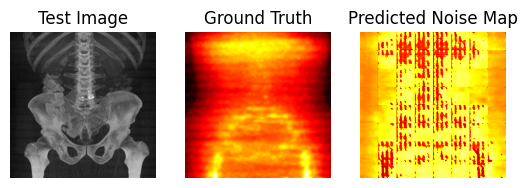

In [19]:
plt.subplot(131)
plt.imshow(np.rot90(test_image_final), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.rot90(ground_truth_final), cmap='hot')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(133)
plt.imshow(np.rot90(predicted_patches_final), cmap='hot')
plt.title('Predicted Noise Map')
plt.axis('off')

In [38]:
average_percent_error = (np.array(ground_truth) - np.array(predicted_patches)) / np.array(ground_truth)
print(len(ground_truth))
average_percent_error = abs(np.mean(average_percent_error))
print(average_percent_error)

64
0.14472269


In [ ]:
epsilon = 1e-8
ground_truth_final_safe = ground_truth_final + (ground_truth_final == 0) * epsilon
#average_percent_error = (np.array(ground_truth) - np.array(predicted_patches_final)) / np.array(ground_truth)

# Calculate the percentage error
percent_error = (ground_truth_final - predicted_patches_final) / ground_truth_final_safe
average_percent_error = np.abs(np.mean(percent_error)) * 100  # Convert to percentage

print(f"Average Percentage Error: {average_percent_error:.2f}%")

# Plotting the percentage error as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(np.rot90(percent_error), cmap='coolwarm', interpolation='none')
plt.colorbar(label='Percentage Error (%)')
plt.title('Percentage Error Heatmap')
plt.axis('off')  # Hide the axes
plt.show()

Average Percentage Error: 14.90%


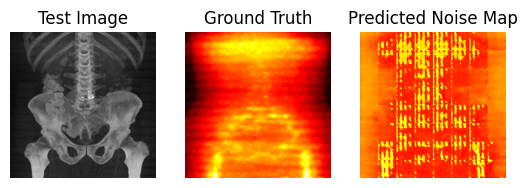

In [31]:
plt.subplot(131)
plt.imshow(np.rot90(test_image_final), cmap='gray')
plt.title('Test Image')
plt.axis('off')

# Define the 'gray' colormap
hot_cmap = plt.cm.hot

# Invert the colormap
hot_inverted = hot_cmap.reversed()

# Brightness factor (adjust as needed)
brightness_factor = 0.7

# Create a brighter version of the inverted colormap
gray_brighter = LinearSegmentedColormap.from_list('hot_brighter', hot_inverted(np.linspace(0, brightness_factor, 256)))

plt.subplot(132)
plt.imshow(np.rot90(ground_truth_final), cmap='hot')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(133)
# Plot the image with the brighter inverted grayscale colormap
plt.imshow(np.rot90(predicted_patches_final), cmap=gray_brighter)
plt.title('Predicted Noise Map')
plt.axis('off')
plt.show()